In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


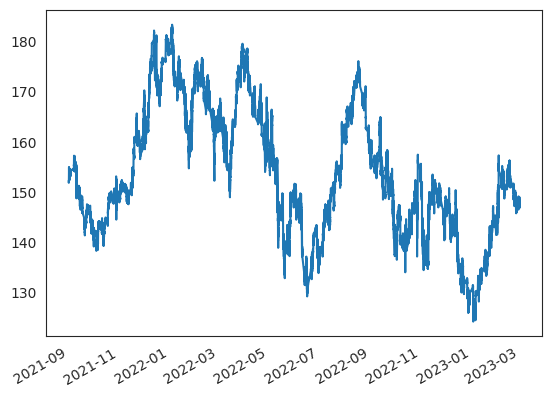

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
##### 1.5e12 ######
# {'min_prof_thr': (0.016690626891460527, 0.01914937310853947),
#  'max_down_prop': (0.005055517512256241, 0.0052844824877437595),
#  'gain_tightfact': (0.06258156924461009, 0.06442843075538993),
#  'tau_time': (9.997165462294742, 10.003114537705258),
#  'tau_dur': (7.497047680299028, 7.555712319700971),
#  'thresh_mode': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (0, 0),
#  'rsi_max_thresh': (66, 70),
#  'adx_thresh': (8.552802178185974, 8.645307821814026),
#  'atr_mult': (0.2997936509253488, 0.31198634907465117),
#  'vwap_atr_mult': (-2.003542773559526, -1.7800672264404735),
#  'buy_factor': (0.004935982052890333, 0.005774017947109668),
#  'sell_factor': (0.01003081719274689, 0.01115918280725311),
#  'trailstop_pct': (15.939942033425433, 17.86065796657457)}

##### 3e11 ######
# {'min_prof_thr': (-0.0025867651709173605, 0.009376765170917359),
#  'max_down_prop': (0.0021117462457834668, 0.0046282537542165336),
#  'gain_tightfact': (0.025934169886688174, 0.04553583011331183),
#  'tau_time': (8.14871959583157, 8.258420404168428),
#  'tau_dur': (5.274328228378261, 6.13339177162174),
#  'thresh_mode': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (0, 2),
#  'rsi_max_thresh': (79, 109),
#  'adx_thresh': (7.443533163797652, 9.061096836202346),
#  'atr_mult': (0.09063916029929553, 0.12457083970070448),
#  'vwap_atr_mult': (-2.899059454044301, 0.7521294540443009),
#  'buy_factor': (-0.004088046746404329, 0.007088046746404328),
#  'sell_factor': (-0.005813917610810894, 0.008653917610810894),
#  'trailstop_pct': (8.858183800998932, 24.185076199001074)}

In [5]:
prun_perc       = 80
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.001, 0.01)      
    max_down_prop   = trial.suggest_float("max_down_prop", 0.002, 0.005)    
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.03, 0.06)   
    tau_time        = trial.suggest_float("tau_time", 8, 9.5)          
    tau_dur         = trial.suggest_float("tau_dur", 5.5, 7)          
    
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                           ["median_nonzero"])
    thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
                       if "roll" in thresh_mode else None)
    
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 5)            
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 70), 100)          
    adx_thresh     = trial.suggest_float("adx_thresh", 7.5, 9)          
    atr_mult       = trial.suggest_float("atr_mult", 0.1, 0.2)             
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -3, 1)       
    buy_factor     = trial.suggest_float("buy_factor", 0.001, 0.01)        
    sell_factor    = trial.suggest_float("sell_factor", 0.001, 0.01)       
    trailstop_pct  = trial.suggest_float("trailstop_pct", 5, 25)       

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



Baseline mean daily B&H: -9.5162


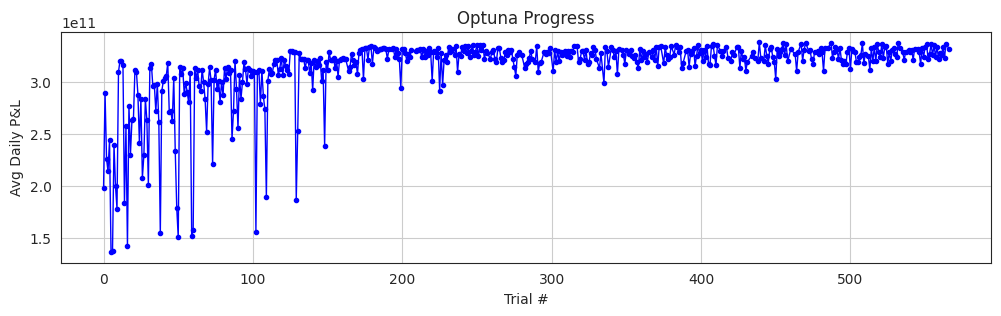

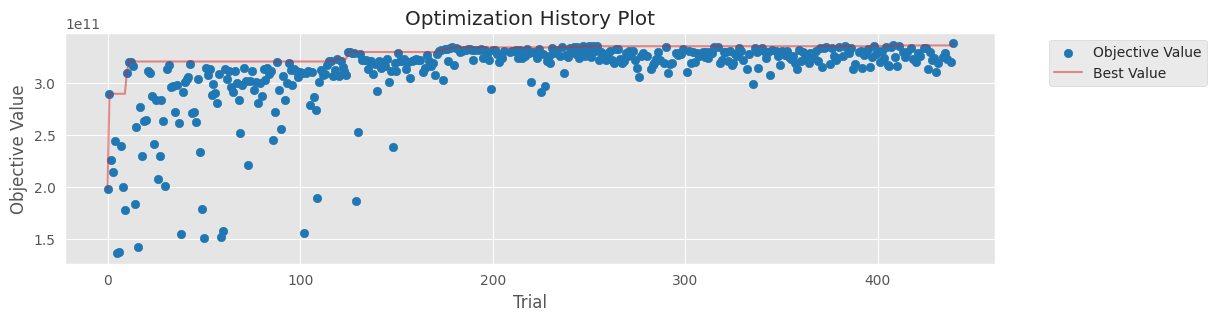

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004352749118715424; max_down_prop=0.0024033903239628; gain_tightfact=0.04617082043071814; tau_time=8.712220429178782; tau_dur=6.467668678227299; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=93; adx_thresh=8.523007143313205; atr_mult=0.1346267288489726; vwap_atr_mult=-1.2829680897451983; buy_factor=0.003342279228980395; sell_factor=0.007556713684757757; trailstop_pct=24.05045652681561


Trial 0: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:197954213339.5381 mean_bh:-8.7491 mean_excess:197954213348.2872 improv_vs_bh:2262569001627.53%
Action counts: {'Buy': 42811, 'Sell': 39023, 'Hold': 268877}
Best trial is: 0 with best_val: 197954213348.2872
[save_results] wrote optuna_results/AAPL_197954213348.2872_target.csv
[save_best_json] wrote optuna_results/AAPL_197954213348.2872_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001157517698818845; max_down_prop=0.003920812753360058; gain_tightfact=0.03359657179314568; tau_time=8.121898218042613; tau_dur=5.5342005903030635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=92; adx_thresh=8.828597712135707; atr_mult=0.11732627092074442; vwap_atr_mult=-2.828398947447415; buy_factor=0.004637649668679758; sell_factor=0.0021997901055557925; trailstop_pct=6.753894951293658


Trial 1: 100%|██████████| 375/375 [01:22<00:00,  4.53it/s]


[Results] mean_pnl:289848703691.4746 mean_bh:-8.7491 mean_excess:289848703700.2238 improv_vs_bh:3312900902999.26%
Action counts: {'Buy': 43106, 'Sell': 39234, 'Hold': 268371}
Best trial is: 1 with best_val: 289848703700.2238
[save_results] wrote optuna_results/AAPL_289848703700.2238_target.csv
[save_best_json] wrote optuna_results/AAPL_289848703700.2238_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003809478752005308; max_down_prop=0.0021868979547700006; gain_tightfact=0.03519915239764404; tau_time=8.504675446936357; tau_dur=5.853561539744913; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=91; adx_thresh=7.804587890780336; atr_mult=0.14043535273175806; vwap_atr_mult=-2.143305182274432; buy_factor=0.006975364713488129; sell_factor=0.0022990493831661963; trailstop_pct=9.36583754051675


Trial 2: 100%|██████████| 375/375 [01:47<00:00,  3.50it/s]


[Results] mean_pnl:226391666740.5457 mean_bh:-8.7491 mean_excess:226391666749.2948 improv_vs_bh:2587602247760.78%
Action counts: {'Buy': 43091, 'Sell': 39192, 'Hold': 268428}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005956653647922612; max_down_prop=0.0033053535137558742; gain_tightfact=0.037330268244670735; tau_time=8.399951938384524; tau_dur=6.274104697109602; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=93; adx_thresh=8.782377005199283; atr_mult=0.1845999656126768; vwap_atr_mult=-2.408909724322693; buy_factor=0.006732660078277703; sell_factor=0.007667268988298222; trailstop_pct=17.210006866159624


Trial 3: 100%|██████████| 375/375 [01:32<00:00,  4.06it/s]


[Results] mean_pnl:214270311187.1648 mean_bh:-8.7491 mean_excess:214270311195.9139 improv_vs_bh:2449058071969.32%
Action counts: {'Buy': 42796, 'Sell': 38998, 'Hold': 268917}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007052222423926584; max_down_prop=0.0038416350142281242; gain_tightfact=0.030277899378928996; tau_time=8.152316202382398; tau_dur=6.92597424799733; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=7.7650136257426965; atr_mult=0.18457990341949165; vwap_atr_mult=-1.4905675452024911; buy_factor=0.0021345045946488846; sell_factor=0.0077132144025160755; trailstop_pct=10.922669586841431


Trial 4: 100%|██████████| 375/375 [01:39<00:00,  3.76it/s]


[Results] mean_pnl:244451257236.3395 mean_bh:-8.7491 mean_excess:244451257245.0885 improv_vs_bh:2794019019329.96%
Action counts: {'Buy': 42800, 'Sell': 38979, 'Hold': 268932}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003458519850515408; max_down_prop=0.003954696474366673; gain_tightfact=0.03237065616189992; tau_time=9.246954777752492; tau_dur=6.879109687966984; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=90; adx_thresh=7.542794332772812; atr_mult=0.17997981787780104; vwap_atr_mult=-2.9355327197860324; buy_factor=0.006742165848282705; sell_factor=0.0020230508153732786; trailstop_pct=24.19207244501894


Trial 5: 100%|██████████| 375/375 [01:32<00:00,  4.05it/s]


[Results] mean_pnl:136429973013.2069 mean_bh:-8.7491 mean_excess:136429973021.9560 improv_vs_bh:1559361746492.62%
Action counts: {'Buy': 42547, 'Sell': 39022, 'Hold': 269142}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002460791738987121; max_down_prop=0.0027126243831061838; gain_tightfact=0.04561822987365481; tau_time=9.246038101177353; tau_dur=6.360034499693695; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=82; adx_thresh=7.824521423399626; atr_mult=0.15933746753403802; vwap_atr_mult=0.8924360730972554; buy_factor=0.0022134557071549566; sell_factor=0.0026580930010982294; trailstop_pct=12.121901684045845


Trial 6: 100%|██████████| 375/375 [00:57<00:00,  6.52it/s]


[Results] mean_pnl:137769302422.1571 mean_bh:-8.7491 mean_excess:137769302430.9062 improv_vs_bh:1574669959196.98%
Action counts: {'Buy': 42336, 'Sell': 38915, 'Hold': 269460}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013442152408509002; max_down_prop=0.0032814017002177737; gain_tightfact=0.05246227440996601; tau_time=8.302121057680093; tau_dur=6.080974031230824; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=71; adx_thresh=7.615176901548086; atr_mult=0.14457537321670808; vwap_atr_mult=0.3507101842789333; buy_factor=0.00193942856205779; sell_factor=0.009918777538227706; trailstop_pct=24.76183326962461


Trial 7: 100%|██████████| 375/375 [00:43<00:00,  8.53it/s]


[Results] mean_pnl:239787668939.8668 mean_bh:-8.7491 mean_excess:239787668948.6160 improv_vs_bh:2740715327847.59%
Action counts: {'Buy': 42400, 'Sell': 39030, 'Hold': 269281}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0067385864405634386; max_down_prop=0.002671668490411257; gain_tightfact=0.04055962060115248; tau_time=8.55111034383962; tau_dur=5.8731507178819164; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=79; adx_thresh=8.206090793570173; atr_mult=0.1853012218486257; vwap_atr_mult=-1.9303099791817164; buy_factor=0.004611242633532832; sell_factor=0.006125521369880649; trailstop_pct=14.153974704316292


Trial 8: 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]


[Results] mean_pnl:199845640505.6976 mean_bh:-8.7491 mean_excess:199845640514.4467 improv_vs_bh:2284187558780.74%
Action counts: {'Buy': 42819, 'Sell': 39025, 'Hold': 268867}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034913665936930514; max_down_prop=0.002674807997303385; gain_tightfact=0.0556319989862775; tau_time=8.835172541120638; tau_dur=6.856363162972474; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=100; adx_thresh=8.964222995780636; atr_mult=0.16470049923962615; vwap_atr_mult=-1.619944456542529; buy_factor=0.001658990050572332; sell_factor=0.00708794247824359; trailstop_pct=5.018539640463873


Trial 9: 100%|██████████| 375/375 [00:57<00:00,  6.50it/s]


[Results] mean_pnl:178499369804.8847 mean_bh:-8.7491 mean_excess:178499369813.6338 improv_vs_bh:2040204823727.60%
Action counts: {'Buy': 42720, 'Sell': 38861, 'Hold': 269130}
Best trial is: 1 with best_val: 289848703700.2238
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009585154564412791; max_down_prop=0.00482142762915632; gain_tightfact=0.041183935347472465; tau_time=8.07144789897217; tau_dur=5.512371412076459; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.285883911633737; atr_mult=0.10288702833170749; vwap_atr_mult=-0.5061076902524404; buy_factor=0.009851170712938728; sell_factor=0.003978866039234235; trailstop_pct=5.389241165128896


Trial 10: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s]


[Results] mean_pnl:309943666913.6116 mean_bh:-8.7491 mean_excess:309943666922.3607 improv_vs_bh:3542581494820.05%
Action counts: {'Buy': 43445, 'Sell': 39382, 'Hold': 267884}
Best trial is: 10 with best_val: 309943666922.3607
[save_results] wrote optuna_results/AAPL_309943666922.3607_target.csv
[save_best_json] wrote optuna_results/AAPL_309943666922.3607_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009498258834951907; max_down_prop=0.004956445804623066; gain_tightfact=0.0402542790123686; tau_time=8.003480342773484; tau_dur=5.53786996697302; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.236055808106169; atr_mult=0.10420908628642264; vwap_atr_mult=-0.45114427123636447; buy_factor=0.009912641775459662; sell_factor=0.004160183245587988; trailstop_pct=5.675600381331909


Trial 11: 100%|██████████| 375/375 [01:55<00:00,  3.24it/s]


[Results] mean_pnl:320703410884.2836 mean_bh:-8.7491 mean_excess:320703410893.0327 improv_vs_bh:3665562778025.47%
Action counts: {'Buy': 43468, 'Sell': 39365, 'Hold': 267878}
Best trial is: 11 with best_val: 320703410893.0327
[save_results] wrote optuna_results/AAPL_320703410893.0327_target.csv
[save_best_json] wrote optuna_results/AAPL_320703410893.0327_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009680515146847502; max_down_prop=0.004930479829206959; gain_tightfact=0.04180813108155709; tau_time=8.001197884801618; tau_dur=5.5483146733218325; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.180325379101122; atr_mult=0.10453108085551174; vwap_atr_mult=-0.43747982511243344; buy_factor=0.009997625583554806; sell_factor=0.003941702416592044; trailstop_pct=7.841500850091137


Trial 12: 100%|██████████| 375/375 [01:43<00:00,  3.63it/s]


[Results] mean_pnl:320909577540.3434 mean_bh:-8.7491 mean_excess:320909577549.0925 improv_vs_bh:3667919213270.16%
Action counts: {'Buy': 43478, 'Sell': 39365, 'Hold': 267868}
Best trial is: 12 with best_val: 320909577549.0925
[save_results] wrote optuna_results/AAPL_320909577549.0925_target.csv
[save_best_json] wrote optuna_results/AAPL_320909577549.0925_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009998546929989372; max_down_prop=0.004831780332945144; gain_tightfact=0.0504418601645182; tau_time=8.013537529205756; tau_dur=5.749483930115157; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.19647094941519; atr_mult=0.10358584190570172; vwap_atr_mult=-0.4564494135691355; buy_factor=0.009695291021283251; sell_factor=0.004379615523920655; trailstop_pct=8.748657627731049


Trial 13: 100%|██████████| 375/375 [01:48<00:00,  3.46it/s]


[Results] mean_pnl:316300950619.0401 mean_bh:-8.7491 mean_excess:316300950627.7891 improv_vs_bh:3615243717074.18%
Action counts: {'Buy': 43433, 'Sell': 39351, 'Hold': 267927}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008263106494786258; max_down_prop=0.0044373899923668735; gain_tightfact=0.041115770111640235; tau_time=8.967303312474899; tau_dur=5.703630415547501; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.044324882594683; atr_mult=0.12276982991889997; vwap_atr_mult=-0.536970932974904; buy_factor=0.0085421573861527; sell_factor=0.004194307407787438; trailstop_pct=17.916056482143723


Trial 14: 100%|██████████| 375/375 [01:32<00:00,  4.03it/s]


[Results] mean_pnl:183498113812.9021 mean_bh:-8.7491 mean_excess:183498113821.6512 improv_vs_bh:2097339264305.09%
Action counts: {'Buy': 42866, 'Sell': 39458, 'Hold': 268387}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008391448734732392; max_down_prop=0.00448733488272801; gain_tightfact=0.038061772373049405; tau_time=8.30862929398582; tau_dur=6.095760828347176; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.5085421025747; atr_mult=0.11580143107126943; vwap_atr_mult=0.245156470565409; buy_factor=0.008425385317813233; sell_factor=0.0010713556625057382; trailstop_pct=7.976709221423482


Trial 15: 100%|██████████| 375/375 [01:10<00:00,  5.30it/s]


[Results] mean_pnl:257461445668.7811 mean_bh:-8.7491 mean_excess:257461445677.5302 improv_vs_bh:2942722340944.97%
Action counts: {'Buy': 43008, 'Sell': 39180, 'Hold': 268523}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008348361152302492; max_down_prop=0.00497013822341082; gain_tightfact=0.04877629495449777; tau_time=9.432989689505586; tau_dur=6.00786524661919; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; adx_thresh=8.495916237203435; atr_mult=0.12950781246145468; vwap_atr_mult=-0.9702038723963468; buy_factor=0.008589366231089308; sell_factor=0.005278242948003479; trailstop_pct=13.208100871877235


Trial 16: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:142095850200.1720 mean_bh:-8.7491 mean_excess:142095850208.9211 improv_vs_bh:1624121358694.97%
Action counts: {'Buy': 42373, 'Sell': 39071, 'Hold': 269267}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008960375106672979; max_down_prop=0.004370666448221129; gain_tightfact=0.0437362992885194; tau_time=8.201109256542015; tau_dur=6.575285427755075; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.050785827266514; atr_mult=0.1002279136755034; vwap_atr_mult=0.026906761998620743; buy_factor=0.007785014560798208; sell_factor=0.0033187214988913533; trailstop_pct=16.564699399425336


Trial 17: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:277205931789.4619 mean_bh:-8.7491 mean_excess:277205931798.2109 improv_vs_bh:3168397063872.52%
Action counts: {'Buy': 43100, 'Sell': 39235, 'Hold': 268376}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007310512036807264; max_down_prop=0.004277380176368563; gain_tightfact=0.04380539279651286; tau_time=8.569037683059257; tau_dur=5.636007897590295; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=96; adx_thresh=8.36104359412786; atr_mult=0.11208313096399117; vwap_atr_mult=-0.9949338752942647; buy_factor=0.009410554575861381; sell_factor=0.005354454493820853; trailstop_pct=11.110872731938823


Trial 18: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:230396017928.9848 mean_bh:-8.7491 mean_excess:230396017937.7339 improv_vs_bh:2633371017807.88%
Action counts: {'Buy': 43193, 'Sell': 39281, 'Hold': 268237}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005425752449979133; max_down_prop=0.004605008333787222; gain_tightfact=0.058924957211059316; tau_time=8.014594329967244; tau_dur=5.863744962133257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=100; adx_thresh=8.013394781799255; atr_mult=0.1974390221955824; vwap_atr_mult=-0.07091582325088086; buy_factor=0.0055892531050809185; sell_factor=0.006079963069750707; trailstop_pct=7.128653022693923


Trial 19: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:263374342723.4966 mean_bh:-8.7491 mean_excess:263374342732.2456 improv_vs_bh:3010305330766.33%
Action counts: {'Buy': 43146, 'Sell': 39122, 'Hold': 268443}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008950038297564057; max_down_prop=0.0035481194865909817; gain_tightfact=0.037781900536695584; tau_time=8.28188049131692; tau_dur=5.501084894354215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.702836496642131; atr_mult=0.1281048901026259; vwap_atr_mult=0.7683297638398701; buy_factor=0.0074917621587730215; sell_factor=0.0034699146859610737; trailstop_pct=20.75419370151816


Trial 20: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:264497990103.7358 mean_bh:-8.7491 mean_excess:264497990112.4848 improv_vs_bh:3023148349807.39%
Action counts: {'Buy': 43171, 'Sell': 39201, 'Hold': 268339}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00975068229080746; max_down_prop=0.00498552234527459; gain_tightfact=0.05046371294310016; tau_time=8.032947149113422; tau_dur=5.720238378471493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.147592400577349; atr_mult=0.10657076416495309; vwap_atr_mult=-0.4890890052408187; buy_factor=0.00992520582309759; sell_factor=0.004607786334295811; trailstop_pct=8.732442868983025


Trial 21: 100%|██████████| 375/375 [00:57<00:00,  6.54it/s]


[Results] mean_pnl:311738376079.0356 mean_bh:-8.7491 mean_excess:311738376087.7846 improv_vs_bh:3563094588509.45%
Action counts: {'Buy': 43438, 'Sell': 39367, 'Hold': 267906}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00994968694363493; max_down_prop=0.004724155632988494; gain_tightfact=0.047660311147404336; tau_time=8.016029106096308; tau_dur=5.64857194802263; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=8.374210419397562; atr_mult=0.11017767837259418; vwap_atr_mult=-0.2999637189096473; buy_factor=0.009134845022792711; sell_factor=0.004928875327231136; trailstop_pct=10.38480374251008


Trial 22: 100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


[Results] mean_pnl:310260442320.5110 mean_bh:-8.7491 mean_excess:310260442329.2601 improv_vs_bh:3546202161458.08%
Action counts: {'Buy': 43355, 'Sell': 39291, 'Hold': 268065}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007630850464075092; max_down_prop=0.004234312938765124; gain_tightfact=0.05224343809649128; tau_time=8.19659227994806; tau_dur=5.772944422965642; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.906135488387932; atr_mult=0.10005948107353448; vwap_atr_mult=-0.8394135623566972; buy_factor=0.009113999862384016; sell_factor=0.003231992687956253; trailstop_pct=6.396616519365724


Trial 23: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:288121333291.1520 mean_bh:-8.7491 mean_excess:288121333299.9010 improv_vs_bh:3293157475183.35%
Action counts: {'Buy': 43367, 'Sell': 39336, 'Hold': 268008}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008982520912449957; max_down_prop=0.004780015579840422; gain_tightfact=0.04288618268458792; tau_time=8.413909941943087; tau_dur=5.9733248234330505; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=95; adx_thresh=8.142875974026685; atr_mult=0.12115397663690147; vwap_atr_mult=0.5544227482875363; buy_factor=0.009972310714903343; sell_factor=0.006313068215244872; trailstop_pct=8.440435230517632


Trial 24: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:241845567642.1003 mean_bh:-8.7491 mean_excess:241845567650.8494 improv_vs_bh:2764236614580.55%
Action counts: {'Buy': 43099, 'Sell': 39204, 'Hold': 268408}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009935051356016703; max_down_prop=0.004962671164687595; gain_tightfact=0.05551436763927254; tau_time=8.199916872179047; tau_dur=5.621903303191292; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.326101939097533; atr_mult=0.10943908065971886; vwap_atr_mult=-0.0903248330186725; buy_factor=0.00799629472654027; sell_factor=0.00431072189097891; trailstop_pct=9.514021098386014


Trial 25: 100%|██████████| 375/375 [01:02<00:00,  5.97it/s]


[Results] mean_pnl:283904331731.0154 mean_bh:-8.7491 mean_excess:283904331739.7644 improv_vs_bh:3244958162582.75%
Action counts: {'Buy': 43337, 'Sell': 39339, 'Hold': 268035}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007869030777823796; max_down_prop=0.0040770338718883; gain_tightfact=0.03948180926752487; tau_time=8.69921066582252; tau_dur=5.7704483144868615; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=94; adx_thresh=7.967299659204981; atr_mult=0.12586203916007366; vwap_atr_mult=-1.2449852692075183; buy_factor=0.005899850816127688; sell_factor=0.0037075186592327915; trailstop_pct=6.470972639348522


Trial 26: 100%|██████████| 375/375 [01:23<00:00,  4.47it/s]


[Results] mean_pnl:208112394198.4222 mean_bh:-8.7491 mean_excess:208112394207.1713 improv_vs_bh:2378674563289.91%
Action counts: {'Buy': 43053, 'Sell': 39145, 'Hold': 268513}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009170917008216314; max_down_prop=0.0046022266931057135; gain_tightfact=0.048180072574637384; tau_time=8.43438023471915; tau_dur=5.599872897709771; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=8.62756426579872; atr_mult=0.1509253754059405; vwap_atr_mult=-0.7258439583533605; buy_factor=0.009134588244678632; sell_factor=0.0011293665011882321; trailstop_pct=12.039003879434334


Trial 27: 100%|██████████| 375/375 [01:30<00:00,  4.13it/s]


[Results] mean_pnl:229768155313.9759 mean_bh:-8.7491 mean_excess:229768155322.7249 improv_vs_bh:2626194699274.56%
Action counts: {'Buy': 43055, 'Sell': 39167, 'Hold': 268489}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006425830433741452; max_down_prop=0.003663207107744636; gain_tightfact=0.04273780304015498; tau_time=8.121293479012142; tau_dur=6.669643325833951; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=98; adx_thresh=8.21729144338515; atr_mult=0.11673193826327989; vwap_atr_mult=-0.19984741829603014; buy_factor=0.008860005998344501; sell_factor=0.008783901725938946; trailstop_pct=15.635220975561232


Trial 28: 100%|██████████| 375/375 [01:52<00:00,  3.34it/s]


[Results] mean_pnl:283916102037.1927 mean_bh:-8.7491 mean_excess:283916102045.9418 improv_vs_bh:3245092694348.68%
Action counts: {'Buy': 43169, 'Sell': 39230, 'Hold': 268312}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005243415858894419; max_down_prop=0.004728035643020991; gain_tightfact=0.04622963559792757; tau_time=8.275411336564733; tau_dur=6.183063129015618; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.460534400609808; atr_mult=0.13288658291019764; vwap_atr_mult=-1.2567899222380532; buy_factor=0.0031171267850988588; sell_factor=0.0027896413933157713; trailstop_pct=22.1631196280755


Trial 29: 100%|██████████| 375/375 [01:09<00:00,  5.41it/s]


[Results] mean_pnl:263630831850.8742 mean_bh:-8.7491 mean_excess:263630831859.6233 improv_vs_bh:3013236939743.19%
Action counts: {'Buy': 43065, 'Sell': 39252, 'Hold': 268394}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008410304649641468; max_down_prop=0.004177429859822308; gain_tightfact=0.03636112485792006; tau_time=8.684806071377071; tau_dur=5.80116724001033; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=93; adx_thresh=8.602270398150633; atr_mult=0.13957674807711204; vwap_atr_mult=0.22489301755007818; buy_factor=0.007436197905920012; sell_factor=0.004791550496220689; trailstop_pct=7.699880282687927


Trial 30: 100%|██████████| 375/375 [01:07<00:00,  5.56it/s]


[Results] mean_pnl:201507674346.4479 mean_bh:-8.7491 mean_excess:201507674355.1971 improv_vs_bh:2303184205450.35%
Action counts: {'Buy': 42878, 'Sell': 39012, 'Hold': 268821}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009491135135218353; max_down_prop=0.004960777945499065; gain_tightfact=0.05065670990940354; tau_time=8.016459830449342; tau_dur=5.714003491606963; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.116030220968444; atr_mult=0.10692064661947498; vwap_atr_mult=-0.4416087039022407; buy_factor=0.009668419294275919; sell_factor=0.004282969076769069; trailstop_pct=8.865622639005863


Trial 31: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:313967020966.1155 mean_bh:-8.7491 mean_excess:313967020974.8646 improv_vs_bh:3588567463028.52%
Action counts: {'Buy': 43458, 'Sell': 39368, 'Hold': 267885}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009345042100084567; max_down_prop=0.00456249277518648; gain_tightfact=0.051284540220891024; tau_time=8.004127879841146; tau_dur=5.584974162857662; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.122218176679773; atr_mult=0.10679644437597402; vwap_atr_mult=-0.6447659213339829; buy_factor=0.009667887359826006; sell_factor=0.004011258363360379; trailstop_pct=5.967677172558998


Trial 32: 100%|██████████| 375/375 [01:00<00:00,  6.16it/s]


[Results] mean_pnl:317874545966.6157 mean_bh:-8.7491 mean_excess:317874545975.3647 improv_vs_bh:3633229533058.13%
Action counts: {'Buy': 43469, 'Sell': 39372, 'Hold': 267870}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009242042784537751; max_down_prop=0.004562857066450383; gain_tightfact=0.05376307413467938; tau_time=8.114381031606547; tau_dur=5.585659496101395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=92; adx_thresh=8.26015005455987; atr_mult=0.11503371217265329; vwap_atr_mult=-0.6985386198768258; buy_factor=0.008206376600256374; sell_factor=0.005605928105937175; trailstop_pct=5.692475550740907


Trial 33: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:296081987193.5854 mean_bh:-8.7491 mean_excess:296081987202.3344 improv_vs_bh:3384145832782.19%
Action counts: {'Buy': 43291, 'Sell': 39288, 'Hold': 268132}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008689952342645942; max_down_prop=0.004724044234491518; gain_tightfact=0.059337038898025274; tau_time=8.113935817212278; tau_dur=5.938653062085429; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.422470246458927; atr_mult=0.10552785376976814; vwap_atr_mult=-0.25740388462972613; buy_factor=0.00940009403799893; sell_factor=0.0028484273571853995; trailstop_pct=6.895373125454787


Trial 34: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:297528670894.4145 mean_bh:-8.7491 mean_excess:297528670903.1637 improv_vs_bh:3400681079197.46%
Action counts: {'Buy': 43290, 'Sell': 39289, 'Hold': 268132}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007733332228458543; max_down_prop=0.0044138549996836475; gain_tightfact=0.04609588164539651; tau_time=8.245680063618556; tau_dur=5.555922362997613; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=94; adx_thresh=7.94189183955138; atr_mult=0.11989936767115103; vwap_atr_mult=-0.7249205760917604; buy_factor=0.008764795776021402; sell_factor=0.0021612654733433882; trailstop_pct=10.195645528197064


Trial 35: 100%|██████████| 375/375 [00:51<00:00,  7.23it/s]


[Results] mean_pnl:271902967789.2649 mean_bh:-8.7491 mean_excess:271902967798.0139 improv_vs_bh:3107785462024.56%
Action counts: {'Buy': 43333, 'Sell': 39292, 'Hold': 268086}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004441524847589764; max_down_prop=0.004793941892230352; gain_tightfact=0.05021648625050679; tau_time=8.12598222647107; tau_dur=5.506733256347845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=91; adx_thresh=8.109443909939339; atr_mult=0.11315823001582674; vwap_atr_mult=-1.160191498856146; buy_factor=0.0041838778323777205; sell_factor=0.0037823974804971783; trailstop_pct=5.904070159589797


Trial 36: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:298654084373.5195 mean_bh:-8.7491 mean_excess:298654084382.2687 improv_vs_bh:3413544284323.37%
Action counts: {'Buy': 43341, 'Sell': 39347, 'Hold': 268023}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00994839331380831; max_down_prop=0.0032730152630451306; gain_tightfact=0.03447500771125918; tau_time=8.348008445429064; tau_dur=5.673707098141789; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=7.827029770531418; atr_mult=0.1072538758948263; vwap_atr_mult=-1.5137932520491897; buy_factor=0.007077500079895003; sell_factor=0.0017024045690028516; trailstop_pct=7.200125796373384


Trial 37: 100%|██████████| 375/375 [00:51<00:00,  7.25it/s]


[Results] mean_pnl:261544984678.2069 mean_bh:-8.7491 mean_excess:261544984686.9559 improv_vs_bh:2989396208721.69%
Action counts: {'Buy': 43346, 'Sell': 39297, 'Hold': 268068}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00943362984584072; max_down_prop=0.0030930602662691048; gain_tightfact=0.0560139420048692; tau_time=9.077191131707613; tau_dur=6.366100484383737; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=95; adx_thresh=8.241083562397874; atr_mult=0.13496019872573373; vwap_atr_mult=0.062182940497838235; buy_factor=0.009396695777519198; sell_factor=0.006802828158767546; trailstop_pct=9.521673728487595


Trial 38: 100%|██████████| 375/375 [00:43<00:00,  8.71it/s]


[Results] mean_pnl:154519129487.2051 mean_bh:-8.7491 mean_excess:154519129495.9542 improv_vs_bh:1766116450074.75%
Action counts: {'Buy': 42444, 'Sell': 38956, 'Hold': 269311}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00603838741351408; max_down_prop=0.003790616795406587; gain_tightfact=0.03943957773115064; tau_time=8.187236745115042; tau_dur=5.8133824010228; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=98; adx_thresh=8.17924119674507; atr_mult=0.1003411040748022; vwap_atr_mult=0.43006981061481486; buy_factor=0.006072216001214157; sell_factor=0.0049794026154229105; trailstop_pct=11.567837356748438


Trial 39: 100%|██████████| 375/375 [00:45<00:00,  8.21it/s]


[Results] mean_pnl:291587112727.2056 mean_bh:-8.7491 mean_excess:291587112735.9548 improv_vs_bh:3332770499760.38%
Action counts: {'Buy': 43282, 'Sell': 39334, 'Hold': 268095}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008060195546962152; max_down_prop=0.00218446487083024; gain_tightfact=0.031423349667647586; tau_time=8.000795182357706; tau_dur=5.905090985057206; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=91; adx_thresh=7.684979036148947; atr_mult=0.12377404640561056; vwap_atr_mult=-2.4891357045803493; buy_factor=0.009562909200402623; sell_factor=0.003007580536385721; trailstop_pct=13.610902539850077


Trial 40: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:301109679051.8024 mean_bh:-8.7491 mean_excess:301109679060.5515 improv_vs_bh:3441611140318.34%
Action counts: {'Buy': 43341, 'Sell': 39254, 'Hold': 268116}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009544428372681818; max_down_prop=0.004896270631887965; gain_tightfact=0.050798988103868424; tau_time=8.082188502542998; tau_dur=5.696668683931285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.102113115698025; atr_mult=0.10665096945875623; vwap_atr_mult=-0.44623216912807356; buy_factor=0.009945814605955705; sell_factor=0.0044216732225676484; trailstop_pct=8.634440700652378


Trial 41: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:303675092352.2600 mean_bh:-8.7491 mean_excess:303675092361.0090 improv_vs_bh:3470933196726.23%
Action counts: {'Buy': 43403, 'Sell': 39353, 'Hold': 267955}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008703348446117391; max_down_prop=0.004627349946594215; gain_tightfact=0.0537847678220762; tau_time=8.05625913307299; tau_dur=5.5812387333278215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.892860780669366; atr_mult=0.11057762661654841; vwap_atr_mult=-0.3450446741806955; buy_factor=0.009576011159405415; sell_factor=0.003977908332972302; trailstop_pct=5.186831938795425


Trial 42: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:306481053373.3912 mean_bh:-8.7491 mean_excess:306481053382.1403 improv_vs_bh:3503004655670.21%
Action counts: {'Buy': 43478, 'Sell': 39358, 'Hold': 267875}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009375451110892516; max_down_prop=0.004990264406186787; gain_tightfact=0.04937234059665863; tau_time=8.003925041107664; tau_dur=5.740541917508747; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.070324343900895; atr_mult=0.10446274660765184; vwap_atr_mult=-0.6641594812380057; buy_factor=0.008934851280787422; sell_factor=0.005703899475948107; trailstop_pct=7.662573330397495


Trial 43: 100%|██████████| 375/375 [01:29<00:00,  4.20it/s]


[Results] mean_pnl:318299503170.5414 mean_bh:-8.7491 mean_excess:318299503179.2904 improv_vs_bh:3638086691591.70%
Action counts: {'Buy': 43442, 'Sell': 39354, 'Hold': 267915}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024167640087654017; max_down_prop=0.00480866383779979; gain_tightfact=0.047579585631740334; tau_time=8.155720174250256; tau_dur=5.753760662814235; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.282814781335484; atr_mult=0.16493545509963012; vwap_atr_mult=-0.6305636636488008; buy_factor=0.008901979244246927; sell_factor=0.005763007500582052; trailstop_pct=7.619485049139555


Trial 44: 100%|██████████| 375/375 [01:21<00:00,  4.60it/s]


[Results] mean_pnl:271069556877.6418 mean_bh:-8.7491 mean_excess:271069556886.3909 improv_vs_bh:3098259775946.14%
Action counts: {'Buy': 43211, 'Sell': 39295, 'Hold': 268205}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008709714640383703; max_down_prop=0.00403258340123896; gain_tightfact=0.05326294156261969; tau_time=8.235971805129534; tau_dur=6.038334398081549; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=95; adx_thresh=7.991003657060925; atr_mult=0.11831134353119627; vwap_atr_mult=-0.9375474956245577; buy_factor=0.001169981517044641; sell_factor=0.005077525662190525; trailstop_pct=6.056716890608378


Trial 45: 100%|██████████| 375/375 [01:05<00:00,  5.74it/s]


[Results] mean_pnl:272314394295.1221 mean_bh:-8.7491 mean_excess:272314394303.8712 improv_vs_bh:3112487967936.69%
Action counts: {'Buy': 43230, 'Sell': 39171, 'Hold': 268310}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00726007566023785; max_down_prop=0.004516549470730567; gain_tightfact=0.04904901259282301; tau_time=8.342151421048294; tau_dur=5.837264492349031; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.05747136499261; atr_mult=0.10347088839598281; vwap_atr_mult=-1.077758246706455; buy_factor=0.008278260161225053; sell_factor=0.006708568652483222; trailstop_pct=10.212468821585858


Trial 46: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:262281289120.9572 mean_bh:-8.7491 mean_excess:262281289129.7064 improv_vs_bh:2997811991239.02%
Action counts: {'Buy': 43278, 'Sell': 39308, 'Hold': 268125}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009346585122972446; max_down_prop=0.002360964319049822; gain_tightfact=0.04462813247561074; tau_time=8.074749707308701; tau_dur=5.561788884821608; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.400371231304248; atr_mult=0.1122208568320769; vwap_atr_mult=-1.7590180475981896; buy_factor=0.009208639752912265; sell_factor=0.0036173560481672115; trailstop_pct=5.044183712612014


Trial 47: 100%|██████████| 375/375 [00:37<00:00,  9.98it/s]


[Results] mean_pnl:304263282106.6293 mean_bh:-8.7491 mean_excess:304263282115.3783 improv_vs_bh:3477656064013.58%
Action counts: {'Buy': 43191, 'Sell': 39348, 'Hold': 268172}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009560058521912006; max_down_prop=0.00486179863668605; gain_tightfact=0.041865483506813836; tau_time=8.490127888293252; tau_dur=5.663774917069177; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=70; adx_thresh=8.183034591984443; atr_mult=0.10377153755140828; vwap_atr_mult=-0.757652553056331; buy_factor=0.008624550626722014; sell_factor=0.0024741746115695858; trailstop_pct=7.848122217354274


Trial 48: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:233717242826.7487 mean_bh:-8.7491 mean_excess:233717242835.4977 improv_vs_bh:2671331818813.38%
Action counts: {'Buy': 42515, 'Sell': 39139, 'Hold': 269057}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008632064781157325; max_down_prop=0.004322639705601305; gain_tightfact=0.05174609345077038; tau_time=8.80719527887868; tau_dur=6.192487699644619; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=99; adx_thresh=7.711920766082915; atr_mult=0.17616657691101223; vwap_atr_mult=-0.17184956594500372; buy_factor=0.006444449769281959; sell_factor=0.005842100286698689; trailstop_pct=19.102921868472556


Trial 49: 100%|██████████| 375/375 [00:45<00:00,  8.23it/s]


[Results] mean_pnl:179080349281.3532 mean_bh:-8.7491 mean_excess:179080349290.1023 improv_vs_bh:2046845279274.39%
Action counts: {'Buy': 42930, 'Sell': 39049, 'Hold': 268732}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009114987855270089; max_down_prop=0.00466814144874065; gain_tightfact=0.03982438541053196; tau_time=9.4395219823326; tau_dur=5.542972736505838; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.320817848171203; atr_mult=0.11476011180501308; vwap_atr_mult=-1.3885050905448983; buy_factor=0.0049043675208907365; sell_factor=0.005310524015504088; trailstop_pct=12.554189244998165


Trial 50: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:150710845252.7787 mean_bh:-8.7491 mean_excess:150710845261.5277 improv_vs_bh:1722588678109.42%
Action counts: {'Buy': 42812, 'Sell': 39265, 'Hold': 268634}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00955992779245713; max_down_prop=0.004990127221298971; gain_tightfact=0.049894901926973365; tau_time=8.000840901954989; tau_dur=5.719299562144715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.073981399073615; atr_mult=0.10747856552089195; vwap_atr_mult=-0.4324121486844037; buy_factor=0.009786433670513054; sell_factor=0.004183975559698979; trailstop_pct=8.866629725579013


Trial 51: 100%|██████████| 375/375 [00:39<00:00,  9.51it/s]


[Results] mean_pnl:314803464401.8121 mean_bh:-8.7491 mean_excess:314803464410.5613 improv_vs_bh:3598127810127.03%
Action counts: {'Buy': 43458, 'Sell': 39350, 'Hold': 267903}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00972885494486395; max_down_prop=0.004997202739963874; gain_tightfact=0.04616940253536396; tau_time=8.076879808216868; tau_dur=5.630254173187015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.05088011490986; atr_mult=0.10276930618242401; vwap_atr_mult=-0.5774316062280523; buy_factor=0.00963730809097695; sell_factor=0.0046512065084867915; trailstop_pct=6.631745274672706


Trial 52: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:307571487858.9990 mean_bh:-8.7491 mean_excess:307571487867.7481 improv_vs_bh:3515468059321.54%
Action counts: {'Buy': 43440, 'Sell': 39369, 'Hold': 267902}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009983504841033001; max_down_prop=0.004855269243496179; gain_tightfact=0.047094448635830254; tau_time=8.001649246384241; tau_dur=5.73423727206102; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.205819878289699; atr_mult=0.10896834110025447; vwap_atr_mult=0.12574476746996988; buy_factor=0.009960469245206589; sell_factor=0.003936029170924223; trailstop_pct=9.231991652853281


Trial 53: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:313218041552.9006 mean_bh:-8.7491 mean_excess:313218041561.6495 improv_vs_bh:3580006808650.25%
Action counts: {'Buy': 43444, 'Sell': 39343, 'Hold': 267924}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008173137433280391; max_down_prop=0.004480521240735504; gain_tightfact=0.04458357974496566; tau_time=8.166084129146896; tau_dur=5.88555169786891; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=94; adx_thresh=7.849439645306208; atr_mult=0.10051859340988824; vwap_atr_mult=-0.8881908114837691; buy_factor=0.008994480722973526; sell_factor=0.004171726824401913; trailstop_pct=8.060474811484386


Trial 54: 100%|██████████| 375/375 [01:05<00:00,  5.76it/s]


[Results] mean_pnl:289018587800.2673 mean_bh:-8.7491 mean_excess:289018587809.0162 improv_vs_bh:3303412878210.93%
Action counts: {'Buy': 43307, 'Sell': 39294, 'Hold': 268110}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008986121939783315; max_down_prop=0.004874895541573054; gain_tightfact=0.049332635866615904; tau_time=8.072824513542534; tau_dur=5.624070354768952; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.093763333733438; atr_mult=0.11899816482063848; vwap_atr_mult=-0.42361433642584384; buy_factor=0.007810206304393483; sell_factor=0.0032138087719326774; trailstop_pct=10.950434769280823


Trial 55: 100%|██████████| 375/375 [00:48<00:00,  7.78it/s]


[Results] mean_pnl:299550594758.4619 mean_bh:-8.7491 mean_excess:299550594767.2109 improv_vs_bh:3423791182190.80%
Action counts: {'Buy': 43394, 'Sell': 39319, 'Hold': 267998}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009247449123517913; max_down_prop=0.0046728850524602105; gain_tightfact=0.05650010851055917; tau_time=8.154945751930502; tau_dur=5.51003485538483; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.319633345141172; atr_mult=0.1127402851294037; vwap_atr_mult=-0.04142519130335476; buy_factor=0.009361271943747007; sell_factor=0.004576254451922768; trailstop_pct=7.067124105962056


Trial 56: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:290466214714.7830 mean_bh:-8.7491 mean_excess:290466214723.5321 improv_vs_bh:3319958905331.56%
Action counts: {'Buy': 43378, 'Sell': 39390, 'Hold': 267943}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00960193104294587; max_down_prop=0.0029629641563900617; gain_tightfact=0.054671746026763085; tau_time=8.22858184435091; tau_dur=5.817277817367067; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=95; adx_thresh=7.990653969106715; atr_mult=0.10467083971385831; vwap_atr_mult=-0.3335617218336894; buy_factor=0.009680794737081425; sell_factor=0.0051394504515296915; trailstop_pct=6.178722234165419


Trial 57: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:280540556222.3129 mean_bh:-8.7491 mean_excess:280540556231.0619 improv_vs_bh:3206511018338.16%
Action counts: {'Buy': 43324, 'Sell': 39265, 'Hold': 268122}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008593252935787225; max_down_prop=0.0020141109700108533; gain_tightfact=0.05206599594637143; tau_time=8.048913134638273; tau_dur=5.684048768515937; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=8.164656139394303; atr_mult=0.10944691025286915; vwap_atr_mult=-0.5449084997045346; buy_factor=0.008718744443352577; sell_factor=0.0036072325920138495; trailstop_pct=9.76385125428207


Trial 58: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:309206351931.4149 mean_bh:-8.7491 mean_excess:309206351940.1639 improv_vs_bh:3534154162080.14%
Action counts: {'Buy': 43312, 'Sell': 39379, 'Hold': 268020}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010523354740692758; max_down_prop=0.004995510524062453; gain_tightfact=0.049488655904822265; tau_time=9.203487435331848; tau_dur=6.723974417113432; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.9223632031247675; atr_mult=0.14874185888465008; vwap_atr_mult=-0.8126895189315972; buy_factor=0.008244465565975294; sell_factor=0.00630810490955545; trailstop_pct=8.122226609789674


Trial 59: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:152483752189.7328 mean_bh:-8.7491 mean_excess:152483752198.4818 improv_vs_bh:1742852577576.24%
Action counts: {'Buy': 42720, 'Sell': 39181, 'Hold': 268810}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0075281733104044166; max_down_prop=0.00475403724599305; gain_tightfact=0.057319750055835686; tau_time=8.962892987221862; tau_dur=5.769469964238898; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=99; adx_thresh=8.978875800367558; atr_mult=0.1989080999714138; vwap_atr_mult=-1.0735409901495223; buy_factor=0.009100159746206586; sell_factor=0.007717723106628028; trailstop_pct=14.411269563726645


Trial 60: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:157666062077.3303 mean_bh:-8.7491 mean_excess:157666062086.0794 improv_vs_bh:1802085131964.34%
Action counts: {'Buy': 42528, 'Sell': 39135, 'Hold': 269048}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009671362406698266; max_down_prop=0.004903119684790714; gain_tightfact=0.05111426059264759; tau_time=8.009949789482508; tau_dur=5.721421677837911; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.11580510044876; atr_mult=0.10729645874514937; vwap_atr_mult=-0.4116317029763744; buy_factor=0.009977566767140131; sell_factor=0.004270066817104056; trailstop_pct=8.888290929006782


Trial 61: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:313803889104.5607 mean_bh:-8.7491 mean_excess:313803889113.3098 improv_vs_bh:3586702905124.51%
Action counts: {'Buy': 43460, 'Sell': 39356, 'Hold': 267895}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008901099488559725; max_down_prop=0.004904071739894116; gain_tightfact=0.04991446820589553; tau_time=8.106533967240463; tau_dur=5.586925207582652; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.034371255654014; atr_mult=0.10320166419973915; vwap_atr_mult=-0.6071572750590852; buy_factor=0.009691897881063486; sell_factor=0.0042049852526638435; trailstop_pct=7.494238146248847


Trial 62: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:303631825055.5102 mean_bh:-8.7491 mean_excess:303631825064.2592 improv_vs_bh:3470438661940.87%
Action counts: {'Buy': 43411, 'Sell': 39370, 'Hold': 267930}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00929955065417263; max_down_prop=0.004612142185736192; gain_tightfact=0.05149682253953184; tau_time=8.000348738227084; tau_dur=5.659961942446472; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.26749734460615; atr_mult=0.1163543690876443; vwap_atr_mult=-0.16219257161782014; buy_factor=0.009650576846558187; sell_factor=0.0047518971576963115; trailstop_pct=8.693066810710828


Trial 63: 100%|██████████| 375/375 [00:48<00:00,  7.79it/s]


[Results] mean_pnl:311791754764.9990 mean_bh:-8.7491 mean_excess:311791754773.7480 improv_vs_bh:3563704694039.24%
Action counts: {'Buy': 43402, 'Sell': 39323, 'Hold': 267986}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00983865540769038; max_down_prop=0.004755804196897128; gain_tightfact=0.038502140757120766; tau_time=8.050502662912564; tau_dur=5.9529399382194494; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.07914713080883; atr_mult=0.12337807764913994; vwap_atr_mult=-0.2559215446388381; buy_factor=0.009330192694596826; sell_factor=0.0033609315554427813; trailstop_pct=5.685835194871096


Trial 64: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:296111174363.1785 mean_bh:-8.7491 mean_excess:296111174371.9277 improv_vs_bh:3384479435103.90%
Action counts: {'Buy': 43316, 'Sell': 39256, 'Hold': 268139}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00939992507852379; max_down_prop=0.004976306455014154; gain_tightfact=0.052926410111129696; tau_time=8.1397117228284; tau_dur=5.7186468874253364; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=8.142272948548111; atr_mult=0.10999665122552595; vwap_atr_mult=-0.4996405261683781; buy_factor=0.008933347649947857; sell_factor=0.003903035297228493; trailstop_pct=7.056623040347031


Trial 65: 100%|██████████| 375/375 [00:47<00:00,  7.97it/s]


[Results] mean_pnl:291915199546.6918 mean_bh:-8.7491 mean_excess:291915199555.4411 improv_vs_bh:3336520453121.09%
Action counts: {'Buy': 43298, 'Sell': 39320, 'Hold': 268093}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008915225429276764; max_down_prop=0.0045461676669060975; gain_tightfact=0.04691209467748315; tau_time=8.054165052628644; tau_dur=5.55281826184622; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=8.231165460962337; atr_mult=0.1001448871333822; vwap_atr_mult=-0.8599090564417868; buy_factor=0.008392106035559186; sell_factor=0.005387471406710658; trailstop_pct=10.264610657083661


Trial 66: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:312162445973.6399 mean_bh:-8.7491 mean_excess:312162445982.3890 improv_vs_bh:3567941605311.09%
Action counts: {'Buy': 43414, 'Sell': 39324, 'Hold': 267973}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008398808234804312; max_down_prop=0.004814321291131512; gain_tightfact=0.048267374277819075; tau_time=8.114398928502728; tau_dur=5.616295374378997; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.968065447321042; atr_mult=0.10707524223150645; vwap_atr_mult=-0.6487042479722623; buy_factor=0.009731369870048337; sell_factor=0.004363891154034752; trailstop_pct=6.595513217149486


Trial 67: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:299746327807.5952 mean_bh:-8.7491 mean_excess:299746327816.3442 improv_vs_bh:3426028363820.19%
Action counts: {'Buy': 43411, 'Sell': 39374, 'Hold': 267926}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004609588715283064; max_down_prop=0.004423738901578558; gain_tightfact=0.04155643057627418; tau_time=8.19381970523502; tau_dur=6.420015135182436; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=8.338421951391327; atr_mult=0.11309207072856142; vwap_atr_mult=0.13073384780792097; buy_factor=0.003200885478644839; sell_factor=0.0030328032877811476; trailstop_pct=8.380267944343721


Trial 68: 100%|██████████| 375/375 [00:42<00:00,  8.88it/s]


[Results] mean_pnl:283447937999.9435 mean_bh:-8.7491 mean_excess:283447938008.6927 improv_vs_bh:3239741692112.16%
Action counts: {'Buy': 43171, 'Sell': 39324, 'Hold': 268216}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007986423397513515; max_down_prop=0.004701293159350634; gain_tightfact=0.04312272118803627; tau_time=8.2898040221524; tau_dur=5.86651994550914; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=84; adx_thresh=8.027615367102827; atr_mult=0.10502345424664711; vwap_atr_mult=-0.10237877830192033; buy_factor=0.009422915970325518; sell_factor=0.004857689282052476; trailstop_pct=9.19684305634425


Trial 69: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:252486143259.6249 mean_bh:-8.7491 mean_excess:252486143268.3739 improv_vs_bh:2885855832198.96%
Action counts: {'Buy': 43058, 'Sell': 39030, 'Hold': 268623}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009986484492558727; max_down_prop=0.004913841360783487; gain_tightfact=0.03656484600270293; tau_time=8.051278855669254; tau_dur=5.788237459826212; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.154700077405785; atr_mult=0.12774564840501412; vwap_atr_mult=-1.0060351467676547; buy_factor=0.008005926642832471; sell_factor=0.0034959818198864374; trailstop_pct=11.645278496266107


Trial 70: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:298142156347.6563 mean_bh:-8.7491 mean_excess:298142156356.4053 improv_vs_bh:3407693070233.04%
Action counts: {'Buy': 43357, 'Sell': 39286, 'Hold': 268068}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009685110609680551; max_down_prop=0.0049124756323499765; gain_tightfact=0.050552372873561985; tau_time=8.003315811770833; tau_dur=5.736679471464557; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.135185383706471; atr_mult=0.10847919591713091; vwap_atr_mult=-0.38582300615213994; buy_factor=0.009842424500709516; sell_factor=0.004145575873765927; trailstop_pct=8.96896040151658


Trial 71: 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]


[Results] mean_pnl:314230047749.2675 mean_bh:-8.7491 mean_excess:314230047758.0166 improv_vs_bh:3591573795836.96%
Action counts: {'Buy': 43446, 'Sell': 39350, 'Hold': 267915}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009568573097466187; max_down_prop=0.004812523580315752; gain_tightfact=0.050534253668564476; tau_time=8.000402758877428; tau_dur=6.998458678422734; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.209096782933242; atr_mult=0.10814771471691664; vwap_atr_mult=-0.38613385739240186; buy_factor=0.00976081720540551; sell_factor=0.004494925451596777; trailstop_pct=7.656920085942793


Trial 72: 100%|██████████| 375/375 [00:42<00:00,  8.91it/s]


[Results] mean_pnl:301679487828.0312 mean_bh:-8.7491 mean_excess:301679487836.7803 improv_vs_bh:3448123917450.71%
Action counts: {'Buy': 43172, 'Sell': 39239, 'Hold': 268300}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009167998419462434; max_down_prop=0.004912315782248221; gain_tightfact=0.05456486833949978; tau_time=8.641622930791758; tau_dur=5.679747996508209; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.123414701563979; atr_mult=0.11506982724353171; vwap_atr_mult=-0.26371355886475445; buy_factor=0.009220768544652999; sell_factor=0.004058930805160681; trailstop_pct=9.706632744344223


Trial 73: 100%|██████████| 375/375 [00:50<00:00,  7.47it/s]


[Results] mean_pnl:220910801660.0061 mean_bh:-8.7491 mean_excess:220910801668.7552 improv_vs_bh:2524957279393.71%
Action counts: {'Buy': 43225, 'Sell': 39308, 'Hold': 268178}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009772951068902995; max_down_prop=0.004995464795241878; gain_tightfact=0.048623933448634866; tau_time=8.096751217847949; tau_dur=5.752047360072327; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=95; adx_thresh=8.274907426058705; atr_mult=0.10263604865926912; vwap_atr_mult=-0.5184352399542099; buy_factor=0.009999416963235782; sell_factor=0.0037637627868202265; trailstop_pct=5.6377708536239215


Trial 74: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:302360966371.9047 mean_bh:-8.7491 mean_excess:302360966380.6538 improv_vs_bh:3455913053143.06%
Action counts: {'Buy': 43327, 'Sell': 39280, 'Hold': 268104}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006862064271406482; max_down_prop=0.004660783967437526; gain_tightfact=0.05265212915746161; tau_time=8.037479806340627; tau_dur=5.598423811336653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.871097631257303; atr_mult=0.11192628117490871; vwap_atr_mult=-0.004863173701042944; buy_factor=0.008645593224258931; sell_factor=0.00549925713849839; trailstop_pct=10.981806648789876


Trial 75: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:312155135362.5103 mean_bh:-8.7491 mean_excess:312155135371.2595 improv_vs_bh:3567858046785.89%
Action counts: {'Buy': 43487, 'Sell': 39424, 'Hold': 267800}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00938222075999215; max_down_prop=0.004761124596924253; gain_tightfact=0.045523115803504086; tau_time=8.162975840867881; tau_dur=5.500290351227419; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.089118587171575; atr_mult=0.1057406241259385; vwap_atr_mult=-0.7242436038298773; buy_factor=0.009401255767004135; sell_factor=0.005043419461870692; trailstop_pct=6.264572215230986


Trial 76: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:293413475583.6675 mean_bh:-8.7491 mean_excess:293413475592.4166 improv_vs_bh:3353645387517.80%
Action counts: {'Buy': 43420, 'Sell': 39404, 'Hold': 267887}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027542510024349803; max_down_prop=0.004547397654280492; gain_tightfact=0.04985676855286533; tau_time=8.107329199843933; tau_dur=5.904651752809628; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.903501061242435; atr_mult=0.1210256780710576; vwap_atr_mult=-0.3207554226663498; buy_factor=0.00912437793481955; sell_factor=0.002587814928261435; trailstop_pct=8.330048788290378


Trial 77: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:301513271041.5736 mean_bh:-8.7491 mean_excess:301513271050.3226 improv_vs_bh:3446224099597.74%
Action counts: {'Buy': 43194, 'Sell': 39341, 'Hold': 268176}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008936328686616542; max_down_prop=0.004850841649206264; gain_tightfact=0.051675461156519505; tau_time=8.218445484176964; tau_dur=5.838380019980678; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=99; adx_thresh=8.004848513112812; atr_mult=0.10231744021233305; vwap_atr_mult=-0.7881714765221999; buy_factor=0.009540534666535667; sell_factor=0.004723047253822534; trailstop_pct=7.349359439364949


Trial 78: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:280912194546.9830 mean_bh:-8.7491 mean_excess:280912194555.7322 improv_vs_bh:3210758754918.22%
Action counts: {'Buy': 43309, 'Sell': 39252, 'Hold': 268150}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009740257889459553; max_down_prop=0.0049171439790871695; gain_tightfact=0.047628746761017395; tau_time=8.03936228423574; tau_dur=6.0043816500349285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.187911755268622; atr_mult=0.11791679549482673; vwap_atr_mult=-0.6470067098577993; buy_factor=0.008851908348355319; sell_factor=0.0030336483009711923; trailstop_pct=9.021210975511895


Trial 79: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:299764150252.7297 mean_bh:-8.7491 mean_excess:299764150261.4789 improv_vs_bh:3426232070077.37%
Action counts: {'Buy': 43300, 'Sell': 39279, 'Hold': 268132}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008545910176795117; max_down_prop=0.004163364065011471; gain_tightfact=0.05102687055587121; tau_time=8.141372856246418; tau_dur=5.655670891353335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=92; adx_thresh=7.508442122448384; atr_mult=0.10803834281535023; vwap_atr_mult=0.2971319653070037; buy_factor=0.009791864319694345; sell_factor=0.005773155439283923; trailstop_pct=6.6741451165505286


Trial 80: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:287839240736.6399 mean_bh:-8.7491 mean_excess:287839240745.3890 improv_vs_bh:3289933225198.29%
Action counts: {'Buy': 43278, 'Sell': 39275, 'Hold': 268158}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009613976454596112; max_down_prop=0.004925653495914841; gain_tightfact=0.040428027993185275; tau_time=8.026290306141293; tau_dur=5.716713331643079; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.142395587552945; atr_mult=0.10560977159376861; vwap_atr_mult=-0.4122845459788993; buy_factor=0.009973760675525396; sell_factor=0.004295978484768089; trailstop_pct=8.87325463529905


Trial 81: 100%|██████████| 375/375 [00:56<00:00,  6.58it/s]


[Results] mean_pnl:313837494354.5613 mean_bh:-8.7491 mean_excess:313837494363.3105 improv_vs_bh:3587087005041.64%
Action counts: {'Buy': 43427, 'Sell': 39357, 'Hold': 267927}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009488022830880214; max_down_prop=0.00481214619264458; gain_tightfact=0.03998882592405203; tau_time=8.090221240003023; tau_dur=5.716542022343653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.244955663450083; atr_mult=0.1112487273193861; vwap_atr_mult=-0.1444038192286896; buy_factor=0.002554441543073903; sell_factor=0.004069916580529373; trailstop_pct=9.583685253514176


Trial 82: 100%|██████████| 375/375 [00:43<00:00,  8.63it/s]


[Results] mean_pnl:302798674858.3777 mean_bh:-8.7491 mean_excess:302798674867.1268 improv_vs_bh:3460915955766.31%
Action counts: {'Buy': 43368, 'Sell': 39322, 'Hold': 268021}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009160295943648535; max_down_prop=0.004713837250642382; gain_tightfact=0.0421569037114493; tau_time=8.031964868174118; tau_dur=5.549165123420267; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.06703950241538; atr_mult=0.1051254637159261; vwap_atr_mult=-0.4757815023565393; buy_factor=0.009447006684759488; sell_factor=0.0037505752695980383; trailstop_pct=10.51967153063143


Trial 83: 100%|██████████| 375/375 [00:44<00:00,  8.36it/s]


[Results] mean_pnl:314961300494.2579 mean_bh:-8.7491 mean_excess:314961300503.0071 improv_vs_bh:3599931838665.07%
Action counts: {'Buy': 43480, 'Sell': 39370, 'Hold': 267861}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009214477333620661; max_down_prop=0.004696961139136594; gain_tightfact=0.038744409522622605; tau_time=8.079635165880163; tau_dur=5.558205849592118; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.063356624174249; atr_mult=0.1000845219777347; vwap_atr_mult=-0.5201212499852641; buy_factor=0.009521483953714266; sell_factor=0.0037681855920454863; trailstop_pct=10.24559232572026


Trial 84: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:308844109657.1832 mean_bh:-8.7491 mean_excess:308844109665.9323 improv_vs_bh:3530013820094.52%
Action counts: {'Buy': 43464, 'Sell': 39379, 'Hold': 267868}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008827704531483193; max_down_prop=0.004610809973484069; gain_tightfact=0.04396294563169022; tau_time=8.033027523313123; tau_dur=5.542908553473959; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.940659486056052; atr_mult=0.10943365010340991; vwap_atr_mult=-0.5862568762201429; buy_factor=0.009299896771778761; sell_factor=0.003302041581036511; trailstop_pct=7.8492453582479795


Trial 85: 100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


[Results] mean_pnl:311918120607.3822 mean_bh:-8.7491 mean_excess:311918120616.1312 improv_vs_bh:3565149025195.44%
Action counts: {'Buy': 43498, 'Sell': 39378, 'Hold': 267835}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009149731741056497; max_down_prop=0.004480472111620979; gain_tightfact=0.04198518351348685; tau_time=8.176860676604756; tau_dur=5.625476515822581; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=7.776299738008398; atr_mult=0.19070001250555552; vwap_atr_mult=-0.24678689806890594; buy_factor=0.008494339301303904; sell_factor=0.009879332383052948; trailstop_pct=5.357593143715497


Trial 86: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:245404174935.2615 mean_bh:-8.7491 mean_excess:245404174944.0106 improv_vs_bh:2804910639216.27%
Action counts: {'Buy': 43216, 'Sell': 39175, 'Hold': 268320}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00997678809417674; max_down_prop=0.00473461514764031; gain_tightfact=0.04079081042172922; tau_time=8.262788977973477; tau_dur=5.594003235458976; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.372606953623299; atr_mult=0.11492415267432929; vwap_atr_mult=-0.9019885955886866; buy_factor=0.008962339746801945; sell_factor=0.004511559625938167; trailstop_pct=15.825958675396688


Trial 87: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:272469429950.1870 mean_bh:-8.7491 mean_excess:272469429958.9361 improv_vs_bh:3114259988149.66%
Action counts: {'Buy': 43320, 'Sell': 39284, 'Hold': 268107}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008285469811112767; max_down_prop=0.0034503266258994756; gain_tightfact=0.04239589110442468; tau_time=8.000284516186683; tau_dur=5.5401777336368045; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.176135063479416; atr_mult=0.10496936727810627; vwap_atr_mult=-0.4612720394718741; buy_factor=0.009788424592461379; sell_factor=0.006043042247441128; trailstop_pct=8.12127216986119


Trial 88: 100%|██████████| 375/375 [00:40<00:00,  9.24it/s]


[Results] mean_pnl:320723238977.7508 mean_bh:-8.7491 mean_excess:320723238986.4999 improv_vs_bh:3665789408360.24%
Action counts: {'Buy': 43490, 'Sell': 39361, 'Hold': 267860}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008320128589729867; max_down_prop=0.00345939043259434; gain_tightfact=0.04251622557364086; tau_time=8.138984769705427; tau_dur=5.545946005203344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=95; adx_thresh=8.30113692420332; atr_mult=0.10209228813100531; vwap_atr_mult=-0.6659596290824182; buy_factor=0.009793385636780583; sell_factor=0.0060626229002336066; trailstop_pct=6.988275524365287


Trial 89: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:293814837102.4809 mean_bh:-8.7491 mean_excess:293814837111.2300 improv_vs_bh:3358232853051.14%
Action counts: {'Buy': 43347, 'Sell': 39301, 'Hold': 268063}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009053081459021927; max_down_prop=0.004847819138963317; gain_tightfact=0.04379923641458784; tau_time=8.330073815717482; tau_dur=5.519249503650193; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=99; adx_thresh=8.18767899445871; atr_mult=0.10439106398641425; vwap_atr_mult=-0.33958104719773985; buy_factor=0.009155173724774559; sell_factor=0.006577405818904446; trailstop_pct=10.692322162488965


Trial 90: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:255622179697.5318 mean_bh:-8.7491 mean_excess:255622179706.2809 improv_vs_bh:2921699973691.91%
Action counts: {'Buy': 43169, 'Sell': 39179, 'Hold': 268363}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009385409090944844; max_down_prop=0.0034330772478491966; gain_tightfact=0.043234541666363445; tau_time=8.068795873267392; tau_dur=5.644987001964585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.106847671410167; atr_mult=0.1063469995719097; vwap_atr_mult=-0.465737886315334; buy_factor=0.009525640663636873; sell_factor=0.003918931626318172; trailstop_pct=8.268837305766496


Trial 91: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:307379784009.2289 mean_bh:-8.7491 mean_excess:307379784017.9780 improv_vs_bh:3513276930470.85%
Action counts: {'Buy': 43453, 'Sell': 39382, 'Hold': 267876}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009786448910497663; max_down_prop=0.0036087761585042602; gain_tightfact=0.049167743392586775; tau_time=8.014395334692551; tau_dur=5.579338527078616; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=8.061433668121657; atr_mult=0.15800656492390006; vwap_atr_mult=-0.7625332681424039; buy_factor=0.009795359503443526; sell_factor=0.007221394236620029; trailstop_pct=9.83522963004988


Trial 92: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:283949101102.7608 mean_bh:-8.7491 mean_excess:283949101111.5099 improv_vs_bh:3245469865723.69%
Action counts: {'Buy': 43337, 'Sell': 39232, 'Hold': 268142}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009560404671340067; max_down_prop=0.0038251454398145817; gain_tightfact=0.05343030831441288; tau_time=8.09381162834669; tau_dur=5.683755344599796; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.234516051211042; atr_mult=0.11094268303066357; vwap_atr_mult=-0.19842662988333415; buy_factor=0.009533237489035201; sell_factor=0.003509203658157497; trailstop_pct=23.097490614389972


Trial 93: 100%|██████████| 375/375 [00:44<00:00,  8.51it/s]


[Results] mean_pnl:300109295644.5453 mean_bh:-8.7491 mean_excess:300109295653.2944 improv_vs_bh:3430176998813.00%
Action counts: {'Buy': 43380, 'Sell': 39338, 'Hold': 267993}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008684294001758908; max_down_prop=0.0033897455783585577; gain_tightfact=0.045237712366110724; tau_time=8.001153763693218; tau_dur=5.789804986193484; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.169150065063972; atr_mult=0.1024606876912876; vwap_atr_mult=-0.45084993887448466; buy_factor=0.009265001069030897; sell_factor=0.005962055010583722; trailstop_pct=6.08402236872637


Trial 94: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:318992103090.6637 mean_bh:-8.7491 mean_excess:318992103099.4128 improv_vs_bh:3646002941937.13%
Action counts: {'Buy': 43440, 'Sell': 39359, 'Hold': 267912}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008784985439771902; max_down_prop=0.003328622192545039; gain_tightfact=0.04518614164087609; tau_time=8.044002550833556; tau_dur=5.781109021424608; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.164141708840944; atr_mult=0.10165936113939847; vwap_atr_mult=-0.5502289567422568; buy_factor=0.008790616064460705; sell_factor=0.006079882379448186; trailstop_pct=6.083254472249275


Trial 95: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:312510310869.4335 mean_bh:-8.7491 mean_excess:312510310878.1826 improv_vs_bh:3571917617322.48%
Action counts: {'Buy': 43436, 'Sell': 39362, 'Hold': 267913}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008169703809361472; max_down_prop=0.003149892511915642; gain_tightfact=0.042449804046398205; tau_time=8.12941434289389; tau_dur=5.751830429703499; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=99; adx_thresh=8.027016421287886; atr_mult=0.10466148985570735; vwap_atr_mult=-2.238586839490059; buy_factor=0.009275721669426988; sell_factor=0.006471377235001292; trailstop_pct=5.0222918174642786


Trial 96: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:298779432578.1642 mean_bh:-8.7491 mean_excess:298779432586.9133 improv_vs_bh:3414976984125.21%
Action counts: {'Buy': 43370, 'Sell': 39296, 'Hold': 268045}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008469674401105484; max_down_prop=0.003731520940543562; gain_tightfact=0.039218977155600056; tau_time=8.000781577567784; tau_dur=6.102113141390372; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.204943198356858; atr_mult=0.10864825106173852; vwap_atr_mult=-0.35804617537276273; buy_factor=0.003783810170115378; sell_factor=0.005666601822915446; trailstop_pct=6.452438580637947


Trial 97: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:313646718841.6227 mean_bh:-8.7491 mean_excess:313646718850.3718 improv_vs_bh:3584906486857.44%
Action counts: {'Buy': 43349, 'Sell': 39307, 'Hold': 268055}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014275510425786698; max_down_prop=0.003932203824793587; gain_tightfact=0.041384002574972024; tau_time=8.068252672978561; tau_dur=5.628520171347163; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.439076787030663; atr_mult=0.11324955365419966; vwap_atr_mult=0.07991116717014296; buy_factor=0.009033385534167868; sell_factor=0.006941047831791855; trailstop_pct=5.916217088275998


Trial 98: 100%|██████████| 375/375 [00:42<00:00,  8.85it/s]


[Results] mean_pnl:311962349112.4009 mean_bh:-8.7491 mean_excess:311962349121.1500 improv_vs_bh:3565654546359.91%
Action counts: {'Buy': 42950, 'Sell': 39411, 'Hold': 268350}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00906908832310881; max_down_prop=0.003366313669112683; gain_tightfact=0.044627850522997364; tau_time=8.100138769737681; tau_dur=5.52719897842376; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=7.973843626091188; atr_mult=0.10374186096362732; vwap_atr_mult=-0.08533598042452417; buy_factor=0.00981058897338057; sell_factor=0.006281778292229811; trailstop_pct=7.542518774613944


Trial 99: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:305789024523.1287 mean_bh:-8.7491 mean_excess:305789024531.8777 improv_vs_bh:3495094932515.79%
Action counts: {'Buy': 43384, 'Sell': 39364, 'Hold': 267963}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007802147518021705; max_down_prop=0.003229222737614756; gain_tightfact=0.03776104052392613; tau_time=8.030238092564225; tau_dur=5.813560603616852; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=94; adx_thresh=8.089830266645356; atr_mult=0.10726192602375262; vwap_atr_mult=-2.743005922652693; buy_factor=0.009294507791098966; sell_factor=0.005216966240443056; trailstop_pct=19.126712623241907


Trial 100: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:310379165345.4267 mean_bh:-8.7491 mean_excess:310379165354.1758 improv_vs_bh:3547559137050.62%
Action counts: {'Buy': 43409, 'Sell': 39324, 'Hold': 267978}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009814545420787826; max_down_prop=0.004932670482821071; gain_tightfact=0.04681991437743812; tau_time=8.027361387381596; tau_dur=5.672390172446172; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.140398502766846; atr_mult=0.11019142308155518; vwap_atr_mult=-0.4650282339016785; buy_factor=0.009628197194753847; sell_factor=0.004131279027699568; trailstop_pct=8.164532530493547


Trial 101: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:309998577553.4061 mean_bh:-8.7491 mean_excess:309998577562.1551 improv_vs_bh:3543209110213.31%
Action counts: {'Buy': 43449, 'Sell': 39357, 'Hold': 267905}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009327215280570136; max_down_prop=0.0035294611646502134; gain_tightfact=0.0502596945018617; tau_time=9.37203203367382; tau_dur=5.698760462399188; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.173813683168442; atr_mult=0.10548061646429693; vwap_atr_mult=-0.6824739492231302; buy_factor=0.009848614674004086; sell_factor=0.005919161156253365; trailstop_pct=8.71226744651266


Trial 102: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:156133599778.7751 mean_bh:-8.7491 mean_excess:156133599787.5242 improv_vs_bh:1784569456828.02%
Action counts: {'Buy': 42888, 'Sell': 39307, 'Hold': 268516}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00874531781917673; max_down_prop=0.004988052552012399; gain_tightfact=0.051087938818089325; tau_time=8.070107588370844; tau_dur=5.578649319753981; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.120824255522905; atr_mult=0.10158498870226217; vwap_atr_mult=-0.5876292197876752; buy_factor=0.009476507236673468; sell_factor=0.004920041056193649; trailstop_pct=7.372464970633137


Trial 103: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:310219815283.6470 mean_bh:-8.7491 mean_excess:310219815292.3961 improv_vs_bh:3545737804207.58%
Action counts: {'Buy': 43468, 'Sell': 39372, 'Hold': 267871}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0096718943674668; max_down_prop=0.0035970361945452042; gain_tightfact=0.052012710786825; tau_time=8.029758588626263; tau_dur=5.755097736593553; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=8.261659427096212; atr_mult=0.11407680169668966; vwap_atr_mult=-0.2738074004546955; buy_factor=0.005144627896381074; sell_factor=0.004493647712308491; trailstop_pct=6.830848793791697


Trial 104: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:311385446314.6810 mean_bh:-8.7491 mean_excess:311385446323.4301 improv_vs_bh:3559060686269.77%
Action counts: {'Buy': 43425, 'Sell': 39340, 'Hold': 267946}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00950166524465872; max_down_prop=0.004799650748414999; gain_tightfact=0.0487602373193915; tau_time=8.003659148166678; tau_dur=5.606614142510195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.295337613516017; atr_mult=0.1740906089852272; vwap_atr_mult=-0.4294844015288744; buy_factor=0.009976557323177293; sell_factor=0.0038599915687078648; trailstop_pct=7.824014804529935


Trial 105: 100%|██████████| 375/375 [00:48<00:00,  7.78it/s]


[Results] mean_pnl:279198913036.7850 mean_bh:-8.7491 mean_excess:279198913045.5340 improv_vs_bh:3191176359724.56%
Action counts: {'Buy': 43247, 'Sell': 39197, 'Hold': 268267}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009211305247048449; max_down_prop=0.0028798210498657073; gain_tightfact=0.04100120679020001; tau_time=8.065023869475802; tau_dur=5.647896918881009; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.010403004693393; atr_mult=0.103453566730738; vwap_atr_mult=-0.8146026259186232; buy_factor=0.009615605485826977; sell_factor=0.005363879210461905; trailstop_pct=9.340168233574774


Trial 106: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:311127750793.4766 mean_bh:-8.7491 mean_excess:311127750802.2256 improv_vs_bh:3556115288501.90%
Action counts: {'Buy': 43491, 'Sell': 39393, 'Hold': 267827}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005792451368727692; max_down_prop=0.004866806800989335; gain_tightfact=0.042139137500174596; tau_time=8.12248985200092; tau_dur=6.547246598616505; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.069009417191308; atr_mult=0.11723164562667279; vwap_atr_mult=-0.9760133290302221; buy_factor=0.009093224972182292; sell_factor=0.003615984728087848; trailstop_pct=5.551360311040429


Trial 107: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:286479231852.2841 mean_bh:-8.7491 mean_excess:286479231861.0331 improv_vs_bh:3274388651068.58%
Action counts: {'Buy': 43240, 'Sell': 39332, 'Hold': 268139}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009014432883780937; max_down_prop=0.0033822191090309072; gain_tightfact=0.048104799420808066; tau_time=8.172879000586198; tau_dur=5.569979635761026; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.20932433273406; atr_mult=0.13872210115724237; vwap_atr_mult=-0.207432958359231; buy_factor=0.0094142628413343; sell_factor=0.003182375798786479; trailstop_pct=11.44111967063753


Trial 108: 100%|██████████| 375/375 [00:44<00:00,  8.36it/s]


[Results] mean_pnl:273911234826.6147 mean_bh:-8.7491 mean_excess:273911234835.3638 improv_vs_bh:3130739470776.59%
Action counts: {'Buy': 43271, 'Sell': 39282, 'Hold': 268158}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00989468502904866; max_down_prop=0.004774176598859373; gain_tightfact=0.054261336979552016; tau_time=8.91087998024778; tau_dur=6.28987319579629; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.118042124995029; atr_mult=0.10816016851816435; vwap_atr_mult=-0.3657561043056079; buy_factor=0.008732390098745551; sell_factor=0.0055347026513351185; trailstop_pct=9.927199375230773


Trial 109: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:189526366793.6495 mean_bh:-8.7491 mean_excess:189526366802.3987 improv_vs_bh:2166240744589.37%
Action counts: {'Buy': 43066, 'Sell': 39108, 'Hold': 268537}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009364301460188027; max_down_prop=0.004640945934131518; gain_tightfact=0.04961890544591096; tau_time=8.09728430564544; tau_dur=5.844442368018201; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=99; adx_thresh=8.231485605802733; atr_mult=0.10165432636524875; vwap_atr_mult=-0.4677728244040603; buy_factor=0.009715600751407554; sell_factor=0.00467023679467981; trailstop_pct=8.542028025319516


Trial 110: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:301569020761.8995 mean_bh:-8.7491 mean_excess:301569020770.6486 improv_vs_bh:3446861305479.47%
Action counts: {'Buy': 43333, 'Sell': 39276, 'Hold': 268102}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009606742535584079; max_down_prop=0.004922277065403257; gain_tightfact=0.04088248179219181; tau_time=8.03364076846559; tau_dur=5.7297694705700355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.145647606607962; atr_mult=0.10568583851210625; vwap_atr_mult=-0.38985241899946715; buy_factor=0.009892085744431199; sell_factor=0.004364821021024201; trailstop_pct=8.974426417896746


Trial 111: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:312697885076.2089 mean_bh:-8.7491 mean_excess:312697885084.9580 improv_vs_bh:3574061545347.94%
Action counts: {'Buy': 43444, 'Sell': 39366, 'Hold': 267901}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009725769609688037; max_down_prop=0.004943776926340194; gain_tightfact=0.04028529704406865; tau_time=8.055414177585687; tau_dur=5.700149095604917; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.038891052527545; atr_mult=0.10635577294711336; vwap_atr_mult=-0.5941747723013012; buy_factor=0.00999040938770166; sell_factor=0.0042410379972306084; trailstop_pct=10.583963266089441


Trial 112: 100%|██████████| 375/375 [00:48<00:00,  7.79it/s]


[Results] mean_pnl:308298852744.1318 mean_bh:-8.7491 mean_excess:308298852752.8810 improv_vs_bh:3523781664847.47%
Action counts: {'Buy': 43442, 'Sell': 39381, 'Hold': 267888}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009459278499527917; max_down_prop=0.00488179517472657; gain_tightfact=0.03695827061832503; tau_time=8.026091910359424; tau_dur=5.799841518532938; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.156482999395074; atr_mult=0.11066440289731184; vwap_atr_mult=-0.7039288844891813; buy_factor=0.009270386813591616; sell_factor=0.004058119341189348; trailstop_pct=9.034418376524174


Trial 113: 100%|██████████| 375/375 [01:14<00:00,  5.04it/s]


[Results] mean_pnl:309137688244.3895 mean_bh:-8.7491 mean_excess:309137688253.1387 improv_vs_bh:3533369352668.03%
Action counts: {'Buy': 43412, 'Sell': 39345, 'Hold': 267954}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009996227590371175; max_down_prop=0.004997987924773543; gain_tightfact=0.05255867463726056; tau_time=8.00539059220987; tau_dur=5.727921156830385; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.079561251947538; atr_mult=0.10418896397945773; vwap_atr_mult=-0.3018759319878732; buy_factor=0.009671795795273722; sell_factor=0.00434304848462266; trailstop_pct=7.218028920525458


Trial 114: 100%|██████████| 375/375 [01:15<00:00,  4.94it/s]


[Results] mean_pnl:317342909104.2034 mean_bh:-8.7491 mean_excess:317342909112.9525 improv_vs_bh:3627153051710.90%
Action counts: {'Buy': 43439, 'Sell': 39352, 'Hold': 267920}
Best trial is: 12 with best_val: 320909577549.0925
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009947597781999743; max_down_prop=0.004990607194981005; gain_tightfact=0.05267574917512275; tau_time=8.00134192684179; tau_dur=5.502291316182633; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.093131780093682; atr_mult=0.10390715193479363; vwap_atr_mult=-0.2840993243053135; buy_factor=0.009652994862999623; sell_factor=0.003674349239628275; trailstop_pct=6.313349132449019


Trial 115: 100%|██████████| 375/375 [00:46<00:00,  7.98it/s]


[Results] mean_pnl:321499531537.8546 mean_bh:-8.7491 mean_excess:321499531546.6036 improv_vs_bh:3674662245431.88%
Action counts: {'Buy': 43452, 'Sell': 39357, 'Hold': 267902}
Best trial is: 115 with best_val: 321499531546.6036
[save_results] wrote optuna_results/AAPL_321499531546.6036_target.csv
[save_best_json] wrote optuna_results/AAPL_321499531546.6036_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009993872852039998; max_down_prop=0.004998351104191046; gain_tightfact=0.05229672248112767; tau_time=8.00196312781218; tau_dur=5.527276299674544; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=8.09222907198049; atr_mult=0.10415007875923153; vwap_atr_mult=-0.03573187726243504; buy_factor=0.0094886363907712; sell_factor=0.003453983377755328; trailstop_pct=7.136326925104252


Trial 116: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:321036273055.9647 mean_bh:-8.7491 mean_excess:321036273064.7137 improv_vs_bh:3669367312512.11%
Action counts: {'Buy': 43450, 'Sell': 39365, 'Hold': 267896}
Best trial is: 115 with best_val: 321499531546.6036
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009975217664031505; max_down_prop=0.004997132418107479; gain_tightfact=0.05266572776022368; tau_time=8.086546620987297; tau_dur=5.525275078676272; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=8.089097465697137; atr_mult=0.10378971068633303; vwap_atr_mult=0.1849696076710381; buy_factor=0.008948889173987899; sell_factor=0.003470649640394199; trailstop_pct=6.348307240640948


Trial 117: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:306896442474.0333 mean_bh:-8.7491 mean_excess:306896442482.7823 improv_vs_bh:3507752453086.74%
Action counts: {'Buy': 43387, 'Sell': 39368, 'Hold': 267956}
Best trial is: 115 with best_val: 321499531546.6036
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.009832550021029106; max_down_prop=0.004830255797285935; gain_tightfact=0.05395287182962514; tau_time=8.054293883929262; tau_dur=5.500295815305167; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=7.937204158922005; atr_mult=0.10141613631457574; vwap_atr_mult=-0.05088695774866049; buy_factor=0.009444017576026628; sell_factor=0.003794206755911885; trailstop_pct=7.003066551044309


Trial 118: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:313164432188.2668 mean_bh:-8.7491 mean_excess:313164432197.0159 improv_vs_bh:3579394066518.80%
Action counts: {'Buy': 43457, 'Sell': 39392, 'Hold': 267862}
Best trial is: 115 with best_val: 321499531546.6036
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0051485987170342175; max_down_prop=0.004738558237026409; gain_tightfact=0.053237894302139516; tau_time=8.000341634391834; tau_dur=5.5397378845484475; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.974913506718079; atr_mult=0.11179933224687855; vwap_atr_mult=-0.2914439236273475; buy_factor=0.007105823819079443; sell_factor=0.0028870076521085876; trailstop_pct=5.907161230119499


Trial 119: 100%|██████████| 375/375 [01:07<00:00,  5.52it/s]


[Results] mean_pnl:323717072990.7102 mean_bh:-8.7491 mean_excess:323717072999.4593 improv_vs_bh:3700008210370.89%
Action counts: {'Buy': 43519, 'Sell': 39474, 'Hold': 267718}
Best trial is: 119 with best_val: 323717072999.4593
[save_results] wrote optuna_results/AAPL_323717072999.4593_target.csv
[save_best_json] wrote optuna_results/AAPL_323717072999.4593_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004721445663270203; max_down_prop=0.004735284181355944; gain_tightfact=0.055913527813512755; tau_time=8.13994114042437; tau_dur=5.538564503415071; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.349003677485733; atr_mult=0.10426810873624291; vwap_atr_mult=0.04840100585399899; buy_factor=0.0066843348694096754; sell_factor=0.0023965299815288774; trailstop_pct=5.987426852240735


Trial 120: 100%|██████████| 375/375 [01:14<00:00,  5.01it/s]


[Results] mean_pnl:306871185731.2985 mean_bh:-8.7491 mean_excess:306871185740.0476 improv_vs_bh:3507463774597.78%
Action counts: {'Buy': 43377, 'Sell': 39465, 'Hold': 267869}
Best trial is: 119 with best_val: 323717072999.4593
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005369205716011981; max_down_prop=0.004692419591673512; gain_tightfact=0.05326074939500614; tau_time=8.003421931567187; tau_dur=5.605414171935257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=8.018599843824548; atr_mult=0.11148094603796353; vwap_atr_mult=-0.2904390126323739; buy_factor=0.009654796179435902; sell_factor=0.003011523238413342; trailstop_pct=5.4725201621862976


Trial 121: 100%|██████████| 375/375 [01:20<00:00,  4.63it/s]


[Results] mean_pnl:321234065301.0447 mean_bh:-8.7491 mean_excess:321234065309.7938 improv_vs_bh:3671628030255.43%
Action counts: {'Buy': 43487, 'Sell': 39464, 'Hold': 267760}
Best trial is: 119 with best_val: 323717072999.4593
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004873678939492348; max_down_prop=0.004373941997596658; gain_tightfact=0.05288449438189811; tau_time=8.055305707196666; tau_dur=5.566677453783676; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.969069025004425; atr_mult=0.11129417503024674; vwap_atr_mult=-0.12387430871728017; buy_factor=0.0076250838201433946; sell_factor=0.002958657200043766; trailstop_pct=5.236399600825095


Trial 122: 100%|██████████| 375/375 [01:31<00:00,  4.10it/s]


[Results] mean_pnl:315541009728.5035 mean_bh:-8.7491 mean_excess:315541009737.2526 improv_vs_bh:3606557775649.07%
Action counts: {'Buy': 43467, 'Sell': 39474, 'Hold': 267770}
Best trial is: 119 with best_val: 323717072999.4593
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005106726438695766; max_down_prop=0.004594370905950588; gain_tightfact=0.053227026855302534; tau_time=8.066055731836364; tau_dur=5.606402419138144; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.960792820394155; atr_mult=0.1119441303204448; vwap_atr_mult=0.41441510346248006; buy_factor=0.007591608846000674; sell_factor=0.0027773314969111503; trailstop_pct=5.428474248173006


Trial 123: 100%|██████████| 375/375 [01:13<00:00,  5.07it/s]


[Results] mean_pnl:311386653960.2272 mean_bh:-8.7491 mean_excess:311386653968.9763 improv_vs_bh:3559074489367.62%
Action counts: {'Buy': 43435, 'Sell': 39473, 'Hold': 267803}
Best trial is: 119 with best_val: 323717072999.4593
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0052603464015250154; max_down_prop=0.0046643543110118195; gain_tightfact=0.05218416351620791; tau_time=8.1082301617253; tau_dur=5.569855420277771; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=7.897040336058164; atr_mult=0.10907274940582283; vwap_atr_mult=-0.2840629205758737; buy_factor=0.005774068732085578; sell_factor=0.0021028359078637477; trailstop_pct=5.176415935396511


Trial 124: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s]


[Results] mean_pnl:307976918000.6838 mean_bh:-8.7491 mean_excess:307976918009.4329 improv_vs_bh:3520102028234.78%
Action counts: {'Buy': 43399, 'Sell': 39480, 'Hold': 267832}
Best trial is: 119 with best_val: 323717072999.4593
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005587062154861632; max_down_prop=0.004390325496482076; gain_tightfact=0.05509707249364178; tau_time=8.00240519702087; tau_dur=5.52739251165873; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=8.038941573433032; atr_mult=0.10031391742436022; vwap_atr_mult=-0.10198197534325965; buy_factor=0.007837090343920149; sell_factor=0.0029408693342986673; trailstop_pct=5.850950598854495


Trial 125: 100%|██████████| 375/375 [01:05<00:00,  5.75it/s]


[Results] mean_pnl:330060456961.0535 mean_bh:-8.7491 mean_excess:330060456969.8027 improv_vs_bh:3772511561999.32%
Action counts: {'Buy': 43505, 'Sell': 39488, 'Hold': 267718}
Best trial is: 125 with best_val: 330060456969.8027
[save_results] wrote optuna_results/AAPL_330060456969.8027_target.csv
[save_best_json] wrote optuna_results/AAPL_330060456969.8027_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003805373866837938; max_down_prop=0.0047888998339640195; gain_tightfact=0.057355150373868444; tau_time=8.00625233864442; tau_dur=5.502950163360494; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.989984729855605; atr_mult=0.10039110946976629; vwap_atr_mult=-0.31105333958003456; buy_factor=0.007828881644194556; sell_factor=0.002656221962073395; trailstop_pct=5.78414932681075


Trial 126: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:329725560990.6118 mean_bh:-8.7491 mean_excess:329725560999.3608 improv_vs_bh:3768683781682.47%
Action counts: {'Buy': 43528, 'Sell': 39506, 'Hold': 267677}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005673608169999137; max_down_prop=0.004495995572851843; gain_tightfact=0.05696866437505294; tau_time=8.005075908493547; tau_dur=5.517650093828979; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=8.024537068779315; atr_mult=0.10024027716204978; vwap_atr_mult=-0.0013386514434497454; buy_factor=0.007886429232133538; sell_factor=0.0025116832821395515; trailstop_pct=5.70674969613345


Trial 127: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:328873007977.8853 mean_bh:-8.7491 mean_excess:328873007986.6344 improv_vs_bh:3758939305996.85%
Action counts: {'Buy': 43518, 'Sell': 39493, 'Hold': 267700}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006288995508221162; max_down_prop=0.00430451647764604; gain_tightfact=0.05807458881996038; tau_time=8.000710624620636; tau_dur=5.52727414522989; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=8.004673668723692; atr_mult=0.10063786860344645; vwap_atr_mult=0.015674984517065838; buy_factor=0.008068202664934894; sell_factor=0.0026568733615824863; trailstop_pct=5.880455941939999


Trial 128: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s]


[Results] mean_pnl:328706898136.5670 mean_bh:-8.7491 mean_excess:328706898145.3161 improv_vs_bh:3757040710501.08%
Action counts: {'Buy': 43483, 'Sell': 39480, 'Hold': 267748}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0041372848954107505; max_down_prop=0.004207231981061805; gain_tightfact=0.05806080717779468; tau_time=9.089311030893734; tau_dur=5.501456896207014; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=8.010295096071845; atr_mult=0.1015130032752989; vwap_atr_mult=-0.01264503816737067; buy_factor=0.00722071117871198; sell_factor=0.002651910992966352; trailstop_pct=5.736491761279272


Trial 129: 100%|██████████| 375/375 [01:13<00:00,  5.12it/s]


[Results] mean_pnl:186789448270.4701 mean_bh:-8.7491 mean_excess:186789448279.2192 improv_vs_bh:2134958424775.19%
Action counts: {'Buy': 42976, 'Sell': 39574, 'Hold': 268161}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005708198542959479; max_down_prop=0.00446288743235336; gain_tightfact=0.05992037434147284; tau_time=8.475501995873534; tau_dur=5.530487329158816; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.990749408751081; atr_mult=0.10015583644914552; vwap_atr_mult=0.19170815223809246; buy_factor=0.008205834257084677; sell_factor=0.0016432482575509174; trailstop_pct=6.47898168320468


Trial 130: 100%|██████████| 375/375 [02:14<00:00,  2.78it/s]


[Results] mean_pnl:253496496859.2605 mean_bh:-8.7491 mean_excess:253496496868.0096 improv_vs_bh:2897403930602.89%
Action counts: {'Buy': 43331, 'Sell': 39458, 'Hold': 267922}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005970726471099119; max_down_prop=0.004304216218610562; gain_tightfact=0.05524998091227321; tau_time=8.000335163499354; tau_dur=5.5952420232159294; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.862394296949646; atr_mult=0.10014189572101248; vwap_atr_mult=-0.17438917878930565; buy_factor=0.007892692936034397; sell_factor=0.002449589898473334; trailstop_pct=5.936137858010231


Trial 131: 100%|██████████| 375/375 [02:48<00:00,  2.23it/s]


[Results] mean_pnl:328251126591.5763 mean_bh:-8.7491 mean_excess:328251126600.3256 improv_vs_bh:3751831351467.61%
Action counts: {'Buy': 43512, 'Sell': 39495, 'Hold': 267704}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006290380985003778; max_down_prop=0.004319299865729326; gain_tightfact=0.056599217114170826; tau_time=8.036824121974991; tau_dur=5.532960449284356; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.8551137202333825; atr_mult=0.100384932703061; vwap_atr_mult=-0.16811321276407076; buy_factor=0.0080662893482122; sell_factor=0.0022788979085621676; trailstop_pct=6.084574504790633


Trial 132: 100%|██████████| 375/375 [02:03<00:00,  3.05it/s]


[Results] mean_pnl:322783626899.4811 mean_bh:-8.7491 mean_excess:322783626908.2301 improv_vs_bh:3689339146272.77%
Action counts: {'Buy': 43496, 'Sell': 39480, 'Hold': 267735}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005989555722091917; max_down_prop=0.00426143332952474; gain_tightfact=0.056812556748221874; tau_time=8.03884452603962; tau_dur=5.528401117324055; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.851745995567409; atr_mult=0.10014663970826533; vwap_atr_mult=-0.18462977551247; buy_factor=0.007994181960172587; sell_factor=0.0018100166841027523; trailstop_pct=5.780638440883245


Trial 133: 100%|██████████| 375/375 [01:14<00:00,  5.07it/s]


[Results] mean_pnl:322686909163.8846 mean_bh:-8.7491 mean_excess:322686909172.6339 improv_vs_bh:3688233685839.44%
Action counts: {'Buy': 43517, 'Sell': 39489, 'Hold': 267705}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006302714016731679; max_down_prop=0.004286751668210459; gain_tightfact=0.05528474056361831; tau_time=8.043263177772346; tau_dur=5.501139493321091; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.833612066887034; atr_mult=0.10025786006983603; vwap_atr_mult=0.020541968941886986; buy_factor=0.007887144115557061; sell_factor=0.0017212478353470842; trailstop_pct=5.759758918619505


Trial 134: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]


[Results] mean_pnl:322202710505.5236 mean_bh:-8.7491 mean_excess:322202710514.2726 improv_vs_bh:3682699411743.90%
Action counts: {'Buy': 43502, 'Sell': 39500, 'Hold': 267709}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006356758061019809; max_down_prop=0.004277417087781928; gain_tightfact=0.0552629476274139; tau_time=8.086479300565161; tau_dur=5.529566428814051; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=7.801828626058946; atr_mult=0.10034453109162941; vwap_atr_mult=0.10701918900395363; buy_factor=0.007940978969319237; sell_factor=0.0013539259150209626; trailstop_pct=5.760853718060146


Trial 135: 100%|██████████| 375/375 [01:10<00:00,  5.29it/s]


[Results] mean_pnl:313563703341.7192 mean_bh:-8.7491 mean_excess:313563703350.4683 improv_vs_bh:3583957639679.31%
Action counts: {'Buy': 43407, 'Sell': 39462, 'Hold': 267842}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00610542512687708; max_down_prop=0.004122865002090241; gain_tightfact=0.0568112407178358; tau_time=8.044306159217342; tau_dur=5.503534079292422; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.833438024531735; atr_mult=0.10031237994701024; vwap_atr_mult=0.5661874727861389; buy_factor=0.00732622499065399; sell_factor=0.0018546350918728612; trailstop_pct=6.652864135630836


Trial 136: 100%|██████████| 375/375 [01:10<00:00,  5.35it/s]


[Results] mean_pnl:321455668021.8243 mean_bh:-8.7491 mean_excess:321455668030.5732 improv_vs_bh:3674160896003.68%
Action counts: {'Buy': 43502, 'Sell': 39497, 'Hold': 267712}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006276519895684453; max_down_prop=0.0041058103600178425; gain_tightfact=0.05691401648785564; tau_time=8.042994397240053; tau_dur=5.501464224878343; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.860905991227621; atr_mult=0.10011709670816094; vwap_atr_mult=0.7033634703288805; buy_factor=0.007221413191120761; sell_factor=0.001823774669616169; trailstop_pct=6.598903598461582


Trial 137: 100%|██████████| 375/375 [01:17<00:00,  4.85it/s]


[Results] mean_pnl:321152749581.2985 mean_bh:-8.7491 mean_excess:321152749590.0476 improv_vs_bh:3670698611155.27%
Action counts: {'Buy': 43498, 'Sell': 39494, 'Hold': 267719}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006218345117674099; max_down_prop=0.004098218907810419; gain_tightfact=0.05683113994329147; tau_time=8.122059267444737; tau_dur=5.500750835925703; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.711728910166986; atr_mult=0.10037688797773757; vwap_atr_mult=0.902111806795163; buy_factor=0.007029259591539799; sell_factor=0.0019214943886636758; trailstop_pct=6.654065786885557


Trial 138: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:309027272071.8350 mean_bh:-8.7491 mean_excess:309027272080.5841 improv_vs_bh:3532107322398.13%
Action counts: {'Buy': 43412, 'Sell': 39473, 'Hold': 267826}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006753033296361889; max_down_prop=0.004333506069932434; gain_tightfact=0.05836627978865845; tau_time=8.042588114076905; tau_dur=5.603591449614737; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=7.85383923352841; atr_mult=0.10268229531350258; vwap_atr_mult=0.7010784310348319; buy_factor=0.007331454748984012; sell_factor=0.0022758588574188906; trailstop_pct=5.497761224778803


Trial 139: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:318669107866.8207 mean_bh:-8.7491 mean_excess:318669107875.5699 improv_vs_bh:3642311184288.83%
Action counts: {'Buy': 43453, 'Sell': 39441, 'Hold': 267817}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005528622173335784; max_down_prop=0.0042656707635328785; gain_tightfact=0.057416900284921156; tau_time=8.206311812160706; tau_dur=5.56160161460573; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=7.809808317004841; atr_mult=0.10046797844677136; vwap_atr_mult=0.8308039277053603; buy_factor=0.007888915076280202; sell_factor=0.001892776573713214; trailstop_pct=5.059968995628948


Trial 140: 100%|██████████| 375/375 [02:02<00:00,  3.06it/s]


[Results] mean_pnl:292359710994.5893 mean_bh:-8.7491 mean_excess:292359711003.3384 improv_vs_bh:3341601111955.62%
Action counts: {'Buy': 43387, 'Sell': 39494, 'Hold': 267830}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006036300502799612; max_down_prop=0.004034667642035517; gain_tightfact=0.05632975804321267; tau_time=8.04060637575548; tau_dur=5.529175201697303; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.8786742097611056; atr_mult=0.10248200989296326; vwap_atr_mult=0.6544355371931786; buy_factor=0.008059757879320645; sell_factor=0.0015476522002334627; trailstop_pct=6.281203965674539


Trial 141: 100%|██████████| 375/375 [01:56<00:00,  3.23it/s]


[Results] mean_pnl:321421655059.3245 mean_bh:-8.7491 mean_excess:321421655068.0736 improv_vs_bh:3673772136030.83%
Action counts: {'Buy': 43499, 'Sell': 39476, 'Hold': 267736}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006112498906868976; max_down_prop=0.004039499704578642; gain_tightfact=0.05497759052420044; tau_time=8.084379676191704; tau_dur=5.502238487707763; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.88103127414399; atr_mult=0.10280318323247256; vwap_atr_mult=0.5730521860661698; buy_factor=0.0076254959344109665; sell_factor=0.0015667366664462257; trailstop_pct=6.279160238213663


Trial 142: 100%|██████████| 375/375 [01:16<00:00,  4.89it/s]


[Results] mean_pnl:314763878231.1244 mean_bh:-8.7491 mean_excess:314763878239.8735 improv_vs_bh:3597675349726.34%
Action counts: {'Buy': 43422, 'Sell': 39455, 'Hold': 267834}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006576753203807163; max_down_prop=0.0041538436950639725; gain_tightfact=0.056521107776665136; tau_time=8.042510567193395; tau_dur=5.532497093758225; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.745859036417008; atr_mult=0.10232519580079635; vwap_atr_mult=0.9763422087568052; buy_factor=0.006829597648491315; sell_factor=0.0013491721793366317; trailstop_pct=5.934118531396322


Trial 143: 100%|██████████| 375/375 [01:22<00:00,  4.56it/s]


[Results] mean_pnl:320608802947.1289 mean_bh:-8.7491 mean_excess:320608802955.8781 improv_vs_bh:3664481432080.39%
Action counts: {'Buy': 43492, 'Sell': 39467, 'Hold': 267752}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005987132975875814; max_down_prop=0.003995266267611375; gain_tightfact=0.057613061933948134; tau_time=8.06227002944311; tau_dur=5.588708391530546; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.8428605922449; atr_mult=0.10004032365313122; vwap_atr_mult=0.6298593855715733; buy_factor=0.008149355791169228; sell_factor=0.002393960362021047; trailstop_pct=6.6124037796622614


Trial 144: 100%|██████████| 375/375 [02:05<00:00,  2.98it/s]


[Results] mean_pnl:316461107850.5894 mean_bh:-8.7491 mean_excess:316461107859.3384 improv_vs_bh:3617074275673.36%
Action counts: {'Buy': 43466, 'Sell': 39460, 'Hold': 267785}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005826036562596493; max_down_prop=0.00437568371277948; gain_tightfact=0.05580078773997888; tau_time=8.032801777593884; tau_dur=5.557093533369715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.914122582040511; atr_mult=0.10253773230764703; vwap_atr_mult=0.7589939082422378; buy_factor=0.007789506896741099; sell_factor=0.0019317079458657802; trailstop_pct=5.517195378102414


Trial 145: 100%|██████████| 375/375 [01:45<00:00,  3.54it/s]


[Results] mean_pnl:323234501798.1262 mean_bh:-8.7491 mean_excess:323234501806.8752 improv_vs_bh:3694492537817.37%
Action counts: {'Buy': 43483, 'Sell': 39470, 'Hold': 267758}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00577920158190282; max_down_prop=0.004400703392840963; gain_tightfact=0.05591341546706662; tau_time=8.154237364446745; tau_dur=5.62583997533652; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.913244496137695; atr_mult=0.10235574750561266; vwap_atr_mult=0.3992881205224931; buy_factor=0.007807529654989283; sell_factor=0.0018111848709533142; trailstop_pct=5.501752589133048


Trial 146: 100%|██████████| 375/375 [01:10<00:00,  5.35it/s]


[Results] mean_pnl:301580692063.9372 mean_bh:-8.7491 mean_excess:301580692072.6863 improv_vs_bh:3446994705651.93%
Action counts: {'Buy': 43406, 'Sell': 39493, 'Hold': 267812}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005522085020647816; max_down_prop=0.004123398229089743; gain_tightfact=0.0590185187568001; tau_time=8.11224773870171; tau_dur=5.561746855006524; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.868992365208584; atr_mult=0.10005899517036171; vwap_atr_mult=0.2765280087358815; buy_factor=0.008058496863544064; sell_factor=0.0021145320137060325; trailstop_pct=6.232104751697243


Trial 147: 100%|██████████| 375/375 [01:03<00:00,  5.92it/s]


[Results] mean_pnl:311902746715.9682 mean_bh:-8.7491 mean_excess:311902746724.7173 improv_vs_bh:3564973305317.80%
Action counts: {'Buy': 43421, 'Sell': 39489, 'Hold': 267801}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006508272477321998; max_down_prop=0.004300296323830578; gain_tightfact=0.05682809093740666; tau_time=8.547959299319867; tau_dur=5.588892508322757; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.777154709378852; atr_mult=0.10672169291259599; vwap_atr_mult=0.5131307486374455; buy_factor=0.007292459267605103; sell_factor=0.001462155838251917; trailstop_pct=5.753366179648464


Trial 148: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:239079580436.1367 mean_bh:-8.7491 mean_excess:239079580444.8858 improv_vs_bh:2732622046720.36%
Action counts: {'Buy': 43293, 'Sell': 39400, 'Hold': 268018}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005879460718832799; max_down_prop=0.004243727915935119; gain_tightfact=0.05545389517999158; tau_time=8.035849210597755; tau_dur=5.5616146248648715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=7.826331813868197; atr_mult=0.10294449204670444; vwap_atr_mult=0.7202818530395606; buy_factor=0.008389832306945738; sell_factor=0.0010864257647981912; trailstop_pct=6.692170661233928


Trial 149: 100%|██████████| 375/375 [00:45<00:00,  8.26it/s]


[Results] mean_pnl:319336203041.7988 mean_bh:-8.7491 mean_excess:319336203050.5479 improv_vs_bh:3649935921537.47%
Action counts: {'Buy': 43467, 'Sell': 39476, 'Hold': 267768}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006285685365908297; max_down_prop=0.004202127594593453; gain_tightfact=0.05803683263333784; tau_time=8.090797090310959; tau_dur=5.525628360159957; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=7.910027240937977; atr_mult=0.10001901509543233; vwap_atr_mult=0.8268559933672539; buy_factor=0.007472214133333767; sell_factor=0.00225920192736514; trailstop_pct=5.012399240935601


Trial 150: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:311960611128.9836 mean_bh:-8.7491 mean_excess:311960611137.7326 improv_vs_bh:3565634681627.87%
Action counts: {'Buy': 43393, 'Sell': 39446, 'Hold': 267872}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034839698311066435; max_down_prop=0.004348141452666256; gain_tightfact=0.056349561855981535; tau_time=8.031060657766439; tau_dur=5.502164656833782; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=91; adx_thresh=7.942382135349308; atr_mult=0.10422017974535464; vwap_atr_mult=0.6265911523260427; buy_factor=0.007719832429873559; sell_factor=0.0025414358255447713; trailstop_pct=6.165971943879951


Trial 151: 100%|██████████| 375/375 [00:50<00:00,  7.47it/s]


[Results] mean_pnl:328794496061.0548 mean_bh:-8.7491 mean_excess:328794496069.8040 improv_vs_bh:3758041933689.01%
Action counts: {'Buy': 43505, 'Sell': 39499, 'Hold': 267707}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.005601092873038166; max_down_prop=0.004344672116718485; gain_tightfact=0.05640065730632492; tau_time=8.040077614648052; tau_dur=5.500703150383841; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.938738282000901; atr_mult=0.10604604062266093; vwap_atr_mult=0.550688347439434; buy_factor=0.0076860624195410005; sell_factor=0.0025218560997231155; trailstop_pct=6.16292655753161


Trial 152: 100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


[Results] mean_pnl:321579204617.5269 mean_bh:-8.7491 mean_excess:321579204626.2759 improv_vs_bh:3675572889551.46%
Action counts: {'Buy': 43527, 'Sell': 39499, 'Hold': 267685}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029851534239761497; max_down_prop=0.004352482316333183; gain_tightfact=0.05631366144294974; tau_time=8.06869622640778; tau_dur=5.548351200692627; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.939039859543352; atr_mult=0.10639173243899466; vwap_atr_mult=0.5574303613890189; buy_factor=0.007787164914843795; sell_factor=0.0025099599954692135; trailstop_pct=6.130426049712186


Trial 153: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s]


[Results] mean_pnl:320929137537.3032 mean_bh:-8.7491 mean_excess:320929137546.0523 improv_vs_bh:3668142779326.40%
Action counts: {'Buy': 43468, 'Sell': 39488, 'Hold': 267755}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0038688868657115304; max_down_prop=0.004448259660485728; gain_tightfact=0.05456478270023657; tau_time=8.030620653956714; tau_dur=5.607917014877204; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.897797771361033; atr_mult=0.10517775762709505; vwap_atr_mult=0.32349789377943994; buy_factor=0.007690541130443465; sell_factor=0.0027586940711506087; trailstop_pct=5.464264255691867


Trial 154: 100%|██████████| 375/375 [01:08<00:00,  5.51it/s]


[Results] mean_pnl:323369809746.2729 mean_bh:-8.7491 mean_excess:323369809755.0221 improv_vs_bh:3696039075089.66%
Action counts: {'Buy': 43502, 'Sell': 39486, 'Hold': 267723}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0037842904330577716; max_down_prop=0.0044211320349791736; gain_tightfact=0.054931570243062174; tau_time=8.038277629803188; tau_dur=5.576362202469956; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=94; adx_thresh=7.892718794577905; atr_mult=0.1048224867265239; vwap_atr_mult=0.500766581428354; buy_factor=0.007664292284119855; sell_factor=0.0027841705384208967; trailstop_pct=5.8325454667983605


Trial 155: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:313477534930.4355 mean_bh:-8.7491 mean_excess:313477534939.1846 improv_vs_bh:3582972755483.14%
Action counts: {'Buy': 43403, 'Sell': 39344, 'Hold': 267964}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00354193730083293; max_down_prop=0.004498443347112042; gain_tightfact=0.05857595952532321; tau_time=8.07678641480003; tau_dur=5.501121088853291; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.796476627191178; atr_mult=0.10265666424562365; vwap_atr_mult=0.34980107072227157; buy_factor=0.00803265422723816; sell_factor=0.002036983451629039; trailstop_pct=6.20655290328136


Trial 156: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:320634016132.7299 mean_bh:-8.7491 mean_excess:320634016141.4790 improv_vs_bh:3664769612721.81%
Action counts: {'Buy': 43488, 'Sell': 39489, 'Hold': 267734}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00559002416959061; max_down_prop=0.00435338429334397; gain_tightfact=0.05590533648687432; tau_time=8.12199330751119; tau_dur=5.550795202366652; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.932243971605571; atr_mult=0.10806061763531981; vwap_atr_mult=0.647474048706966; buy_factor=0.00739706039947834; sell_factor=0.00256301649999821; trailstop_pct=5.542035385654843


Trial 157: 100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


[Results] mean_pnl:305312889983.1950 mean_bh:-8.7491 mean_excess:305312889991.9440 improv_vs_bh:3489652829352.45%
Action counts: {'Buy': 43408, 'Sell': 39455, 'Hold': 267848}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004133620062509532; max_down_prop=0.004311139167485445; gain_tightfact=0.05736068685157439; tau_time=8.033024342225298; tau_dur=5.527757845733692; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.829430818390674; atr_mult=0.10638116378018882; vwap_atr_mult=0.4626360037127286; buy_factor=0.008385691007011942; sell_factor=0.002258836152572775; trailstop_pct=6.854632676427537


Trial 158: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:321479349181.4329 mean_bh:-8.7491 mean_excess:321479349190.1819 improv_vs_bh:3674431565956.83%
Action counts: {'Buy': 43512, 'Sell': 39508, 'Hold': 267691}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004175664665988566; max_down_prop=0.004295747454137802; gain_tightfact=0.0572422342856042; tau_time=8.02702787141249; tau_dur=5.630128462882049; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.7398197382814224; atr_mult=0.10545332815706653; vwap_atr_mult=0.4679195051185322; buy_factor=0.008360941321553763; sell_factor=0.0022537974433768557; trailstop_pct=6.971267435295506


Trial 159: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:322518325498.4168 mean_bh:-8.7491 mean_excess:322518325507.1660 improv_vs_bh:3686306815129.21%
Action counts: {'Buy': 43499, 'Sell': 39501, 'Hold': 267711}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004164685921256612; max_down_prop=0.004316721474447548; gain_tightfact=0.05738449516385784; tau_time=8.025154884974206; tau_dur=5.631258869803586; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.751681693997525; atr_mult=0.10612616421690069; vwap_atr_mult=0.31250139725197024; buy_factor=0.008413670678595673; sell_factor=0.002258816737212392; trailstop_pct=7.125083745921936


Trial 160: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:323378411010.2305 mean_bh:-8.7491 mean_excess:323378411018.9797 improv_vs_bh:3696137385465.97%
Action counts: {'Buy': 43510, 'Sell': 39498, 'Hold': 267703}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004096293037929802; max_down_prop=0.00429452166860123; gain_tightfact=0.057858159240458076; tau_time=8.025095981961915; tau_dur=5.637074992121493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.620003665685522; atr_mult=0.10648890841564722; vwap_atr_mult=0.32099811920801696; buy_factor=0.0084754327732412; sell_factor=0.002286898019234937; trailstop_pct=7.0514577488453085


Trial 161: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:322628818045.0521 mean_bh:-8.7491 mean_excess:322628818053.8011 improv_vs_bh:3687569718336.46%
Action counts: {'Buy': 43508, 'Sell': 39522, 'Hold': 267681}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032771594114247697; max_down_prop=0.004440811730803471; gain_tightfact=0.05769420926942809; tau_time=8.068205531442489; tau_dur=5.608576035573066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.609138682030093; atr_mult=0.10471005656358229; vwap_atr_mult=0.31034865738665746; buy_factor=0.00826586498661378; sell_factor=0.0026220094949409886; trailstop_pct=6.0009945904444795


Trial 162: 100%|██████████| 375/375 [01:47<00:00,  3.50it/s]


[Results] mean_pnl:322791831086.1051 mean_bh:-8.7491 mean_excess:322791831094.8542 improv_vs_bh:3689432918150.75%
Action counts: {'Buy': 43485, 'Sell': 39531, 'Hold': 267695}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003309282446152115; max_down_prop=0.004431385713253483; gain_tightfact=0.05787608456568905; tau_time=8.763961578772461; tau_dur=5.644703761076365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.697077404497181; atr_mult=0.10576414420065407; vwap_atr_mult=0.32078913984039953; buy_factor=0.00854365892655243; sell_factor=0.002716019669679058; trailstop_pct=5.7840660040867515


Trial 163:  40%|███▉      | 149/375 [00:51<01:18,  2.90it/s]

[PRUNE] value=977730.345567 thr=1108199.248983


[Results] mean_pnl:977829.1063 mean_bh:98.7608 mean_excess:977730.3456 improv_vs_bh:989998.74%
Action counts: {'Buy': 17235, 'Sell': 14393, 'Hold': 108685}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003873865092287666; max_down_prop=0.004233411903028575; gain_tightfact=0.05947326474063173; tau_time=8.085032967167475; tau_dur=5.621063027535732; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.58576501884389; atr_mult=0.1093410992458821; vwap_atr_mult=0.20650164311617475; buy_factor=0.00831010169029535; sell_factor=0.0024527849186201677; trailstop_pct=5.281864599347767


Trial 164: 100%|██████████| 375/375 [01:25<00:00,  4.38it/s]


[Results] mean_pnl:311092047249.3120 mean_bh:-8.7491 mean_excess:311092047258.0610 improv_vs_bh:3555707205587.63%
Action counts: {'Buy': 43449, 'Sell': 39502, 'Hold': 267760}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004324317979864685; max_down_prop=0.004373861408636992; gain_tightfact=0.0555077033339077; tau_time=8.06755370647975; tau_dur=5.652836833816762; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.648592144999934; atr_mult=0.10779439909019016; vwap_atr_mult=0.2657611605081728; buy_factor=0.007761945029343195; sell_factor=0.0021131093026640437; trailstop_pct=7.29093629550281


Trial 165: 100%|██████████| 375/375 [01:16<00:00,  4.89it/s]


[Results] mean_pnl:314446578127.8693 mean_bh:-8.7491 mean_excess:314446578136.6183 improv_vs_bh:3594048685935.28%
Action counts: {'Buy': 43475, 'Sell': 39522, 'Hold': 267714}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033672804437347007; max_down_prop=0.004492034226045223; gain_tightfact=0.05847677019363333; tau_time=8.0255396477183; tau_dur=5.600875673606927; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.745395754365492; atr_mult=0.10422665973996205; vwap_atr_mult=0.38775713021355895; buy_factor=0.008170316796869193; sell_factor=0.0028485342197711724; trailstop_pct=5.951143282905369


Trial 166: 100%|██████████| 375/375 [01:29<00:00,  4.17it/s]


[Results] mean_pnl:327575001137.4049 mean_bh:-8.7491 mean_excess:327575001146.1539 improv_vs_bh:3744103400301.81%
Action counts: {'Buy': 43505, 'Sell': 39494, 'Hold': 267712}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003308462628015053; max_down_prop=0.0045290836484559015; gain_tightfact=0.05868864353059754; tau_time=8.022045368768984; tau_dur=5.604422342421475; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=93; adx_thresh=7.737929913700334; atr_mult=0.10387054449624468; vwap_atr_mult=0.38397144018510976; buy_factor=0.008214731338716742; sell_factor=0.002933477209073275; trailstop_pct=5.8025930111623945


Trial 167: 100%|██████████| 375/375 [01:22<00:00,  4.53it/s]


[Results] mean_pnl:320970556210.5789 mean_bh:-8.7491 mean_excess:320970556219.3279 improv_vs_bh:3668616184790.50%
Action counts: {'Buy': 43430, 'Sell': 39396, 'Hold': 267885}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0035856343109168425; max_down_prop=0.004433677912610947; gain_tightfact=0.05732880740025935; tau_time=8.091587107936435; tau_dur=5.637915651399523; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.584051875705498; atr_mult=0.10220338081374641; vwap_atr_mult=0.04585428974691258; buy_factor=0.007942433253493334; sell_factor=0.003175048669793957; trailstop_pct=7.02782238753772


Trial 168: 100%|██████████| 375/375 [01:06<00:00,  5.63it/s]


[Results] mean_pnl:316909645258.4521 mean_bh:-8.7491 mean_excess:316909645267.2012 improv_vs_bh:3622200950261.06%
Action counts: {'Buy': 43445, 'Sell': 39515, 'Hold': 267751}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003818579711090033; max_down_prop=0.004499628574364804; gain_tightfact=0.05416955966395337; tau_time=8.060421142035347; tau_dur=5.59403738617166; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.635934092698835; atr_mult=0.1046921535705852; vwap_atr_mult=0.13932283675490176; buy_factor=0.008435751329272045; sell_factor=0.002681609484315112; trailstop_pct=5.465317054453941


Trial 169: 100%|██████████| 375/375 [01:41<00:00,  3.68it/s]


[Results] mean_pnl:319121889472.2626 mean_bh:-8.7491 mean_excess:319121889481.0117 improv_vs_bh:3647486369033.08%
Action counts: {'Buy': 43498, 'Sell': 39513, 'Hold': 267700}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004046341431735066; max_down_prop=0.004289833276739905; gain_tightfact=0.059248838410049715; tau_time=8.111181984299689; tau_dur=5.576579449838501; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.54056492441695; atr_mult=0.10831416000312345; vwap_atr_mult=-0.12280797071924296; buy_factor=0.008597944206086056; sell_factor=0.0023438811404469274; trailstop_pct=5.020349223025243


Trial 170: 100%|██████████| 375/375 [01:32<00:00,  4.07it/s]


[Results] mean_pnl:307856185640.5337 mean_bh:-8.7491 mean_excess:307856185649.2827 improv_vs_bh:3518722086424.26%
Action counts: {'Buy': 43466, 'Sell': 39508, 'Hold': 267737}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003171946635478591; max_down_prop=0.004378192305488919; gain_tightfact=0.05801453548987681; tau_time=8.023965770794952; tau_dur=5.672004734676222; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.668853246172703; atr_mult=0.10613207411585246; vwap_atr_mult=0.3027996476232806; buy_factor=0.008146868141524837; sell_factor=0.002834574803226602; trailstop_pct=6.109026653732621


Trial 171: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s]


[Results] mean_pnl:328362890297.7762 mean_bh:-8.7491 mean_excess:328362890306.5253 improv_vs_bh:3753108783722.66%
Action counts: {'Buy': 43507, 'Sell': 39532, 'Hold': 267672}
Best trial is: 125 with best_val: 330060456969.8027
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029282378553817105; max_down_prop=0.0042049493672079; gain_tightfact=0.05818069696267016; tau_time=8.0192258229204; tau_dur=5.6737014533725745; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.667049098063201; atr_mult=0.10230407530743003; vwap_atr_mult=0.2420979957020787; buy_factor=0.008188318474352713; sell_factor=0.002858086422157375; trailstop_pct=5.872600861593566


Trial 172: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:331073046850.8937 mean_bh:-8.7491 mean_excess:331073046859.6428 improv_vs_bh:3784085220661.91%
Action counts: {'Buy': 43495, 'Sell': 39551, 'Hold': 267665}
Best trial is: 172 with best_val: 331073046859.6428
[save_results] wrote optuna_results/AAPL_331073046859.6428_target.csv
[save_best_json] wrote optuna_results/AAPL_331073046859.6428_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029172663615439475; max_down_prop=0.004202177000276453; gain_tightfact=0.05816436520884874; tau_time=8.019495553087268; tau_dur=5.649800800807125; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.676472974329326; atr_mult=0.10394487616831065; vwap_atr_mult=0.3206385764223504; buy_factor=0.008111641029268408; sell_factor=0.0028934384048150607; trailstop_pct=6.86568004437419


Trial 173: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:331957833182.5551 mean_bh:-8.7491 mean_excess:331957833191.3041 improv_vs_bh:3794198115422.87%
Action counts: {'Buy': 43525, 'Sell': 39547, 'Hold': 267639}
Best trial is: 173 with best_val: 331957833191.3041
[save_results] wrote optuna_results/AAPL_331957833191.3041_target.csv
[save_best_json] wrote optuna_results/AAPL_331957833191.3041_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029487397292505975; max_down_prop=0.004454889117426808; gain_tightfact=0.05820596864655793; tau_time=8.001850247816574; tau_dur=5.69143663378529; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.656395976868854; atr_mult=0.14475703243917132; vwap_atr_mult=0.25519858219371727; buy_factor=0.008104171581081747; sell_factor=0.0028511116760243926; trailstop_pct=6.465075416470819


Trial 174: 100%|██████████| 375/375 [01:16<00:00,  4.92it/s]


[Results] mean_pnl:302814464235.5997 mean_bh:-8.7491 mean_excess:302814464244.3488 improv_vs_bh:3461096424546.71%
Action counts: {'Buy': 43424, 'Sell': 39413, 'Hold': 267874}
Best trial is: 173 with best_val: 331957833191.3041
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024780627028925923; max_down_prop=0.004201855709208432; gain_tightfact=0.05978978331180502; tau_time=8.001556653592246; tau_dur=5.659849184099493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.606396826984289; atr_mult=0.10314562301218182; vwap_atr_mult=0.345360009433406; buy_factor=0.00821427532130504; sell_factor=0.00309559128731725; trailstop_pct=6.038181982779326


Trial 175: 100%|██████████| 375/375 [01:16<00:00,  4.93it/s]


[Results] mean_pnl:332831757414.3365 mean_bh:-8.7491 mean_excess:332831757423.0856 improv_vs_bh:3804186858997.23%
Action counts: {'Buy': 43517, 'Sell': 39520, 'Hold': 267674}
Best trial is: 175 with best_val: 332831757423.0856
[save_results] wrote optuna_results/AAPL_332831757423.0856_target.csv
[save_best_json] wrote optuna_results/AAPL_332831757423.0856_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00229937005925032; max_down_prop=0.004206750229005176; gain_tightfact=0.05977182656166892; tau_time=8.00098464178847; tau_dur=5.681256422965822; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.666365271421499; atr_mult=0.10283349224567508; vwap_atr_mult=0.19943551520675862; buy_factor=0.008166366827681269; sell_factor=0.0031047100607895367; trailstop_pct=5.975648436155489


Trial 176: 100%|██████████| 375/375 [01:16<00:00,  4.93it/s]


[Results] mean_pnl:333166772950.6871 mean_bh:-8.7491 mean_excess:333166772959.4362 improv_vs_bh:3808016005923.63%
Action counts: {'Buy': 43522, 'Sell': 39527, 'Hold': 267662}
Best trial is: 176 with best_val: 333166772959.4362
[save_results] wrote optuna_results/AAPL_333166772959.4362_target.csv
[save_best_json] wrote optuna_results/AAPL_333166772959.4362_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018398078179196289; max_down_prop=0.0042135149905055; gain_tightfact=0.059427356109809655; tau_time=8.071140581137909; tau_dur=5.6817767621269555; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.673003897740485; atr_mult=0.10330715645724384; vwap_atr_mult=0.20492856903510734; buy_factor=0.008186859019777677; sell_factor=0.0031352012803502016; trailstop_pct=5.40651488542805


Trial 177: 100%|██████████| 375/375 [01:18<00:00,  4.79it/s]


[Results] mean_pnl:321636405794.8206 mean_bh:-8.7491 mean_excess:321636405803.5696 improv_vs_bh:3676226685236.89%
Action counts: {'Buy': 43478, 'Sell': 39551, 'Hold': 267682}
Best trial is: 176 with best_val: 333166772959.4362
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002529350415043188; max_down_prop=0.004174082095490514; gain_tightfact=0.05994410760208893; tau_time=8.003034841477332; tau_dur=5.66711099590575; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.571907109018623; atr_mult=0.10243582930867656; vwap_atr_mult=0.14141825056784063; buy_factor=0.007568475806788756; sell_factor=0.0028993240369528687; trailstop_pct=6.046188006506077


Trial 178: 100%|██████████| 375/375 [01:23<00:00,  4.52it/s]


[Results] mean_pnl:333947357468.5759 mean_bh:-8.7491 mean_excess:333947357477.3250 improv_vs_bh:3816937899039.48%
Action counts: {'Buy': 43517, 'Sell': 39524, 'Hold': 267670}
Best trial is: 178 with best_val: 333947357477.3250
[save_results] wrote optuna_results/AAPL_333947357477.325_target.csv
[save_best_json] wrote optuna_results/AAPL_333947357477.325_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002419908518695233; max_down_prop=0.004166938468044517; gain_tightfact=0.05989396420317892; tau_time=8.003407305216847; tau_dur=5.663208101024023; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.600873686400065; atr_mult=0.10403720189669222; vwap_atr_mult=0.13345292308973725; buy_factor=0.0075473838168590174; sell_factor=0.002875446308813304; trailstop_pct=6.040412091581985


Trial 179: 100%|██████████| 375/375 [01:22<00:00,  4.52it/s]


[Results] mean_pnl:334462787857.5782 mean_bh:-8.7491 mean_excess:334462787866.3274 improv_vs_bh:3822829144297.30%
Action counts: {'Buy': 43526, 'Sell': 39520, 'Hold': 267665}
Best trial is: 179 with best_val: 334462787866.3274
[save_results] wrote optuna_results/AAPL_334462787866.3274_target.csv
[save_best_json] wrote optuna_results/AAPL_334462787866.3274_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022985702854463135; max_down_prop=0.00417368085573604; gain_tightfact=0.05960892955851639; tau_time=8.001526766637793; tau_dur=5.669383721268365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.559942371162038; atr_mult=0.13205811217203006; vwap_atr_mult=0.14850678232346132; buy_factor=0.007518486478915321; sell_factor=0.0028754884622317935; trailstop_pct=6.460749416908651


Trial 180: 100%|██████████| 375/375 [01:42<00:00,  3.66it/s]


[Results] mean_pnl:317843398169.3919 mean_bh:-8.7491 mean_excess:317843398178.1409 improv_vs_bh:3632873521234.61%
Action counts: {'Buy': 43455, 'Sell': 39444, 'Hold': 267812}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027379839597705033; max_down_prop=0.004393600078661089; gain_tightfact=0.05879674604709789; tau_time=8.002590275728547; tau_dur=5.678408257889988; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.5947890594512; atr_mult=0.10357528867013713; vwap_atr_mult=0.349809282196863; buy_factor=0.007790703996818384; sell_factor=0.0026398146441814294; trailstop_pct=6.08007312814685


Trial 181: 100%|██████████| 375/375 [01:24<00:00,  4.46it/s]


[Results] mean_pnl:333590900772.0663 mean_bh:-8.7491 mean_excess:333590900780.8153 improv_vs_bh:3812863684814.36%
Action counts: {'Buy': 43535, 'Sell': 39530, 'Hold': 267646}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002547347056730764; max_down_prop=0.004549819217788846; gain_tightfact=0.058899619061812424; tau_time=8.002572130021404; tau_dur=5.667749936409585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.676097476929861; atr_mult=0.10260920822613175; vwap_atr_mult=0.392030080038416; buy_factor=0.007822071556662523; sell_factor=0.0030280554265575826; trailstop_pct=5.500386362614319


Trial 182: 100%|██████████| 375/375 [01:23<00:00,  4.49it/s]


[Results] mean_pnl:332671067086.5110 mean_bh:-8.7491 mean_excess:332671067095.2599 improv_vs_bh:3802350207235.95%
Action counts: {'Buy': 43523, 'Sell': 39521, 'Hold': 267667}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00217643071313832; max_down_prop=0.004569931565806518; gain_tightfact=0.058926659343914396; tau_time=8.014906411152705; tau_dur=5.685415730785375; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.601778878305946; atr_mult=0.10398519036440668; vwap_atr_mult=0.4158595762685675; buy_factor=0.007505037960222524; sell_factor=0.003050996954694054; trailstop_pct=6.008284665674284


Trial 183: 100%|██████████| 375/375 [01:09<00:00,  5.37it/s]


[Results] mean_pnl:330373919317.5029 mean_bh:-8.7491 mean_excess:330373919326.2521 improv_vs_bh:3776094361268.32%
Action counts: {'Buy': 43488, 'Sell': 39536, 'Hold': 267687}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025797160696212173; max_down_prop=0.004564565952876976; gain_tightfact=0.05883351026478752; tau_time=8.015289963591218; tau_dur=5.670399393028003; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.687490525144889; atr_mult=0.10238947005575696; vwap_atr_mult=0.42959877330421625; buy_factor=0.007540059580524622; sell_factor=0.0033184240366634678; trailstop_pct=6.056373662922641


Trial 184: 100%|██████████| 375/375 [02:12<00:00,  2.84it/s]


[Results] mean_pnl:330587136419.4173 mean_bh:-8.7491 mean_excess:330587136428.1664 improv_vs_bh:3778531381411.76%
Action counts: {'Buy': 43509, 'Sell': 39538, 'Hold': 267664}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002608963909658492; max_down_prop=0.00455704251089693; gain_tightfact=0.058688455389909626; tau_time=8.003764668699613; tau_dur=5.672903083825396; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.679485013005031; atr_mult=0.10246861023020035; vwap_atr_mult=0.41877907714676793; buy_factor=0.007512266955512687; sell_factor=0.003284461632295515; trailstop_pct=6.053052572980706


Trial 185: 100%|██████████| 375/375 [01:32<00:00,  4.06it/s]


[Results] mean_pnl:332250029559.4296 mean_bh:-8.7491 mean_excess:332250029568.1786 improv_vs_bh:3797537849665.06%
Action counts: {'Buy': 43523, 'Sell': 39514, 'Hold': 267674}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026265735732133233; max_down_prop=0.004562464465833744; gain_tightfact=0.05991422577115415; tau_time=8.009261092620799; tau_dur=5.667739164828861; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.605321249608241; atr_mult=0.10231326479945842; vwap_atr_mult=0.40626700051254566; buy_factor=0.007480780596768645; sell_factor=0.0031168503074446735; trailstop_pct=6.444661486036486


Trial 186: 100%|██████████| 375/375 [01:19<00:00,  4.71it/s]


[Results] mean_pnl:331933775654.8324 mean_bh:-8.7491 mean_excess:331933775663.5814 improv_vs_bh:3793923143672.79%
Action counts: {'Buy': 43511, 'Sell': 39531, 'Hold': 267669}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022222731988858035; max_down_prop=0.004609989968911766; gain_tightfact=0.05987967106271084; tau_time=8.00074922833197; tau_dur=5.700761044427188; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.506281219278124; atr_mult=0.10224433774857818; vwap_atr_mult=0.4188589476146458; buy_factor=0.007416162204973862; sell_factor=0.003272726299879187; trailstop_pct=6.626477524932597


Trial 187: 100%|██████████| 375/375 [00:51<00:00,  7.22it/s]


[Results] mean_pnl:332538260791.0695 mean_bh:-8.7491 mean_excess:332538260799.8185 improv_vs_bh:3800832263251.81%
Action counts: {'Buy': 43526, 'Sell': 39534, 'Hold': 267651}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002202937994617043; max_down_prop=0.004576654946289696; gain_tightfact=0.05995521529627489; tau_time=8.00094931168111; tau_dur=5.683245853273397; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.558708158354287; atr_mult=0.10237877144350893; vwap_atr_mult=0.4484303850217881; buy_factor=0.007504825511939276; sell_factor=0.0033261616949659175; trailstop_pct=6.626750576694491


Trial 188: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:332604594959.5341 mean_bh:-8.7491 mean_excess:332604594968.2833 improv_vs_bh:3801590446827.59%
Action counts: {'Buy': 43540, 'Sell': 39515, 'Hold': 267656}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021847714147337723; max_down_prop=0.0045480871150969555; gain_tightfact=0.059804109424046334; tau_time=8.004350524423046; tau_dur=5.700410300245316; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.53690193344512; atr_mult=0.10246590305794699; vwap_atr_mult=0.4147626004945647; buy_factor=0.007485985564563797; sell_factor=0.0032901973531211585; trailstop_pct=6.688080046711898


Trial 189: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


[Results] mean_pnl:331821410815.1978 mean_bh:-8.7491 mean_excess:331821410823.9469 improv_vs_bh:3792638840607.29%
Action counts: {'Buy': 43522, 'Sell': 39528, 'Hold': 267661}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002131036606068521; max_down_prop=0.004579047384948645; gain_tightfact=0.059870638145950665; tau_time=8.063394901275915; tau_dur=5.7056662755278955; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.515963673951585; atr_mult=0.10265297559230771; vwap_atr_mult=0.4262671904401497; buy_factor=0.006878760009555598; sell_factor=0.003357351615836578; trailstop_pct=6.7403647581581465


Trial 190: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:322454456003.2433 mean_bh:-8.7491 mean_excess:322454456011.9924 improv_vs_bh:3685576802175.78%
Action counts: {'Buy': 43491, 'Sell': 39551, 'Hold': 267669}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00261137986319121; max_down_prop=0.004552751939688193; gain_tightfact=0.05887624081430602; tau_time=8.001796082232948; tau_dur=5.756170151827927; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.583447048712084; atr_mult=0.10310422200814777; vwap_atr_mult=0.47018845294389056; buy_factor=0.007473560869252735; sell_factor=0.003131919257464842; trailstop_pct=6.562133791285149


Trial 191: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:331526662952.4434 mean_bh:-8.7491 mean_excess:331526662961.1924 improv_vs_bh:3789269943495.77%
Action counts: {'Buy': 43512, 'Sell': 39521, 'Hold': 267678}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002547516057956323; max_down_prop=0.004565555231399785; gain_tightfact=0.05996345742862462; tau_time=8.374367560453027; tau_dur=5.751298513654494; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.575239007986207; atr_mult=0.10250917943136138; vwap_atr_mult=0.4933142694589668; buy_factor=0.0074838065650800105; sell_factor=0.0032048685685813413; trailstop_pct=6.522080504839492


Trial 192:  40%|███▉      | 149/375 [00:51<01:17,  2.92it/s]

[PRUNE] value=1052329.090393 thr=1112985.399460


[Results] mean_pnl:1052427.8512 mean_bh:98.7608 mean_excess:1052329.0904 improv_vs_bh:1065533.54%
Action counts: {'Buy': 17245, 'Sell': 14398, 'Hold': 108670}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026110119410880143; max_down_prop=0.004612209291097906; gain_tightfact=0.058961847843187205; tau_time=8.005627468479986; tau_dur=5.684996349408483; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.604236190133898; atr_mult=0.1027342235090278; vwap_atr_mult=0.4756845776997186; buy_factor=0.007467344411924902; sell_factor=0.0030827822997196754; trailstop_pct=7.5125612717329835


Trial 193: 100%|██████████| 375/375 [01:20<00:00,  4.64it/s]


[Results] mean_pnl:331762467548.1838 mean_bh:-8.7491 mean_excess:331762467556.9329 improv_vs_bh:3791965133255.76%
Action counts: {'Buy': 43518, 'Sell': 39535, 'Hold': 267658}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002629728316871213; max_down_prop=0.004622945435044565; gain_tightfact=0.05917515033691172; tau_time=8.001165179586966; tau_dur=5.696315162742569; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.537577970638186; atr_mult=0.10213272520562541; vwap_atr_mult=0.4208167245521696; buy_factor=0.007091174839600955; sell_factor=0.0030754708568660845; trailstop_pct=6.7806454820373565


Trial 194: 100%|██████████| 375/375 [02:00<00:00,  3.10it/s]


[Results] mean_pnl:332750833638.4413 mean_bh:-8.7491 mean_excess:332750833647.1903 improv_vs_bh:3803261919720.93%
Action counts: {'Buy': 43531, 'Sell': 39533, 'Hold': 267647}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026306588267942083; max_down_prop=0.0046101636152782064; gain_tightfact=0.05892951134589078; tau_time=8.055885341717019; tau_dur=5.702147996305246; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.53957552117111; atr_mult=0.10244362042246279; vwap_atr_mult=0.4093910649785602; buy_factor=0.007136189251393971; sell_factor=0.003106870770759438; trailstop_pct=7.454630017367725


Trial 195: 100%|██████████| 375/375 [02:20<00:00,  2.66it/s]


[Results] mean_pnl:324388220165.9382 mean_bh:-8.7491 mean_excess:324388220174.6874 improv_vs_bh:3707679261006.87%
Action counts: {'Buy': 43506, 'Sell': 39567, 'Hold': 267638}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00205344305351364; max_down_prop=0.004639040309836052; gain_tightfact=0.059041659852104834; tau_time=8.003642630713184; tau_dur=5.68091945417553; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.599634462308655; atr_mult=0.10270961247549355; vwap_atr_mult=0.44565618404400903; buy_factor=0.007511754954778945; sell_factor=0.003417706189346599; trailstop_pct=6.79332294764566


Trial 196: 100%|██████████| 375/375 [02:07<00:00,  2.93it/s]


[Results] mean_pnl:331673619183.9182 mean_bh:-8.7491 mean_excess:331673619192.6674 improv_vs_bh:3790949617842.21%
Action counts: {'Buy': 43533, 'Sell': 39527, 'Hold': 267651}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020317561864023398; max_down_prop=0.004547651012586483; gain_tightfact=0.05888612069536538; tau_time=8.001893172445422; tau_dur=5.670899153522501; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.606011130895322; atr_mult=0.1078679394588231; vwap_atr_mult=0.46390722879872337; buy_factor=0.007455237090147816; sell_factor=0.0033577835939966405; trailstop_pct=7.482131968848849


Trial 197: 100%|██████████| 375/375 [01:30<00:00,  4.16it/s]


[Results] mean_pnl:328401703673.5167 mean_bh:-8.7491 mean_excess:328401703682.2658 improv_vs_bh:3753552411263.16%
Action counts: {'Buy': 43532, 'Sell': 39506, 'Hold': 267673}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002363270211525728; max_down_prop=0.004664630340569584; gain_tightfact=0.05921981332406178; tau_time=8.060129741516768; tau_dur=5.730880139313318; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.529929555904199; atr_mult=0.10350502048384748; vwap_atr_mult=0.3974852766203317; buy_factor=0.006559134855556268; sell_factor=0.0033018889741790506; trailstop_pct=6.906206213741417


Trial 198: 100%|██████████| 375/375 [01:02<00:00,  6.03it/s]


[Results] mean_pnl:322706614506.9911 mean_bh:-8.7491 mean_excess:322706614515.7402 improv_vs_bh:3688458913167.14%
Action counts: {'Buy': 43508, 'Sell': 39552, 'Hold': 267651}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028043083214797206; max_down_prop=0.00462375080758045; gain_tightfact=0.05994080010777208; tau_time=8.087504459459055; tau_dur=5.7687746806146345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=95; adx_thresh=7.562456004130599; atr_mult=0.10222224752770291; vwap_atr_mult=0.24064111078953276; buy_factor=0.0070271657628339455; sell_factor=0.003061974830200871; trailstop_pct=7.59710194835402


Trial 199: 100%|██████████| 375/375 [01:09<00:00,  5.38it/s]


[Results] mean_pnl:294814126740.1720 mean_bh:-8.7491 mean_excess:294814126748.9211 improv_vs_bh:3369654493033.66%
Action counts: {'Buy': 43228, 'Sell': 39286, 'Hold': 268197}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017055507212159612; max_down_prop=0.004577397035908591; gain_tightfact=0.05896918986797271; tau_time=8.000276820739312; tau_dur=5.700627981585124; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.623745185108339; atr_mult=0.10388876333099856; vwap_atr_mult=0.4959714844471348; buy_factor=0.007512479518615844; sell_factor=0.0034986389669667967; trailstop_pct=6.586176889373393


Trial 200: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s]


[Results] mean_pnl:331758370764.3289 mean_bh:-8.7491 mean_excess:331758370773.0781 improv_vs_bh:3791918308002.59%
Action counts: {'Buy': 43532, 'Sell': 39527, 'Hold': 267652}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018354987007934472; max_down_prop=0.004566345341781251; gain_tightfact=0.059166907056047935; tau_time=8.003061092740252; tau_dur=5.696120283228057; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.502198862700906; atr_mult=0.10331867173730037; vwap_atr_mult=0.5206485003506163; buy_factor=0.007353379532912095; sell_factor=0.0035330509927584157; trailstop_pct=6.640783692911585


Trial 201: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:331572978897.7367 mean_bh:-8.7491 mean_excess:331572978906.4858 improv_vs_bh:3789799323600.03%
Action counts: {'Buy': 43527, 'Sell': 39535, 'Hold': 267649}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001721302298873429; max_down_prop=0.004556835200344305; gain_tightfact=0.059185814752215134; tau_time=8.025832045737532; tau_dur=5.698839135225866; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.504039103892643; atr_mult=0.10419925329056265; vwap_atr_mult=0.5076058771192175; buy_factor=0.007288029796610103; sell_factor=0.003465081485931273; trailstop_pct=6.671697134663679


Trial 202: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:328572734879.7766 mean_bh:-8.7491 mean_excess:328572734888.5257 improv_vs_bh:3755507256775.41%
Action counts: {'Buy': 43506, 'Sell': 39544, 'Hold': 267661}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021868973230852; max_down_prop=0.004621711447777536; gain_tightfact=0.05877030566727082; tau_time=8.059489866185647; tau_dur=5.6664084556554535; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.627572758420409; atr_mult=0.10701856563374733; vwap_atr_mult=0.5828734537802895; buy_factor=0.007401070887804974; sell_factor=0.0032957622919057373; trailstop_pct=6.786104720531869


Trial 203: 100%|██████████| 375/375 [00:48<00:00,  7.72it/s]


[Results] mean_pnl:320684519082.5178 mean_bh:-8.7491 mean_excess:320684519091.2667 improv_vs_bh:3665346849279.43%
Action counts: {'Buy': 43520, 'Sell': 39558, 'Hold': 267633}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019132760501055423; max_down_prop=0.004591070050749787; gain_tightfact=0.059447261141222764; tau_time=8.028790519996605; tau_dur=5.7180972083555615; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.593490181891209; atr_mult=0.10401875151395663; vwap_atr_mult=0.47134811181908026; buy_factor=0.007515110517958215; sell_factor=0.0035791744007183496; trailstop_pct=7.230204874002943


Trial 204: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s]


[Results] mean_pnl:327634316574.1921 mean_bh:-8.7491 mean_excess:327634316582.9412 improv_vs_bh:3744781361464.25%
Action counts: {'Buy': 43491, 'Sell': 39538, 'Hold': 267682}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025091738388632857; max_down_prop=0.004646275370929218; gain_tightfact=0.058708682542062074; tau_time=8.056920332660656; tau_dur=5.687779783255073; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.550226632350506; atr_mult=0.10237691187179221; vwap_atr_mult=0.401260405113114; buy_factor=0.007194089878811887; sell_factor=0.003091263404040574; trailstop_pct=6.44360783376637


Trial 205: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:324033176182.7089 mean_bh:-8.7491 mean_excess:324033176191.4579 improv_vs_bh:3703621193754.44%
Action counts: {'Buy': 43506, 'Sell': 39569, 'Hold': 267636}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016620953269189062; max_down_prop=0.004520768100024498; gain_tightfact=0.05997799738235545; tau_time=8.002052669272073; tau_dur=5.741577452550998; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.688502708692584; atr_mult=0.10506015568285383; vwap_atr_mult=0.365490376533027; buy_factor=0.007578377625058059; sell_factor=0.0032476762237041816; trailstop_pct=7.909720946288122


Trial 206: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:330628541761.0654 mean_bh:-8.7491 mean_excess:330628541769.8145 improv_vs_bh:3779004634498.57%
Action counts: {'Buy': 43515, 'Sell': 39513, 'Hold': 267683}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028689361510275627; max_down_prop=0.004525061748206912; gain_tightfact=0.059988364198859605; tau_time=8.643037131258945; tau_dur=5.741018511438967; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.643941960306723; atr_mult=0.10800891538110394; vwap_atr_mult=0.5426872838110484; buy_factor=0.006957257753702264; sell_factor=0.0032754234443658757; trailstop_pct=7.559452294388578


Trial 207:  40%|███▉      | 149/375 [00:15<00:23,  9.74it/s]


[PRUNE] value=993638.424167 thr=1115037.319613
[Results] mean_pnl:993737.1849 mean_bh:98.7608 mean_excess:993638.4242 improv_vs_bh:1006106.43%
Action counts: {'Buy': 17212, 'Sell': 14401, 'Hold': 108700}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001470409025220995; max_down_prop=0.00465216362517542; gain_tightfact=0.05943296610809639; tau_time=9.483403188618478; tau_dur=5.774213168234852; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=7.688706901697928; atr_mult=0.1619987390364335; vwap_atr_mult=0.360134495048988; buy_factor=0.007584329443872405; sell_factor=0.003476229919568004; trailstop_pct=7.722238865171818


Trial 208:  39%|███▉      | 148/375 [00:17<00:27,  8.24it/s]


[PRUNE] value=834217.983393 thr=1115037.319613
[Results] mean_pnl:834316.7442 mean_bh:98.7608 mean_excess:834217.9834 improv_vs_bh:844685.61%
Action counts: {'Buy': 16939, 'Sell': 14342, 'Hold': 109032}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026169292448523103; max_down_prop=0.0045133546282514515; gain_tightfact=0.05849479114222737; tau_time=8.02216547047757; tau_dur=5.659794401997775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.567193424148587; atr_mult=0.10533700174581925; vwap_atr_mult=0.24686663065754483; buy_factor=0.0073631963640705365; sell_factor=0.0032199263825937125; trailstop_pct=6.989218672917948


Trial 209: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:329578837017.9122 mean_bh:-8.7491 mean_excess:329578837026.6614 improv_vs_bh:3767006761997.92%
Action counts: {'Buy': 43515, 'Sell': 39537, 'Hold': 267659}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002358240775480791; max_down_prop=0.0047041360673320135; gain_tightfact=0.05994825332708722; tau_time=8.004495504317147; tau_dur=5.722289039129302; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.503433334354029; atr_mult=0.10221826410325072; vwap_atr_mult=0.47478518166957395; buy_factor=0.007636567148841613; sell_factor=0.0035788455183198664; trailstop_pct=6.435658944814605


Trial 210: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:331204334218.4739 mean_bh:-8.7491 mean_excess:331204334227.2230 improv_vs_bh:3785585803666.27%
Action counts: {'Buy': 43527, 'Sell': 39519, 'Hold': 267665}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002393140300794981; max_down_prop=0.004712173187817439; gain_tightfact=0.05995996039400412; tau_time=8.006729262182306; tau_dur=5.713355093917004; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.500336905099514; atr_mult=0.10202188900853192; vwap_atr_mult=0.47330029937014345; buy_factor=0.007648160670513163; sell_factor=0.003656311093296331; trailstop_pct=6.441690691083016


Trial 211: 100%|██████████| 375/375 [00:47<00:00,  7.84it/s]


[Results] mean_pnl:330966021779.0913 mean_bh:-8.7491 mean_excess:330966021787.8404 improv_vs_bh:3782861949857.20%
Action counts: {'Buy': 43533, 'Sell': 39519, 'Hold': 267659}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015887969651090723; max_down_prop=0.004693966138396545; gain_tightfact=0.059893398195296065; tau_time=8.002508221904522; tau_dur=5.719470076821861; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.500637567454825; atr_mult=0.1019775953374581; vwap_atr_mult=0.6063422689270128; buy_factor=0.007163959409483828; sell_factor=0.0036539939365995673; trailstop_pct=6.523715873298023


Trial 212: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


[Results] mean_pnl:331756093239.3704 mean_bh:-8.7491 mean_excess:331756093248.1195 improv_vs_bh:3791892276440.62%
Action counts: {'Buy': 43536, 'Sell': 39525, 'Hold': 267650}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002409142621574738; max_down_prop=0.0046980361484405785; gain_tightfact=0.05943187116467109; tau_time=8.050789344471333; tau_dur=5.719791698113719; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.515614259578874; atr_mult=0.10235776584685478; vwap_atr_mult=0.6038009610619518; buy_factor=0.0071253781651617575; sell_factor=0.00361263909039506; trailstop_pct=6.576793811827737


Trial 213: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:324032925107.6350 mean_bh:-8.7491 mean_excess:324032925116.3842 improv_vs_bh:3703618324026.80%
Action counts: {'Buy': 43503, 'Sell': 39556, 'Hold': 267652}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002285836455236674; max_down_prop=0.004697911134081331; gain_tightfact=0.05999286688338958; tau_time=8.00278680010731; tau_dur=5.703142926762864; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.500323492512247; atr_mult=0.10208109304028763; vwap_atr_mult=0.508089633429687; buy_factor=0.007277393773203381; sell_factor=0.0036468749803431986; trailstop_pct=6.426959874044789


Trial 214: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:331891267701.0937 mean_bh:-8.7491 mean_excess:331891267709.8428 improv_vs_bh:3793437287995.23%
Action counts: {'Buy': 43529, 'Sell': 39526, 'Hold': 267656}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001973744424352158; max_down_prop=0.004620428033225307; gain_tightfact=0.059122795353887925; tau_time=8.052591309608838; tau_dur=5.695186835620205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.546544467099915; atr_mult=0.10386823306045385; vwap_atr_mult=0.5771498037850075; buy_factor=0.0072441123865453275; sell_factor=0.00302825996860095; trailstop_pct=6.912657195779323


Trial 215: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:324221601328.0107 mean_bh:-8.7491 mean_excess:324221601336.7597 improv_vs_bh:3705774847802.40%
Action counts: {'Buy': 43508, 'Sell': 39561, 'Hold': 267642}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027472371561088386; max_down_prop=0.004689549430971713; gain_tightfact=0.05940771105499207; tau_time=8.003442165344772; tau_dur=5.653733118153593; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.590553417719581; atr_mult=0.10628495538192613; vwap_atr_mult=0.5116903492836203; buy_factor=0.006736353359770801; sell_factor=0.0034803368264400615; trailstop_pct=6.373406581800866


Trial 216: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:330271471152.0920 mean_bh:-8.7491 mean_excess:330271471160.8411 improv_vs_bh:3774923403401.79%
Action counts: {'Buy': 43533, 'Sell': 39515, 'Hold': 267663}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022380774078681904; max_down_prop=0.004660537391196224; gain_tightfact=0.05836678372623915; tau_time=8.03531731645711; tau_dur=5.766489467104368; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.5348515857836915; atr_mult=0.10195937235027275; vwap_atr_mult=0.660991313095037; buy_factor=0.007343335731821315; sell_factor=0.0030255541959682804; trailstop_pct=16.944355362649045


Trial 217: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:326645888544.2802 mean_bh:-8.7491 mean_excess:326645888553.0293 improv_vs_bh:3733483867043.75%
Action counts: {'Buy': 43529, 'Sell': 39564, 'Hold': 267618}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030791906400666103; max_down_prop=0.003878758054214294; gain_tightfact=0.05933134260128121; tau_time=8.001778188328437; tau_dur=5.710517476948793; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.622278313036948; atr_mult=0.1047007932560904; vwap_atr_mult=0.21779543080459068; buy_factor=0.006911724144441912; sell_factor=0.00342090596405943; trailstop_pct=7.237580660025548


Trial 218: 100%|██████████| 375/375 [00:50<00:00,  7.48it/s]


[Results] mean_pnl:333345795978.4485 mean_bh:-8.7491 mean_excess:333345795987.1976 improv_vs_bh:3810062196031.63%
Action counts: {'Buy': 43537, 'Sell': 39526, 'Hold': 267648}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012582046629062192; max_down_prop=0.0038913786098228736; gain_tightfact=0.059399040531706034; tau_time=8.000016637481888; tau_dur=5.73514690111741; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.6244247173664155; atr_mult=0.10720412144539952; vwap_atr_mult=0.3455236006692187; buy_factor=0.00692993141301774; sell_factor=0.003685545128407513; trailstop_pct=7.277751585718338


Trial 219: 100%|██████████| 375/375 [01:08<00:00,  5.49it/s]


[Results] mean_pnl:328711321918.4512 mean_bh:-8.7491 mean_excess:328711321927.2003 improv_vs_bh:3757091273263.00%
Action counts: {'Buy': 43538, 'Sell': 39512, 'Hold': 267661}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015973527938645282; max_down_prop=0.004756961573202741; gain_tightfact=0.0599381998116184; tau_time=8.088165264486816; tau_dur=5.708183097065465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=97; adx_thresh=7.569787054728396; atr_mult=0.10460598268546999; vwap_atr_mult=0.5172316680166401; buy_factor=0.007131304795201137; sell_factor=0.003466097717752301; trailstop_pct=6.854718703215136


Trial 220: 100%|██████████| 375/375 [00:59<00:00,  6.32it/s]


[Results] mean_pnl:301282217325.7584 mean_bh:-8.7491 mean_excess:301282217334.5074 improv_vs_bh:3443583211251.53%
Action counts: {'Buy': 43310, 'Sell': 39356, 'Hold': 268045}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003077278062696517; max_down_prop=0.004075484571576885; gain_tightfact=0.0586849233309606; tau_time=8.037652202512175; tau_dur=5.658065411712015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.618156323739364; atr_mult=0.10199622344271439; vwap_atr_mult=0.17708780952148687; buy_factor=0.00637548844570504; sell_factor=0.0031770615693370954; trailstop_pct=6.439494725301387


Trial 221: 100%|██████████| 375/375 [02:09<00:00,  2.90it/s]


[Results] mean_pnl:330002604172.6226 mean_bh:-8.7491 mean_excess:330002604181.3717 improv_vs_bh:3771850318555.46%
Action counts: {'Buy': 43534, 'Sell': 39535, 'Hold': 267642}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027056965600510577; max_down_prop=0.004593719862906418; gain_tightfact=0.05919196828479421; tau_time=8.030980205542638; tau_dur=5.672719214429199; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.530872357419876; atr_mult=0.1041727235304147; vwap_atr_mult=0.2771547180719785; buy_factor=0.0074371450492922205; sell_factor=0.0038672515519364986; trailstop_pct=12.884707389845406


Trial 222: 100%|██████████| 375/375 [01:06<00:00,  5.62it/s]


[Results] mean_pnl:329059951962.5940 mean_bh:-8.7491 mean_excess:329059951971.3431 improv_vs_bh:3761076030735.81%
Action counts: {'Buy': 43518, 'Sell': 39540, 'Hold': 267653}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020621994952112308; max_down_prop=0.003975045148782304; gain_tightfact=0.05998789776475782; tau_time=8.055323954727998; tau_dur=5.699912627485028; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.502703737622566; atr_mult=0.10241302519503917; vwap_atr_mult=0.438855002093934; buy_factor=0.007698795797825624; sell_factor=0.0033860341078734276; trailstop_pct=6.818479052607702


Trial 223: 100%|██████████| 375/375 [01:19<00:00,  4.73it/s]


[Results] mean_pnl:324762181583.7276 mean_bh:-8.7491 mean_excess:324762181592.4766 improv_vs_bh:3711953549982.00%
Action counts: {'Buy': 43512, 'Sell': 39568, 'Hold': 267631}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024301566062849226; max_down_prop=0.004152163622064263; gain_tightfact=0.058468393522060784; tau_time=8.000508064277572; tau_dur=5.743082969937416; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.5660486725216325; atr_mult=0.10529061635565146; vwap_atr_mult=0.22443282621431254; buy_factor=0.007253744485111406; sell_factor=0.002966315339876204; trailstop_pct=7.255297711760121


Trial 224: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:332970589675.2050 mean_bh:-8.7491 mean_excess:332970589683.9540 improv_vs_bh:3805773678315.46%
Action counts: {'Buy': 43526, 'Sell': 39518, 'Hold': 267667}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024484812021801127; max_down_prop=0.004625807454739736; gain_tightfact=0.05898946352586144; tau_time=8.000501403060145; tau_dur=5.806590681783245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.56444759793443; atr_mult=0.17103526407164238; vwap_atr_mult=0.36030054723856836; buy_factor=0.007278797575056525; sell_factor=0.003108951667715466; trailstop_pct=7.10791096029457


Trial 225: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:291773092386.9599 mean_bh:-8.7491 mean_excess:291773092395.7089 improv_vs_bh:3334896202497.27%
Action counts: {'Buy': 43343, 'Sell': 39369, 'Hold': 267999}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022845168879403366; max_down_prop=0.004128294156652713; gain_tightfact=0.05852006050144549; tau_time=8.002561565389877; tau_dur=5.7558938096267465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.597075235439292; atr_mult=0.1096002027354895; vwap_atr_mult=0.1070103408295292; buy_factor=0.007147074931810521; sell_factor=0.003578804318225908; trailstop_pct=7.306867890358433


Trial 226: 100%|██████████| 375/375 [00:59<00:00,  6.26it/s]


[Results] mean_pnl:328391681702.8686 mean_bh:-8.7491 mean_excess:328391681711.6176 improv_vs_bh:3753437862551.41%
Action counts: {'Buy': 43515, 'Sell': 39513, 'Hold': 267683}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002529686938672097; max_down_prop=0.004694641746862411; gain_tightfact=0.059498481197239536; tau_time=8.000825513577206; tau_dur=5.732500258859951; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.541231682490801; atr_mult=0.15577223704948184; vwap_atr_mult=0.5969559887619444; buy_factor=0.007006716691612635; sell_factor=0.002963938403901891; trailstop_pct=6.415796079642243


Trial 227: 100%|██████████| 375/375 [01:17<00:00,  4.82it/s]


[Results] mean_pnl:297251633479.7529 mean_bh:-8.7491 mean_excess:297251633488.5020 improv_vs_bh:3397514608243.89%
Action counts: {'Buy': 43411, 'Sell': 39384, 'Hold': 267916}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019011586576002685; max_down_prop=0.0045505623096201335; gain_tightfact=0.05930924876999198; tau_time=8.050805169239723; tau_dur=5.705424536224789; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.638030215889158; atr_mult=0.10594891832899203; vwap_atr_mult=0.47744495437857193; buy_factor=0.0073803755354072695; sell_factor=0.003349447878872541; trailstop_pct=7.879036828114526


Trial 228: 100%|██████████| 375/375 [02:35<00:00,  2.42it/s]


[Results] mean_pnl:321702029814.9230 mean_bh:-8.7491 mean_excess:321702029823.6721 improv_vs_bh:3676976751987.86%
Action counts: {'Buy': 43509, 'Sell': 39559, 'Hold': 267643}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027245975237477713; max_down_prop=0.004473423002659657; gain_tightfact=0.05848409018076078; tau_time=8.04120437209717; tau_dur=5.781173828567773; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.57949368054119; atr_mult=0.10452141817196992; vwap_atr_mult=0.20400237973801416; buy_factor=0.0076761451269489476; sell_factor=0.003180752885305028; trailstop_pct=6.651788645705934


Trial 229: 100%|██████████| 375/375 [01:51<00:00,  3.36it/s]


[Results] mean_pnl:326164336604.3931 mean_bh:-8.7491 mean_excess:326164336613.1423 improv_vs_bh:3727979844303.17%
Action counts: {'Buy': 43496, 'Sell': 39563, 'Hold': 267652}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002150625847560967; max_down_prop=0.004044784527218862; gain_tightfact=0.05997953562508436; tau_time=8.081628676834306; tau_dur=5.638500190803136; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.552651873381665; atr_mult=0.1066173664513096; vwap_atr_mult=0.3173681241306021; buy_factor=0.007467562129008084; sell_factor=0.003707095592579755; trailstop_pct=7.30920607428529


Trial 230: 100%|██████████| 375/375 [01:38<00:00,  3.81it/s]


[Results] mean_pnl:319223866231.7692 mean_bh:-8.7491 mean_excess:319223866240.5182 improv_vs_bh:3648651938843.61%
Action counts: {'Buy': 43480, 'Sell': 39526, 'Hold': 267705}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023773115531187427; max_down_prop=0.004188775282868845; gain_tightfact=0.05828686597445151; tau_time=8.00057745722973; tau_dur=5.689185329922153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.645583393654744; atr_mult=0.10174009884950175; vwap_atr_mult=0.24925686272873415; buy_factor=0.007731125963907979; sell_factor=0.002931508942940786; trailstop_pct=6.272726865662061


Trial 231: 100%|██████████| 375/375 [01:10<00:00,  5.33it/s]


[Results] mean_pnl:333951273640.8687 mean_bh:-8.7491 mean_excess:333951273649.6176 improv_vs_bh:3816982659945.98%
Action counts: {'Buy': 43523, 'Sell': 39531, 'Hold': 267657}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002355897638073361; max_down_prop=0.004208908305215085; gain_tightfact=0.05898812286123327; tau_time=8.031275601567796; tau_dur=5.690674810191065; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.619299231989774; atr_mult=0.10176355950415043; vwap_atr_mult=0.3751845691937253; buy_factor=0.007729892349527511; sell_factor=0.002905542634937234; trailstop_pct=24.833999949662413


Trial 232: 100%|██████████| 375/375 [01:16<00:00,  4.92it/s]


[Results] mean_pnl:329478541534.6981 mean_bh:-8.7491 mean_excess:329478541543.4471 improv_vs_bh:3765860408770.65%
Action counts: {'Buy': 43505, 'Sell': 39544, 'Hold': 267662}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002478108869809069; max_down_prop=0.004596256284203386; gain_tightfact=0.059398372685131415; tau_time=8.001613957643078; tau_dur=5.648166931418186; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.501235917222548; atr_mult=0.10346874245168095; vwap_atr_mult=0.45616634111171306; buy_factor=0.007251690883710153; sell_factor=0.003359060851970017; trailstop_pct=20.442925355211628


Trial 233: 100%|██████████| 375/375 [01:14<00:00,  5.06it/s]


[Results] mean_pnl:332403708758.0846 mean_bh:-8.7491 mean_excess:332403708766.8337 improv_vs_bh:3799294365907.83%
Action counts: {'Buy': 43528, 'Sell': 39519, 'Hold': 267664}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002612197870177776; max_down_prop=0.0037283637904879006; gain_tightfact=0.058164540069957325; tau_time=8.000418627583654; tau_dur=5.647788069049997; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.642991850154058; atr_mult=0.1911766464198994; vwap_atr_mult=0.2756650244480419; buy_factor=0.007196436892965783; sell_factor=0.0031058325364847605; trailstop_pct=14.129883241682053


Trial 234:  53%|█████▎    | 199/375 [00:34<00:30,  5.81it/s]


[PRUNE] value=33343940.398045 thr=36085155.742546
[Results] mean_pnl:33343867.4919 mean_bh:-72.9061 mean_excess:33343940.3980 improv_vs_bh:45735432.04%
Action counts: {'Buy': 23105, 'Sell': 19781, 'Hold': 144344}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017627673265198285; max_down_prop=0.004587108015235718; gain_tightfact=0.05896682438092277; tau_time=8.03794529450747; tau_dur=5.668545592554182; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.5897811197971174; atr_mult=0.10372677717592364; vwap_atr_mult=0.5355603354175166; buy_factor=0.006866016771875831; sell_factor=0.003372668498119855; trailstop_pct=20.42126277606554


Trial 235: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:326623307248.5666 mean_bh:-8.7491 mean_excess:326623307257.3156 improv_vs_bh:3733225768270.12%
Action counts: {'Buy': 43501, 'Sell': 39527, 'Hold': 267683}
Best trial is: 179 with best_val: 334462787866.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002799689576415814; max_down_prop=0.00414702752734028; gain_tightfact=0.05942492773250512; tau_time=8.000242317356266; tau_dur=5.690753008314841; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.540477381704954; atr_mult=0.10458807169768455; vwap_atr_mult=0.15332343080675315; buy_factor=0.007299264567578771; sell_factor=0.0029840424213515397; trailstop_pct=6.826120644777953


Trial 236: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:334872742193.3467 mean_bh:-8.7491 mean_excess:334872742202.0956 improv_vs_bh:3827514823659.73%
Action counts: {'Buy': 43537, 'Sell': 39525, 'Hold': 267649}
Best trial is: 236 with best_val: 334872742202.0956
[save_results] wrote optuna_results/AAPL_334872742202.0956_target.csv
[save_best_json] wrote optuna_results/AAPL_334872742202.0956_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021134998878532497; max_down_prop=0.004158231615450579; gain_tightfact=0.05940186552257876; tau_time=8.061948327559762; tau_dur=6.7811523284636195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.52280229670057; atr_mult=0.10521829615363121; vwap_atr_mult=0.13908491312780763; buy_factor=0.00704454878374858; sell_factor=0.002974872765235323; trailstop_pct=20.96789640412551


Trial 237: 100%|██████████| 375/375 [01:20<00:00,  4.64it/s]


[Results] mean_pnl:309957806670.3921 mean_bh:-8.7491 mean_excess:309957806679.1411 improv_vs_bh:3542743108835.94%
Action counts: {'Buy': 43277, 'Sell': 39395, 'Hold': 268039}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002827513009866436; max_down_prop=0.004076898111663715; gain_tightfact=0.058047675436626596; tau_time=8.0424650775454; tau_dur=5.645708224708059; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.556998062378642; atr_mult=0.10509338249560464; vwap_atr_mult=0.19940286498910506; buy_factor=0.007303385901622207; sell_factor=0.0027493890624023707; trailstop_pct=7.185820578177065


Trial 238: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:326895799127.5426 mean_bh:-8.7491 mean_excess:326895799136.2916 improv_vs_bh:3736340284845.13%
Action counts: {'Buy': 43512, 'Sell': 39534, 'Hold': 267665}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002454743789538263; max_down_prop=0.004163163292750588; gain_tightfact=0.05946331560673956; tau_time=8.030629909712761; tau_dur=5.686887844588828; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.65454045234392; atr_mult=0.10760175215545321; vwap_atr_mult=0.346853730819858; buy_factor=0.007842556964911799; sell_factor=0.003304748334487408; trailstop_pct=18.716155385957975


Trial 239: 100%|██████████| 375/375 [00:54<00:00,  6.88it/s]


[Results] mean_pnl:325571914807.0809 mean_bh:-8.7491 mean_excess:325571914815.8300 improv_vs_bh:3721208605783.84%
Action counts: {'Buy': 43503, 'Sell': 39530, 'Hold': 267678}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019962212410808066; max_down_prop=0.00411746643529792; gain_tightfact=0.05854002067150116; tau_time=8.001298010982332; tau_dur=5.700134129398524; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.5286623917284805; atr_mult=0.10003398197145982; vwap_atr_mult=0.11787623175944081; buy_factor=0.007344596832087439; sell_factor=0.002941224052689494; trailstop_pct=6.817534296340265


Trial 240: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s]


[Results] mean_pnl:333602655701.1694 mean_bh:-8.7491 mean_excess:333602655709.9185 improv_vs_bh:3812998040824.04%
Action counts: {'Buy': 43541, 'Sell': 39545, 'Hold': 267625}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019585931198559214; max_down_prop=0.004140325653770144; gain_tightfact=0.05850093888814522; tau_time=8.027521692614485; tau_dur=5.688959475888949; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.532048279895821; atr_mult=0.10109294792410994; vwap_atr_mult=0.09359379110703381; buy_factor=0.00729870773854185; sell_factor=0.0028936226495087976; trailstop_pct=6.888800357194118


Trial 241: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:330135888976.4789 mean_bh:-8.7491 mean_excess:330135888985.2281 improv_vs_bh:3773373731775.58%
Action counts: {'Buy': 43521, 'Sell': 39547, 'Hold': 267643}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021881756155781246; max_down_prop=0.004174499920851808; gain_tightfact=0.059386531068024905; tau_time=8.000737406582898; tau_dur=5.713098320739537; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.605471342065507; atr_mult=0.10147282038492328; vwap_atr_mult=0.2847446321114383; buy_factor=0.007516426482639556; sell_factor=0.0027411551889164614; trailstop_pct=6.393026096997948


Trial 242: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:334463562915.1728 mean_bh:-8.7491 mean_excess:334463562923.9218 improv_vs_bh:3822838003019.01%
Action counts: {'Buy': 43522, 'Sell': 39530, 'Hold': 267659}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022711271039955174; max_down_prop=0.004089592678911644; gain_tightfact=0.05956686092397316; tau_time=8.029348133020864; tau_dur=5.652849881827261; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=7.616527805705436; atr_mult=0.10020878526108752; vwap_atr_mult=0.2468913552112772; buy_factor=0.00751482883713702; sell_factor=0.002715425114276157; trailstop_pct=6.1913908067411265


Trial 243: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:327947682220.1411 mean_bh:-8.7491 mean_excess:327947682228.8902 improv_vs_bh:3748363055355.52%
Action counts: {'Buy': 43428, 'Sell': 39542, 'Hold': 267741}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027789895671965926; max_down_prop=0.004210111577574679; gain_tightfact=0.058593899220095294; tau_time=8.000288814706558; tau_dur=5.722927527754789; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.600612331724209; atr_mult=0.10167714773869228; vwap_atr_mult=0.14568817060682193; buy_factor=0.0070940588548351405; sell_factor=0.002988168825499102; trailstop_pct=6.925594277072257


Trial 244: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:334722893637.0458 mean_bh:-8.7491 mean_excess:334722893645.7949 improv_vs_bh:3825802090736.85%
Action counts: {'Buy': 43520, 'Sell': 39525, 'Hold': 267666}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030837381914236694; max_down_prop=0.004232953024024205; gain_tightfact=0.057802095775644845; tau_time=8.062956110440394; tau_dur=5.7258221867718735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.564778995885166; atr_mult=0.10160577031457164; vwap_atr_mult=0.1438886086572605; buy_factor=0.0070670449790710445; sell_factor=0.0030077587394098195; trailstop_pct=6.249017219871785


Trial 245: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:323861583102.6567 mean_bh:-8.7491 mean_excess:323861583111.4059 improv_vs_bh:3701659926160.02%
Action counts: {'Buy': 43494, 'Sell': 39554, 'Hold': 267663}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027821079841073796; max_down_prop=0.004168577908169692; gain_tightfact=0.05856108147125286; tau_time=8.028368684309223; tau_dur=5.718912285472875; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.659266631975867; atr_mult=0.10383104860871328; vwap_atr_mult=0.1868384074320773; buy_factor=0.006683658061851066; sell_factor=0.0028302396439284336; trailstop_pct=7.5399252953269285


Trial 246: 100%|██████████| 375/375 [01:59<00:00,  3.14it/s]


[Results] mean_pnl:330404174854.1533 mean_bh:-8.7491 mean_excess:330404174862.9024 improv_vs_bh:3776440174768.29%
Action counts: {'Buy': 43495, 'Sell': 39544, 'Hold': 267672}
Best trial is: 236 with best_val: 334872742202.0956
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002594642783545285; max_down_prop=0.004015603055343225; gain_tightfact=0.05951290720544988; tau_time=8.000560867052176; tau_dur=5.641668116744114; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.537845254430148; atr_mult=0.1000725753795599; vwap_atr_mult=0.07215659642663891; buy_factor=0.007194733710979074; sell_factor=0.0030856457769051827; trailstop_pct=23.215904277788606


Trial 247: 100%|██████████| 375/375 [01:22<00:00,  4.54it/s]


[Results] mean_pnl:335609187737.0334 mean_bh:-8.7491 mean_excess:335609187745.7825 improv_vs_bh:3835932218926.79%
Action counts: {'Buy': 43558, 'Sell': 39519, 'Hold': 267634}
Best trial is: 247 with best_val: 335609187745.7825
[save_results] wrote optuna_results/AAPL_335609187745.7825_target.csv
[save_best_json] wrote optuna_results/AAPL_335609187745.7825_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002552719265512402; max_down_prop=0.004005003987083943; gain_tightfact=0.03256459706682549; tau_time=8.061148465010262; tau_dur=5.634283242260791; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.720284453812674; atr_mult=0.1003675695617279; vwap_atr_mult=0.06812915354742818; buy_factor=0.0077980037301571496; sell_factor=0.002715885325769373; trailstop_pct=7.050530894302425


Trial 248: 100%|██████████| 375/375 [01:15<00:00,  4.96it/s]


[Results] mean_pnl:325739037632.2516 mean_bh:-8.7491 mean_excess:325739037641.0007 improv_vs_bh:3723118779441.17%
Action counts: {'Buy': 43499, 'Sell': 39551, 'Hold': 267661}
Best trial is: 247 with best_val: 335609187745.7825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029737666209739694; max_down_prop=0.003955450919298359; gain_tightfact=0.058399652114361905; tau_time=8.029946122977446; tau_dur=5.658748022645531; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.614899601616752; atr_mult=0.10002550780809673; vwap_atr_mult=0.2593265375931382; buy_factor=0.007949716471134995; sell_factor=0.0031898947069616762; trailstop_pct=6.2506893422599


Trial 249: 100%|██████████| 375/375 [01:19<00:00,  4.74it/s]


[Results] mean_pnl:329566862960.4749 mean_bh:-8.7491 mean_excess:329566862969.2239 improv_vs_bh:3766869901404.13%
Action counts: {'Buy': 43527, 'Sell': 39541, 'Hold': 267643}
Best trial is: 247 with best_val: 335609187745.7825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00245986446131613; max_down_prop=0.0041145609656908525; gain_tightfact=0.0594101600369578; tau_time=8.000579617527153; tau_dur=5.634526369801502; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.577417782611593; atr_mult=0.10407349500377423; vwap_atr_mult=0.11168380289115962; buy_factor=0.007323139245182256; sell_factor=0.002947796369068403; trailstop_pct=6.117895367737556


Trial 250: 100%|██████████| 375/375 [01:09<00:00,  5.40it/s]


[Results] mean_pnl:335624594507.5477 mean_bh:-8.7491 mean_excess:335624594516.2969 improv_vs_bh:3836108314604.63%
Action counts: {'Buy': 43545, 'Sell': 39523, 'Hold': 267643}
Best trial is: 250 with best_val: 335624594516.2969
[save_results] wrote optuna_results/AAPL_335624594516.2969_target.csv
[save_best_json] wrote optuna_results/AAPL_335624594516.2969_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002689144517048844; max_down_prop=0.00406764553463196; gain_tightfact=0.05946344126919229; tau_time=8.054110785669028; tau_dur=5.62614666990577; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.571566556482122; atr_mult=0.10555507321504423; vwap_atr_mult=0.1817683688851316; buy_factor=0.007203982486387936; sell_factor=0.002987265248602951; trailstop_pct=21.436688870956697


Trial 251: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:324985827795.6937 mean_bh:-8.7491 mean_excess:324985827804.4427 improv_vs_bh:3714509772342.55%
Action counts: {'Buy': 43513, 'Sell': 39551, 'Hold': 267647}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023647576726768768; max_down_prop=0.004110576861280671; gain_tightfact=0.05997047073321211; tau_time=8.000799119480547; tau_dur=5.6646824442823664; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.542561449243807; atr_mult=0.10144860109866072; vwap_atr_mult=0.08155304099066506; buy_factor=0.007368090928401452; sell_factor=0.002804246531002819; trailstop_pct=23.956373793885934


Trial 252: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:335528587877.6545 mean_bh:-8.7491 mean_excess:335528587886.4035 improv_vs_bh:3835010981938.29%
Action counts: {'Buy': 43537, 'Sell': 39527, 'Hold': 267647}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002274065981274529; max_down_prop=0.004118096372713306; gain_tightfact=0.05992794308551711; tau_time=8.031682712022192; tau_dur=5.649739110583858; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.535712904880741; atr_mult=0.10179391375530067; vwap_atr_mult=0.018317394264166426; buy_factor=0.006930028564784202; sell_factor=0.002622934366410084; trailstop_pct=24.10101425435181


Trial 253: 100%|██████████| 375/375 [00:44<00:00,  8.42it/s]


[Results] mean_pnl:331449252073.6353 mean_bh:-8.7491 mean_excess:331449252082.3845 improv_vs_bh:3788385155787.45%
Action counts: {'Buy': 43543, 'Sell': 39548, 'Hold': 267620}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024464742304056105; max_down_prop=0.004196042725458187; gain_tightfact=0.05934080485527579; tau_time=8.000156673739905; tau_dur=5.634099075117672; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.554128898454563; atr_mult=0.10003302216843278; vwap_atr_mult=0.07801072606357673; buy_factor=0.006773834354459384; sell_factor=0.0028440817451153007; trailstop_pct=23.62185164329167


Trial 254: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:335559239734.3237 mean_bh:-8.7491 mean_excess:335559239743.0727 improv_vs_bh:3835361325280.67%
Action counts: {'Buy': 43545, 'Sell': 39528, 'Hold': 267638}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002442350976177122; max_down_prop=0.004232517559881633; gain_tightfact=0.05786103363193526; tau_time=8.07922492980212; tau_dur=5.638488236365709; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.57074973160855; atr_mult=0.1004515174028656; vwap_atr_mult=0.10269226455703132; buy_factor=0.006702905955429411; sell_factor=0.002816980369118827; trailstop_pct=23.518765534355275


Trial 255: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:322001628607.1257 mean_bh:-8.7491 mean_excess:322001628615.8748 improv_vs_bh:3680401094055.13%
Action counts: {'Buy': 43498, 'Sell': 39539, 'Hold': 267674}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028790647363356797; max_down_prop=0.0038872730499744565; gain_tightfact=0.059353985016691375; tau_time=8.031855051017493; tau_dur=5.62235472655233; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.5515022382541135; atr_mult=0.10000380840852488; vwap_atr_mult=0.08690019974240874; buy_factor=0.006887502926494714; sell_factor=0.002893092360168376; trailstop_pct=22.714669734687874


Trial 256: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:330508834796.3701 mean_bh:-8.7491 mean_excess:330508834805.1191 improv_vs_bh:3777636412711.23%
Action counts: {'Buy': 43539, 'Sell': 39541, 'Hold': 267631}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024221669036233857; max_down_prop=0.004187611268873048; gain_tightfact=0.058489891836806106; tau_time=8.048107325758645; tau_dur=5.65547363838292; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.588217274414736; atr_mult=0.10431634836810935; vwap_atr_mult=0.04283013268381719; buy_factor=0.006121352788219146; sell_factor=0.0026648416406247176; trailstop_pct=23.608803699986954


Trial 257: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:327827521013.0963 mean_bh:-8.7491 mean_excess:327827521021.8453 improv_vs_bh:3746989641687.48%
Action counts: {'Buy': 43498, 'Sell': 39539, 'Hold': 267674}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027669737405156465; max_down_prop=0.0040961291653288595; gain_tightfact=0.05884020024961363; tau_time=9.264602293323984; tau_dur=5.670814550204935; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.575328745090287; atr_mult=0.10570116527004426; vwap_atr_mult=0.1577105988682742; buy_factor=0.006994282929502069; sell_factor=0.002999228504131562; trailstop_pct=23.8416472987593


Trial 258:  40%|███▉      | 149/375 [00:15<00:24,  9.39it/s]


[PRUNE] value=898700.119707 thr=1120661.700793
[Results] mean_pnl:898798.8805 mean_bh:98.7608 mean_excess:898700.1197 improv_vs_bh:909976.86%
Action counts: {'Buy': 17031, 'Sell': 14367, 'Hold': 108915}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025042700588540864; max_down_prop=0.004010991605445614; gain_tightfact=0.05942622938909251; tau_time=8.075431123044295; tau_dur=5.626786833104484; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.531049099490339; atr_mult=0.10204772456075017; vwap_atr_mult=-0.04067610889992834; buy_factor=0.0071900024339492845; sell_factor=0.0028180877069456985; trailstop_pct=23.567852106956323


Trial 259: 100%|██████████| 375/375 [00:43<00:00,  8.70it/s]


[Results] mean_pnl:322613364639.5436 mean_bh:-8.7491 mean_excess:322613364648.2927 improv_vs_bh:3687393089631.87%
Action counts: {'Buy': 43511, 'Sell': 39537, 'Hold': 267663}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002300699714289545; max_down_prop=0.004159168644023394; gain_tightfact=0.05811425227260741; tau_time=8.030106898770573; tau_dur=5.752004848718396; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.642086805985696; atr_mult=0.10391938073661136; vwap_atr_mult=-1.7952596523032105; buy_factor=0.007312029734920346; sell_factor=0.002624781894804562; trailstop_pct=24.174201438231197


Trial 260: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:329211248421.3403 mean_bh:-8.7491 mean_excess:329211248430.0895 improv_vs_bh:3762805312835.06%
Action counts: {'Buy': 43513, 'Sell': 39567, 'Hold': 267631}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026619282002539476; max_down_prop=0.00422671672163548; gain_tightfact=0.059361241697522486; tau_time=8.02830918083176; tau_dur=5.667098886212368; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.563789464769523; atr_mult=0.10011136551000216; vwap_atr_mult=0.21990795981253672; buy_factor=0.006409486464912701; sell_factor=0.003165216668299658; trailstop_pct=23.26962534234427


Trial 261: 100%|██████████| 375/375 [00:41<00:00,  8.93it/s]


[Results] mean_pnl:330795593295.4631 mean_bh:-8.7491 mean_excess:330795593304.2123 improv_vs_bh:3780913993319.53%
Action counts: {'Buy': 43517, 'Sell': 39549, 'Hold': 267645}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003110482061895891; max_down_prop=0.004127294762332488; gain_tightfact=0.05995953299299961; tau_time=8.056822318777812; tau_dur=5.685713411867778; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.672269514767762; atr_mult=0.10723912742715491; vwap_atr_mult=0.1301678575052313; buy_factor=0.007657556620529423; sell_factor=0.002959024386771613; trailstop_pct=22.22783759813217


Trial 262: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:322311212404.1576 mean_bh:-8.7491 mean_excess:322311212412.9067 improv_vs_bh:3683939562323.74%
Action counts: {'Buy': 43494, 'Sell': 39562, 'Hold': 267655}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024706101785806466; max_down_prop=0.004048259989919749; gain_tightfact=0.05863623951523233; tau_time=8.10042774158777; tau_dur=5.623471680780822; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.592954216317418; atr_mult=0.1017704738685646; vwap_atr_mult=0.28872909764017973; buy_factor=0.006779972935459788; sell_factor=0.002772734943581832; trailstop_pct=23.032244397454374


Trial 263: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:319664455187.6721 mean_bh:-8.7491 mean_excess:319664455196.4212 improv_vs_bh:3653687764538.98%
Action counts: {'Buy': 43461, 'Sell': 39518, 'Hold': 267732}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022062749100531017; max_down_prop=0.004193756526144293; gain_tightfact=0.05896733498234926; tau_time=8.003028366486715; tau_dur=5.737085813081558; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.707510299419942; atr_mult=0.10386496175722626; vwap_atr_mult=0.043257611706122065; buy_factor=0.007058228118126098; sell_factor=0.003136049785967878; trailstop_pct=15.367819952573473


Trial 264: 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]


[Results] mean_pnl:332768831711.4374 mean_bh:-8.7491 mean_excess:332768831720.1865 improv_vs_bh:3803467633362.29%
Action counts: {'Buy': 43503, 'Sell': 39515, 'Hold': 267693}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002936986369074053; max_down_prop=0.0042027523860977065; gain_tightfact=0.05789753678174255; tau_time=8.000590240159314; tau_dur=5.734985366317466; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.6982325649445045; atr_mult=0.10547007586300937; vwap_atr_mult=0.056779778304911294; buy_factor=0.005203010865880873; sell_factor=0.0031013072023811216; trailstop_pct=5.366353964573435


Trial 265: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:332791451758.0880 mean_bh:-8.7491 mean_excess:332791451766.8370 improv_vs_bh:3803726175049.79%
Action counts: {'Buy': 43506, 'Sell': 39499, 'Hold': 267706}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028767780412085214; max_down_prop=0.004235826265023922; gain_tightfact=0.057800601158283886; tau_time=8.000428064430766; tau_dur=6.152915303192053; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.655911278617073; atr_mult=0.10911848884224933; vwap_atr_mult=-0.001571555379258141; buy_factor=0.006990252516800521; sell_factor=0.008144381902446476; trailstop_pct=24.430431219741266


Trial 266: 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]


[Results] mean_pnl:323225208938.5133 mean_bh:-8.7491 mean_excess:323225208947.2625 improv_vs_bh:3694386322669.23%
Action counts: {'Buy': 43389, 'Sell': 39479, 'Hold': 267843}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00216139209909849; max_down_prop=0.004161577638652034; gain_tightfact=0.05828312484660008; tau_time=8.033528491192557; tau_dur=5.7830334596977915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=93; adx_thresh=7.713507184952876; atr_mult=0.10597645433984487; vwap_atr_mult=0.09018326808893593; buy_factor=0.0055546109105786235; sell_factor=0.002508907708616927; trailstop_pct=24.561915164527125


Trial 267: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:319455149747.3898 mean_bh:-8.7491 mean_excess:319455149756.1388 improv_vs_bh:3651295453746.27%
Action counts: {'Buy': 43411, 'Sell': 39449, 'Hold': 267851}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002973946503656244; max_down_prop=0.004204813466293345; gain_tightfact=0.05749941012323719; tau_time=8.07210991317877; tau_dur=5.739067875866884; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.718155357284423; atr_mult=0.10467235293290608; vwap_atr_mult=0.04825400338952476; buy_factor=0.007079935760833687; sell_factor=0.002876042343689921; trailstop_pct=18.077975438446792


Trial 268: 100%|██████████| 375/375 [00:43<00:00,  8.70it/s]


[Results] mean_pnl:321389936314.0522 mean_bh:-8.7491 mean_excess:321389936322.8014 improv_vs_bh:3673409598408.57%
Action counts: {'Buy': 43464, 'Sell': 39523, 'Hold': 267724}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019921236683943435; max_down_prop=0.004254772515702682; gain_tightfact=0.058912524780621346; tau_time=8.00060373563155; tau_dur=5.7493303407265595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.690610132116769; atr_mult=0.10746379262321872; vwap_atr_mult=0.15850592944063271; buy_factor=0.007966869236492483; sell_factor=0.003046391547698589; trailstop_pct=19.88914499547593


Trial 269: 100%|██████████| 375/375 [00:44<00:00,  8.39it/s]


[Results] mean_pnl:329414940852.9841 mean_bh:-8.7491 mean_excess:329414940861.7331 improv_vs_bh:3765133468290.35%
Action counts: {'Buy': 43501, 'Sell': 39506, 'Hold': 267704}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002462909799473234; max_down_prop=0.004079039085030821; gain_tightfact=0.05849839350050446; tau_time=8.048769910363998; tau_dur=5.725725718090384; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.632966035213719; atr_mult=0.10393003027812851; vwap_atr_mult=0.24787140864089396; buy_factor=0.006537256466017223; sell_factor=0.0032311733654105295; trailstop_pct=5.374598164679898


Trial 270: 100%|██████████| 375/375 [01:21<00:00,  4.60it/s]


[Results] mean_pnl:326271644145.5303 mean_bh:-8.7491 mean_excess:326271644154.2794 improv_vs_bh:3729206343664.36%
Action counts: {'Buy': 43484, 'Sell': 39549, 'Hold': 267678}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026466375056311015; max_down_prop=0.004109901270706406; gain_tightfact=0.059070475678141; tau_time=8.028542119540871; tau_dur=5.709875547705973; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.549101648701527; atr_mult=0.10394973441653689; vwap_atr_mult=-0.04978979615902859; buy_factor=0.005093116412328142; sell_factor=0.002739227654517147; trailstop_pct=16.333296053877632


Trial 271: 100%|██████████| 375/375 [01:15<00:00,  4.99it/s]


[Results] mean_pnl:330978104657.8723 mean_bh:-8.7491 mean_excess:330978104666.6213 improv_vs_bh:3783000054252.75%
Action counts: {'Buy': 43494, 'Sell': 39536, 'Hold': 267681}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002183174570909279; max_down_prop=0.0041785807976299685; gain_tightfact=0.05783047149508761; tau_time=8.027790107999438; tau_dur=5.678156084759415; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.6669585618986025; atr_mult=0.10615779298879925; vwap_atr_mult=0.10281712631522821; buy_factor=0.005462855846443348; sell_factor=0.002975692286006262; trailstop_pct=12.377744427402128


Trial 272: 100%|██████████| 375/375 [01:14<00:00,  5.04it/s]


[Results] mean_pnl:328900593186.0035 mean_bh:-8.7491 mean_excess:328900593194.7526 improv_vs_bh:3759254598284.58%
Action counts: {'Buy': 43497, 'Sell': 39533, 'Hold': 267681}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002807134459811683; max_down_prop=0.004253949334125641; gain_tightfact=0.059271575016908065; tau_time=8.000234989139724; tau_dur=5.648536083228382; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.608576454947348; atr_mult=0.10942499006932777; vwap_atr_mult=0.18330331625233642; buy_factor=0.0045586425004798745; sell_factor=0.0031827921297075262; trailstop_pct=15.082922732094916


Trial 273: 100%|██████████| 375/375 [01:15<00:00,  4.95it/s]


[Results] mean_pnl:331345804726.2876 mean_bh:-8.7491 mean_excess:331345804735.0367 improv_vs_bh:3787202777511.93%
Action counts: {'Buy': 43530, 'Sell': 39510, 'Hold': 267671}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002318205279881808; max_down_prop=0.003963902122811293; gain_tightfact=0.05854571479660846; tau_time=8.08633492482267; tau_dur=5.615459223472706; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.570804017932801; atr_mult=0.10351185970938646; vwap_atr_mult=0.04482204090735173; buy_factor=0.005030577849893893; sell_factor=0.0026996471119470665; trailstop_pct=21.667483600751503


Trial 274: 100%|██████████| 375/375 [01:11<00:00,  5.28it/s]


[Results] mean_pnl:322520263313.9229 mean_bh:-8.7491 mean_excess:322520263322.6719 improv_vs_bh:3686328963893.92%
Action counts: {'Buy': 43483, 'Sell': 39525, 'Hold': 267703}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031795245608108075; max_down_prop=0.004043748359436594; gain_tightfact=0.05904100144295934; tau_time=8.055688261543207; tau_dur=6.5539716832995465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.693904775261445; atr_mult=0.10181452609576756; vwap_atr_mult=0.27891600413344264; buy_factor=0.0077466263507601964; sell_factor=0.0025294377949784718; trailstop_pct=17.625057876280643


Trial 275: 100%|██████████| 375/375 [01:02<00:00,  5.99it/s]


[Results] mean_pnl:314552628481.2661 mean_bh:-8.7491 mean_excess:314552628490.0151 improv_vs_bh:3595260815943.26%
Action counts: {'Buy': 43292, 'Sell': 39443, 'Hold': 267976}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025123186958353645; max_down_prop=0.004135187649598385; gain_tightfact=0.0579934798787544; tau_time=8.000642853853966; tau_dur=5.767342189072078; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=95; adx_thresh=8.773550306169879; atr_mult=0.1366619445823856; vwap_atr_mult=0.20479573314163968; buy_factor=0.005351431470613977; sell_factor=0.00291513469109068; trailstop_pct=5.5858003065603885


Trial 276: 100%|██████████| 375/375 [00:42<00:00,  8.82it/s]


[Results] mean_pnl:306280719385.9637 mean_bh:-8.7491 mean_excess:306280719394.7128 improv_vs_bh:3500714886423.78%
Action counts: {'Buy': 43165, 'Sell': 39212, 'Hold': 268334}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020589600443605364; max_down_prop=0.004197618281743452; gain_tightfact=0.05940083876422064; tau_time=8.037625410719489; tau_dur=5.733900506559037; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.530067511408166; atr_mult=0.10517954091666874; vwap_atr_mult=0.3166997905494299; buy_factor=0.007114694239710231; sell_factor=0.0031629614419998674; trailstop_pct=24.985035574704924


Trial 277: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:326483629599.4088 mean_bh:-8.7491 mean_excess:326483629608.1579 improv_vs_bh:3731629286367.27%
Action counts: {'Buy': 43501, 'Sell': 39567, 'Hold': 267643}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002728406522869578; max_down_prop=0.004110349461390238; gain_tightfact=0.05877944966283906; tau_time=8.00057662873121; tau_dur=5.803807228043815; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.638595142208701; atr_mult=0.10793193268729061; vwap_atr_mult=-0.06699249360233717; buy_factor=0.007351753238800653; sell_factor=0.003028024737579733; trailstop_pct=5.072402225486336


Trial 278: 100%|██████████| 375/375 [00:42<00:00,  8.89it/s]


[Results] mean_pnl:328982876159.7845 mean_bh:-8.7491 mean_excess:328982876168.5336 improv_vs_bh:3760195072865.49%
Action counts: {'Buy': 43491, 'Sell': 39525, 'Hold': 267695}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002344990680371998; max_down_prop=0.0040003995858326254; gain_tightfact=0.05822787058132424; tau_time=8.871695575403312; tau_dur=5.694972228180503; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.595383799100749; atr_mult=0.1000283491502514; vwap_atr_mult=0.1197054040848737; buy_factor=0.007636429772649479; sell_factor=0.0028451861188362477; trailstop_pct=19.808156231154165


Trial 279:  40%|███▉      | 149/375 [00:16<00:24,  9.15it/s]


[PRUNE] value=964550.636800 thr=1120948.169937
[Results] mean_pnl:964649.3976 mean_bh:98.7608 mean_excess:964550.6368 improv_vs_bh:976653.65%
Action counts: {'Buy': 17249, 'Sell': 14389, 'Hold': 108675}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002946797070920025; max_down_prop=0.004186869344049026; gain_tightfact=0.057313820082721414; tau_time=8.062513836716091; tau_dur=5.657163931766597; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.551851708177347; atr_mult=0.10344910885722113; vwap_atr_mult=0.02632279597636919; buy_factor=0.007264614580990648; sell_factor=0.003312505528407662; trailstop_pct=22.473793867991652


Trial 280: 100%|██████████| 375/375 [00:43<00:00,  8.71it/s]


[Results] mean_pnl:326006804558.3120 mean_bh:-8.7491 mean_excess:326006804567.0611 improv_vs_bh:3726179290941.88%
Action counts: {'Buy': 43514, 'Sell': 39540, 'Hold': 267657}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002573889429302472; max_down_prop=0.004256807005244131; gain_tightfact=0.05943720316017978; tau_time=8.435406937572948; tau_dur=5.711754079918255; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.574027795610568; atr_mult=0.10615474928477153; vwap_atr_mult=0.22261707077098325; buy_factor=0.006786730655954457; sell_factor=0.0025571611551939754; trailstop_pct=5.689146015834843


Trial 281:  40%|███▉      | 149/375 [00:16<00:25,  8.95it/s]


[PRUNE] value=1040777.810493 thr=1120931.890143
[Results] mean_pnl:1040876.5713 mean_bh:98.7608 mean_excess:1040777.8105 improv_vs_bh:1053837.31%
Action counts: {'Buy': 17237, 'Sell': 14393, 'Hold': 108683}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021891440115773494; max_down_prop=0.004148972424169487; gain_tightfact=0.05883986222859866; tau_time=8.028873711443492; tau_dur=5.679478838232427; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=96; adx_thresh=7.63507069924019; atr_mult=0.10251109759533564; vwap_atr_mult=0.33172295266058954; buy_factor=0.007850894363595418; sell_factor=0.003094403534192074; trailstop_pct=5.967989270319082


Trial 282: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:313611940070.9008 mean_bh:-8.7491 mean_excess:313611940079.6498 improv_vs_bh:3584508973880.99%
Action counts: {'Buy': 43363, 'Sell': 39384, 'Hold': 267964}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024449361288469917; max_down_prop=0.004064108768690041; gain_tightfact=0.05945729184260007; tau_time=8.102179866248632; tau_dur=5.621093731693812; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=7.527925020962561; atr_mult=0.10002887011889823; vwap_atr_mult=0.16293296009761732; buy_factor=0.0053140321016991905; sell_factor=0.0027523619651032994; trailstop_pct=5.360223869740341


Trial 283: 100%|██████████| 375/375 [00:46<00:00,  7.99it/s]


[Results] mean_pnl:317883278423.4867 mean_bh:-8.7491 mean_excess:317883278432.2358 improv_vs_bh:3633329342937.85%
Action counts: {'Buy': 43380, 'Sell': 39520, 'Hold': 267811}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002755989333413641; max_down_prop=0.004246216532099742; gain_tightfact=0.05756280278990428; tau_time=8.029781487966043; tau_dur=6.3265644925308155; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.674121155900123; atr_mult=0.10508532475882748; vwap_atr_mult=0.3151551675578095; buy_factor=0.006923668947658414; sell_factor=0.003236046099089419; trailstop_pct=6.078080866030951


Trial 284: 100%|██████████| 375/375 [00:46<00:00,  8.13it/s]


[Results] mean_pnl:319666297158.3481 mean_bh:-8.7491 mean_excess:319666297167.0973 improv_vs_bh:3653708817820.36%
Action counts: {'Buy': 43358, 'Sell': 39473, 'Hold': 267880}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020012374895354954; max_down_prop=0.004184175818311098; gain_tightfact=0.05996552261472592; tau_time=8.057875031733472; tau_dur=5.756220180641747; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.587898727909423; atr_mult=0.10168129648577252; vwap_atr_mult=0.10042406598414344; buy_factor=0.007388301376180337; sell_factor=0.002967600497666254; trailstop_pct=22.94409118826763


Trial 285: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:323608342237.3730 mean_bh:-8.7491 mean_excess:323608342246.1221 improv_vs_bh:3698765444036.88%
Action counts: {'Buy': 43493, 'Sell': 39557, 'Hold': 267661}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022941567311365184; max_down_prop=0.003919964690145388; gain_tightfact=0.05844946673038077; tau_time=8.031155096242632; tau_dur=5.651012910086169; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.613735642499107; atr_mult=0.10345454086517111; vwap_atr_mult=0.2437019883922187; buy_factor=0.007578671701892976; sell_factor=0.0033734493233305144; trailstop_pct=24.30672108276575


Trial 286: 100%|██████████| 375/375 [00:45<00:00,  8.16it/s]


[Results] mean_pnl:330149545525.5231 mean_bh:-8.7491 mean_excess:330149545534.2722 improv_vs_bh:3773529822843.38%
Action counts: {'Buy': 43535, 'Sell': 39541, 'Hold': 267635}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025715516271393323; max_down_prop=0.004101750612847462; gain_tightfact=0.059397758221352515; tau_time=8.063861756887661; tau_dur=5.712277541665593; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.555420231513137; atr_mult=0.10695592915147117; vwap_atr_mult=0.019263187666405; buy_factor=0.007049225598230935; sell_factor=0.002809154523304373; trailstop_pct=13.466931433563651


Trial 287: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:321987883212.1190 mean_bh:-8.7491 mean_excess:321987883220.8681 improv_vs_bh:3680243987499.37%
Action counts: {'Buy': 43491, 'Sell': 39549, 'Hold': 267671}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003093379082343642; max_down_prop=0.004277663660529182; gain_tightfact=0.05900221381256551; tau_time=9.043732371511933; tau_dur=5.685972871641581; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.526511219346238; atr_mult=0.10173659540801461; vwap_atr_mult=0.1655175713287101; buy_factor=0.007954518217586151; sell_factor=0.0024412641266978565; trailstop_pct=5.724831434024929


Trial 288:  40%|███▉      | 149/375 [00:17<00:26,  8.47it/s]


[PRUNE] value=931405.165360 thr=1120915.610348
[Results] mean_pnl:931503.9261 mean_bh:98.7608 mean_excess:931405.1654 improv_vs_bh:943092.28%
Action counts: {'Buy': 17094, 'Sell': 14419, 'Hold': 108800}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029157449347877416; max_down_prop=0.002567008824431571; gain_tightfact=0.057930940918363386; tau_time=8.026916851741277; tau_dur=5.737202534323864; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.721496011481945; atr_mult=0.1254515373551493; vwap_atr_mult=-2.9675576601772806; buy_factor=0.004681778448328337; sell_factor=0.0030659562235259125; trailstop_pct=23.850294184880404


Trial 289: 100%|██████████| 375/375 [01:04<00:00,  5.81it/s]


[Results] mean_pnl:319064235416.3968 mean_bh:-8.7491 mean_excess:319064235425.1459 improv_vs_bh:3646827397054.60%
Action counts: {'Buy': 43456, 'Sell': 39487, 'Hold': 267768}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002397930528395593; max_down_prop=0.004028448322549653; gain_tightfact=0.05865576700587581; tau_time=8.003176217530969; tau_dur=5.611563423077203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.5794446958414134; atr_mult=0.10420989627130842; vwap_atr_mult=0.3651997311769717; buy_factor=0.0071913092248660415; sell_factor=0.002653987393486494; trailstop_pct=6.109962376630482


Trial 290: 100%|██████████| 375/375 [01:26<00:00,  4.36it/s]


[Results] mean_pnl:334786135780.4846 mean_bh:-8.7491 mean_excess:334786135789.2336 improv_vs_bh:3826524933210.98%
Action counts: {'Buy': 43535, 'Sell': 39524, 'Hold': 267652}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023543281428853704; max_down_prop=0.003985731988243349; gain_tightfact=0.03494714210419926; tau_time=8.000086841157357; tau_dur=5.60662586825412; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.579503416126794; atr_mult=0.141889688605706; vwap_atr_mult=-0.033249530501631375; buy_factor=0.007180931460162744; sell_factor=0.0026430407186744643; trailstop_pct=5.479013201892582


Trial 291: 100%|██████████| 375/375 [01:13<00:00,  5.08it/s]


[Results] mean_pnl:309890953599.2288 mean_bh:-8.7491 mean_excess:309890953607.9778 improv_vs_bh:3541978994327.24%
Action counts: {'Buy': 43452, 'Sell': 39422, 'Hold': 267837}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020641152508520176; max_down_prop=0.004036494080666751; gain_tightfact=0.05995775096435358; tau_time=8.088217051405477; tau_dur=5.63168206699105; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.548790282075618; atr_mult=0.10535931020029976; vwap_atr_mult=0.36783252324469273; buy_factor=0.0073634387099726925; sell_factor=0.003255836866042871; trailstop_pct=6.158409398089317


Trial 292: 100%|██████████| 375/375 [01:09<00:00,  5.38it/s]


[Results] mean_pnl:318714560915.6127 mean_bh:-8.7491 mean_excess:318714560924.3618 improv_vs_bh:3642830701693.83%
Action counts: {'Buy': 43474, 'Sell': 39516, 'Hold': 267721}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024562696020652983; max_down_prop=0.0038687616498036446; gain_tightfact=0.05882744740090474; tau_time=8.001534956389277; tau_dur=6.424839163827346; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=7.614409707684534; atr_mult=0.10005911140555772; vwap_atr_mult=0.2453619358066036; buy_factor=0.0068050888283818865; sell_factor=0.0024329956927179094; trailstop_pct=6.0777577943356595


Trial 293: 100%|██████████| 375/375 [01:21<00:00,  4.58it/s]


[Results] mean_pnl:319714574992.1641 mean_bh:-8.7491 mean_excess:319714575000.9131 improv_vs_bh:3654260621838.12%
Action counts: {'Buy': 42954, 'Sell': 39368, 'Hold': 268389}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026746110184781057; max_down_prop=0.004128996350498947; gain_tightfact=0.05938268105182422; tau_time=8.059162460235061; tau_dur=6.625347113286531; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.517220087146789; atr_mult=0.18043171849544926; vwap_atr_mult=0.07537489550885533; buy_factor=0.002429720931978366; sell_factor=0.0026701286738080206; trailstop_pct=5.36099749654889


Trial 294:  40%|███▉      | 149/375 [00:29<00:44,  5.10it/s]

[PRUNE] value=1062737.225007 thr=1120915.610348


[Results] mean_pnl:1062835.9858 mean_bh:98.7608 mean_excess:1062737.2250 improv_vs_bh:1076072.27%
Action counts: {'Buy': 17099, 'Sell': 14310, 'Hold': 108904}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00217906444381398; max_down_prop=0.004108775513196448; gain_tightfact=0.05866450491356893; tau_time=8.000589874905128; tau_dur=5.835776607917305; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.585293497985218; atr_mult=0.10821884070099565; vwap_atr_mult=0.20029028123426657; buy_factor=0.006592470507828009; sell_factor=0.0029836010124815477; trailstop_pct=5.814121844193185


Trial 295: 100%|██████████| 375/375 [01:14<00:00,  5.06it/s]


[Results] mean_pnl:329404240555.7708 mean_bh:-8.7491 mean_excess:329404240564.5198 improv_vs_bh:3765011166469.27%
Action counts: {'Buy': 43492, 'Sell': 39529, 'Hold': 267690}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018322129700102407; max_down_prop=0.00406366841938121; gain_tightfact=0.059986908165584; tau_time=8.048962355187253; tau_dur=5.597413404458394; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.634956529844161; atr_mult=0.10371053634964517; vwap_atr_mult=0.3743144592153414; buy_factor=0.007158636064123322; sell_factor=0.0031438647489220825; trailstop_pct=6.110240067207426


Trial 296: 100%|██████████| 375/375 [01:17<00:00,  4.81it/s]


[Results] mean_pnl:326970707863.4315 mean_bh:-8.7491 mean_excess:326970707872.1805 improv_vs_bh:3737196473662.27%
Action counts: {'Buy': 43529, 'Sell': 39511, 'Hold': 267671}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023193406910974454; max_down_prop=0.0037940742627277793; gain_tightfact=0.05940794265510583; tau_time=8.0314967896305; tau_dur=5.674015295852046; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.554166453906307; atr_mult=0.1019063121955784; vwap_atr_mult=0.30192736511729823; buy_factor=0.007517656151631069; sell_factor=0.00979506821782826; trailstop_pct=5.1316358387906895


Trial 297: 100%|██████████| 375/375 [01:20<00:00,  4.67it/s]


[Results] mean_pnl:329266076383.6982 mean_bh:-8.7491 mean_excess:329266076392.4473 improv_vs_bh:3763431983245.13%
Action counts: {'Buy': 43536, 'Sell': 39535, 'Hold': 267640}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002550253549619564; max_down_prop=0.003955004996257904; gain_tightfact=0.058271617729061975; tau_time=8.028860551320173; tau_dur=5.7140420936830365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.501389803663491; atr_mult=0.10552435678378536; vwap_atr_mult=0.10975217815798101; buy_factor=0.007662302079158903; sell_factor=0.002817411020052372; trailstop_pct=5.695422414109391


Trial 298: 100%|██████████| 375/375 [01:19<00:00,  4.74it/s]


[Results] mean_pnl:327656806122.6382 mean_bh:-8.7491 mean_excess:327656806131.3873 improv_vs_bh:3745038411588.69%
Action counts: {'Buy': 43497, 'Sell': 39547, 'Hold': 267667}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027012691125927143; max_down_prop=0.004190376921387467; gain_tightfact=0.05887788282600451; tau_time=8.000684459334574; tau_dur=5.776709391830719; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.603804814417367; atr_mult=0.10343756583920546; vwap_atr_mult=-2.0858734635503366; buy_factor=0.007018908804391677; sell_factor=0.003345590190497548; trailstop_pct=6.945559653990824


Trial 299: 100%|██████████| 375/375 [01:22<00:00,  4.54it/s]


[Results] mean_pnl:333367077684.6998 mean_bh:-8.7491 mean_excess:333367077693.4488 improv_vs_bh:3810305440810.57%
Action counts: {'Buy': 43513, 'Sell': 39542, 'Hold': 267656}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002767023521362567; max_down_prop=0.004182169131723464; gain_tightfact=0.059340531394456913; tau_time=8.074337199794071; tau_dur=5.757148430567316; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.605626830531856; atr_mult=0.15176206269917153; vwap_atr_mult=-2.162791500226117; buy_factor=0.006828187589117548; sell_factor=0.0034028847451080713; trailstop_pct=15.160735736423106


Trial 300:  80%|███████▉  | 299/375 [00:59<00:15,  5.06it/s]

[PRUNE] value=6767786150.116314 thr=7428841024.939816


[Results] mean_pnl:6767786121.6468 mean_bh:-28.4695 mean_excess:6767786150.1163 improv_vs_bh:23772030510.22%
Action counts: {'Buy': 34928, 'Sell': 31101, 'Hold': 214674}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002170215187352383; max_down_prop=0.00431089014452015; gain_tightfact=0.05950802334551842; tau_time=8.110739804241174; tau_dur=5.792970171675066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.570876037380369; atr_mult=0.10986818385507352; vwap_atr_mult=-1.3318398324716307; buy_factor=0.006999208088446419; sell_factor=0.002943116979654818; trailstop_pct=7.086321938274482


Trial 301: 100%|██████████| 375/375 [01:53<00:00,  3.32it/s]


[Results] mean_pnl:310569216816.6394 mean_bh:-8.7491 mean_excess:310569216825.3885 improv_vs_bh:3549731379612.20%
Action counts: {'Buy': 43437, 'Sell': 39499, 'Hold': 267775}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00242725255419748; max_down_prop=0.004242413303954062; gain_tightfact=0.05889742185071057; tau_time=8.000654790802177; tau_dur=5.722573449924841; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.5399938039786765; atr_mult=0.10709335754462915; vwap_atr_mult=-1.900433451707063; buy_factor=0.007228204619037883; sell_factor=0.002642106547713856; trailstop_pct=6.912694375928911


Trial 302: 100%|██████████| 375/375 [01:07<00:00,  5.57it/s]


[Results] mean_pnl:330918043455.3932 mean_bh:-8.7491 mean_excess:330918043464.1424 improv_vs_bh:3782313569167.98%
Action counts: {'Buy': 43524, 'Sell': 39521, 'Hold': 267666}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019220154565727972; max_down_prop=0.004161612025328632; gain_tightfact=0.05768117221920354; tau_time=8.0493573015317; tau_dur=6.239225516303071; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.593675866557; atr_mult=0.10396862782946553; vwap_atr_mult=-2.6157902393553605; buy_factor=0.007056621521551261; sell_factor=0.003149832351492939; trailstop_pct=23.91674832395844


Trial 303: 100%|██████████| 375/375 [01:16<00:00,  4.90it/s]


[Results] mean_pnl:319477242985.6218 mean_bh:-8.7491 mean_excess:319477242994.3709 improv_vs_bh:3651547974140.38%
Action counts: {'Buy': 43391, 'Sell': 39479, 'Hold': 267841}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027360350083631742; max_down_prop=0.004024421220318646; gain_tightfact=0.05835414938691911; tau_time=8.028965561094969; tau_dur=5.778469954354417; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.625025264849162; atr_mult=0.10166915732256508; vwap_atr_mult=-0.06761647579597255; buy_factor=0.00619122127583199; sell_factor=0.0028112886301558068; trailstop_pct=15.89513639576076


Trial 304: 100%|██████████| 375/375 [01:16<00:00,  4.93it/s]


[Results] mean_pnl:329899509577.5157 mean_bh:-8.7491 mean_excess:329899509586.2646 improv_vs_bh:3770671972153.13%
Action counts: {'Buy': 43523, 'Sell': 39560, 'Hold': 267628}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002269386101394311; max_down_prop=0.00409208382244148; gain_tightfact=0.05900674185866569; tau_time=8.083385989522007; tau_dur=5.74349470402808; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.56472546566188; atr_mult=0.10005518872158344; vwap_atr_mult=-2.3687319067879438; buy_factor=0.007354589915621222; sell_factor=0.003054642904940944; trailstop_pct=7.242386836189083


Trial 305: 100%|██████████| 375/375 [01:03<00:00,  5.90it/s]


[Results] mean_pnl:320077010401.0645 mean_bh:-8.7491 mean_excess:320077010409.8136 improv_vs_bh:3658403171306.50%
Action counts: {'Buy': 43500, 'Sell': 39542, 'Hold': 267669}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024656595113263665; max_down_prop=0.004211441028435156; gain_tightfact=0.059921474403298695; tau_time=8.030029239469748; tau_dur=5.696520438208827; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.5268564539026475; atr_mult=0.1054749713304572; vwap_atr_mult=0.1534371667712953; buy_factor=0.006898477084366432; sell_factor=0.0033777460459155292; trailstop_pct=14.06412688354529


Trial 306: 100%|██████████| 375/375 [00:45<00:00,  8.16it/s]


[Results] mean_pnl:329103204345.2925 mean_bh:-8.7491 mean_excess:329103204354.0416 improv_vs_bh:3761570395057.16%
Action counts: {'Buy': 43498, 'Sell': 39532, 'Hold': 267681}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020782261562062995; max_down_prop=0.004137900381963824; gain_tightfact=0.059384779401360624; tau_time=8.051308231293602; tau_dur=5.641949620853096; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=7.653827468819025; atr_mult=0.10358271711117979; vwap_atr_mult=0.02881786244226927; buy_factor=0.0058434692239370655; sell_factor=0.0025461735992227293; trailstop_pct=7.868555760893448


Trial 307: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:325806367105.5868 mean_bh:-8.7491 mean_excess:325806367114.3359 improv_vs_bh:3723888339112.00%
Action counts: {'Buy': 43454, 'Sell': 39540, 'Hold': 267717}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025722848432222817; max_down_prop=0.0042671783790426895; gain_tightfact=0.058571382002867114; tau_time=8.000924401565428; tau_dur=6.05619906010815; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=93; adx_thresh=7.592883751303469; atr_mult=0.10718007882372634; vwap_atr_mult=0.25151517251099453; buy_factor=0.001432560604326766; sell_factor=0.0028426500400659874; trailstop_pct=11.793420908689498


Trial 308: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:327190047467.8930 mean_bh:-8.7491 mean_excess:327190047476.6422 improv_vs_bh:3739703472535.85%
Action counts: {'Buy': 43390, 'Sell': 39445, 'Hold': 267876}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028911223270517406; max_down_prop=0.0043370990518737055; gain_tightfact=0.05997840742547493; tau_time=8.03168652845215; tau_dur=5.667195885008819; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.5435202135641735; atr_mult=0.10205334308022417; vwap_atr_mult=0.08885924414120366; buy_factor=0.007187549491148481; sell_factor=0.0032238588869220775; trailstop_pct=21.828292356365708


Trial 309: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:329864069945.6025 mean_bh:-8.7491 mean_excess:329864069954.3516 improv_vs_bh:3770266905692.36%
Action counts: {'Buy': 43551, 'Sell': 39547, 'Hold': 267613}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023269230660744786; max_down_prop=0.00402139124089919; gain_tightfact=0.05787595033563259; tau_time=8.069460752593772; tau_dur=5.610007466816297; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.575449399561611; atr_mult=0.1039238358102342; vwap_atr_mult=-1.5315456549843323; buy_factor=0.006647080164469759; sell_factor=0.002992000049806193; trailstop_pct=6.322079599435153


Trial 310: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


[Results] mean_pnl:324832266325.4348 mean_bh:-8.7491 mean_excess:324832266334.1839 improv_vs_bh:3712754601707.00%
Action counts: {'Buy': 43512, 'Sell': 39536, 'Hold': 267663}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026496360122262234; max_down_prop=0.0041845573052069025; gain_tightfact=0.0572632343984847; tau_time=8.02715769076821; tau_dur=5.703935321212691; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.500885053699758; atr_mult=0.10551593981274007; vwap_atr_mult=0.18688409526394206; buy_factor=0.004802758728941408; sell_factor=0.0023890820878449226; trailstop_pct=6.864973934122486


Trial 311: 100%|██████████| 375/375 [00:55<00:00,  6.73it/s]


[Results] mean_pnl:329615448164.4687 mean_bh:-8.7491 mean_excess:329615448173.2177 improv_vs_bh:3767425218589.02%
Action counts: {'Buy': 43508, 'Sell': 39531, 'Hold': 267672}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002123438796647113; max_down_prop=0.004077344052920722; gain_tightfact=0.05890943374691247; tau_time=8.05218223622503; tau_dur=5.818859334323245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.616711027666931; atr_mult=0.10186868108015044; vwap_atr_mult=0.28936877918081116; buy_factor=0.007732296584779624; sell_factor=0.003432027068728597; trailstop_pct=23.3313727660756


Trial 312: 100%|██████████| 375/375 [01:25<00:00,  4.39it/s]


[Results] mean_pnl:324603308598.6545 mean_bh:-8.7491 mean_excess:324603308607.4036 improv_vs_bh:3710137670010.86%
Action counts: {'Buy': 43477, 'Sell': 39547, 'Hold': 267687}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002450628591670241; max_down_prop=0.00415533803788095; gain_tightfact=0.059361550144951744; tau_time=8.02335943558507; tau_dur=5.734410781724308; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.55634800069007; atr_mult=0.10381834163673358; vwap_atr_mult=-1.1768115862624215; buy_factor=0.007273318440501894; sell_factor=0.0026886264438760236; trailstop_pct=6.399428445032335


Trial 313: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:330222269274.2847 mean_bh:-8.7491 mean_excess:330222269283.0337 improv_vs_bh:3774361037783.67%
Action counts: {'Buy': 43507, 'Sell': 39553, 'Hold': 267651}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018984354859450123; max_down_prop=0.004232649140857532; gain_tightfact=0.058344939881264844; tau_time=8.003218733846929; tau_dur=5.6420535980733435; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.935490114260688; atr_mult=0.10971209562555811; vwap_atr_mult=-0.008724010647809255; buy_factor=0.006988781416017627; sell_factor=0.0031146025332060364; trailstop_pct=6.713355759187829


Trial 314: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:329009551584.8207 mean_bh:-8.7491 mean_excess:329009551593.5698 improv_vs_bh:3760499966551.62%
Action counts: {'Buy': 43350, 'Sell': 39418, 'Hold': 267943}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030494685547550753; max_down_prop=0.004292202796982674; gain_tightfact=0.059479653230362715; tau_time=8.002042664319388; tau_dur=5.688325630408092; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.654300211788023; atr_mult=0.1016036978247462; vwap_atr_mult=0.15004890989735412; buy_factor=0.007407638499117975; sell_factor=0.0029293841176852046; trailstop_pct=18.46314251815506


Trial 315: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s]


[Results] mean_pnl:334403557171.3880 mean_bh:-8.7491 mean_excess:334403557180.1372 improv_vs_bh:3822152151813.77%
Action counts: {'Buy': 43548, 'Sell': 39531, 'Hold': 267632}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031980354766598133; max_down_prop=0.004299200093708255; gain_tightfact=0.05887929437394574; tau_time=8.736042374691444; tau_dur=5.773410481393668; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.655543388704864; atr_mult=0.10097836728936578; vwap_atr_mult=-0.12066033441243063; buy_factor=0.0074521983579219535; sell_factor=0.0029232133301412932; trailstop_pct=17.048345708213237


Trial 316:  39%|███▉      | 148/375 [00:15<00:23,  9.86it/s]


[PRUNE] value=985039.465260 thr=1121267.176904
[Results] mean_pnl:985138.2260 mean_bh:98.7608 mean_excess:985039.4653 improv_vs_bh:997399.57%
Action counts: {'Buy': 17244, 'Sell': 14402, 'Hold': 108667}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030072199145154783; max_down_prop=0.004257138069834628; gain_tightfact=0.059465403613419815; tau_time=8.000267146283289; tau_dur=5.689648444209153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.632675990657274; atr_mult=0.10167348260575768; vwap_atr_mult=0.1351774873975124; buy_factor=0.007742070885998088; sell_factor=0.0027803555429489666; trailstop_pct=7.3576524049001994


Trial 317: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:334659901691.2894 mean_bh:-8.7491 mean_excess:334659901700.0385 improv_vs_bh:3825082107961.99%
Action counts: {'Buy': 43549, 'Sell': 39530, 'Hold': 267632}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029812554685559344; max_down_prop=0.00435887348361199; gain_tightfact=0.05816944757936704; tau_time=8.089203237018186; tau_dur=5.677962924025577; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.642082159857655; atr_mult=0.10027065706892183; vwap_atr_mult=0.11527852456398921; buy_factor=0.007829603887496274; sell_factor=0.0025330575259370188; trailstop_pct=7.57202415113661


Trial 318: 100%|██████████| 375/375 [01:13<00:00,  5.12it/s]


[Results] mean_pnl:319749295480.0826 mean_bh:-8.7491 mean_excess:319749295488.8316 improv_vs_bh:3654657468656.16%
Action counts: {'Buy': 43485, 'Sell': 39527, 'Hold': 267699}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003370424803318812; max_down_prop=0.004276712538327908; gain_tightfact=0.05891721172940327; tau_time=8.051644007316254; tau_dur=5.740196836349539; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.699477950831724; atr_mult=0.1057721948460227; vwap_atr_mult=0.04720402329853052; buy_factor=0.0079589501710366; sell_factor=0.0027043309675736475; trailstop_pct=8.22916987491948


Trial 319: 100%|██████████| 375/375 [01:29<00:00,  4.17it/s]


[Results] mean_pnl:322023809812.8560 mean_bh:-8.7491 mean_excess:322023809821.6051 improv_vs_bh:3680654619896.56%
Action counts: {'Buy': 43495, 'Sell': 39548, 'Hold': 267668}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030629888889929565; max_down_prop=0.0042208259180452415; gain_tightfact=0.05948434137250827; tau_time=8.030787142845924; tau_dur=5.7096084147867066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.628698479363521; atr_mult=0.10193668998123966; vwap_atr_mult=0.1656530483306709; buy_factor=0.007612821241767296; sell_factor=0.002819176001497956; trailstop_pct=7.4047277215672365


Trial 320: 100%|██████████| 375/375 [01:09<00:00,  5.39it/s]


[Results] mean_pnl:329689579094.9089 mean_bh:-8.7491 mean_excess:329689579103.6579 improv_vs_bh:3768272517277.13%
Action counts: {'Buy': 43507, 'Sell': 39550, 'Hold': 267654}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028686308962535775; max_down_prop=0.004129871137018508; gain_tightfact=0.057587395399871205; tau_time=8.00081116443011; tau_dur=5.687493532432765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.604002670895961; atr_mult=0.10779888370463105; vwap_atr_mult=0.2167302360700134; buy_factor=0.00781057326785739; sell_factor=0.002636370319006641; trailstop_pct=16.4923339274729


Trial 321: 100%|██████████| 375/375 [01:21<00:00,  4.59it/s]


[Results] mean_pnl:329756089841.6482 mean_bh:-8.7491 mean_excess:329756089850.3974 improv_vs_bh:3769032719100.08%
Action counts: {'Buy': 43538, 'Sell': 39522, 'Hold': 267651}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002776362816278339; max_down_prop=0.004391237678795431; gain_tightfact=0.058401492477825515; tau_time=8.069825554628608; tau_dur=5.664360404040529; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=7.662431178108397; atr_mult=0.10360644932335629; vwap_atr_mult=-0.03821277089355887; buy_factor=0.007639278808695389; sell_factor=0.002960460715760462; trailstop_pct=18.397869111106793


Trial 322: 100%|██████████| 375/375 [01:04<00:00,  5.84it/s]


[Results] mean_pnl:321837535792.6495 mean_bh:-8.7491 mean_excess:321837535801.3986 improv_vs_bh:3678525552690.57%
Action counts: {'Buy': 43340, 'Sell': 39550, 'Hold': 267821}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003146757769582428; max_down_prop=0.004298349983761242; gain_tightfact=0.05903615996580784; tau_time=8.030994546138006; tau_dur=5.59396418254887; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.620390434222495; atr_mult=0.10008593551244686; vwap_atr_mult=0.09001465102774378; buy_factor=0.0073512408538282505; sell_factor=0.0023838504624610966; trailstop_pct=17.464776743887164


Trial 323: 100%|██████████| 375/375 [00:52<00:00,  7.18it/s]


[Results] mean_pnl:331262341592.5917 mean_bh:-8.7491 mean_excess:331262341601.3408 improv_vs_bh:3786248813987.31%
Action counts: {'Buy': 43553, 'Sell': 39524, 'Hold': 267634}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027711317619620434; max_down_prop=0.004208959209770356; gain_tightfact=0.059450576044326756; tau_time=8.102652609704698; tau_dur=5.726922588272662; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.592928120016578; atr_mult=0.10453775238244416; vwap_atr_mult=0.1594395168338399; buy_factor=0.00709785715929595; sell_factor=0.0027996395615760925; trailstop_pct=5.696448073147419


Trial 324: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:317087747807.7639 mean_bh:-8.7491 mean_excess:317087747816.5130 improv_vs_bh:3624236619521.99%
Action counts: {'Buy': 43447, 'Sell': 39495, 'Hold': 267769}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030059300124133225; max_down_prop=0.004169251262821286; gain_tightfact=0.0599195022151154; tau_time=8.050928687638251; tau_dur=5.619148178427606; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=97; adx_thresh=7.650549930378756; atr_mult=0.1016510192312074; vwap_atr_mult=0.2539375803535716; buy_factor=0.006792052880102089; sell_factor=0.0030416442557738726; trailstop_pct=5.061443830782737


Trial 325: 100%|██████████| 375/375 [02:04<00:00,  3.02it/s]


[Results] mean_pnl:319166523960.6303 mean_bh:-8.7491 mean_excess:319166523969.3794 improv_vs_bh:3647996530489.49%
Action counts: {'Buy': 43461, 'Sell': 39440, 'Hold': 267810}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026333588568303347; max_down_prop=0.004075413063828823; gain_tightfact=0.05999824566711889; tau_time=8.027630745511038; tau_dur=5.751282691567249; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.681428931890343; atr_mult=0.10623981859036626; vwap_atr_mult=0.026127943387971947; buy_factor=0.007476182200756894; sell_factor=0.0025699972702711415; trailstop_pct=19.291753208642813


Trial 326: 100%|██████████| 375/375 [01:51<00:00,  3.38it/s]


[Results] mean_pnl:327839045445.7161 mean_bh:-8.7491 mean_excess:327839045454.4652 improv_vs_bh:3747121363177.85%
Action counts: {'Buy': 43501, 'Sell': 39562, 'Hold': 267648}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026347926362456906; max_down_prop=0.004262571647176769; gain_tightfact=0.05810460403014; tau_time=8.026816389445479; tau_dur=5.981803484930733; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.584486871096187; atr_mult=0.10338938856847296; vwap_atr_mult=0.12409612533580551; buy_factor=0.008092929013217258; sell_factor=0.0028383920555902446; trailstop_pct=7.147735311475477


Trial 327: 100%|██████████| 375/375 [01:06<00:00,  5.61it/s]


[Results] mean_pnl:325885571347.8584 mean_bh:-8.7491 mean_excess:325885571356.6075 improv_vs_bh:3724793624532.96%
Action counts: {'Buy': 43452, 'Sell': 39523, 'Hold': 267736}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003315019888280397; max_down_prop=0.004350236558094098; gain_tightfact=0.05707196334166525; tau_time=8.000106225927485; tau_dur=5.693866686309522; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.622084722364143; atr_mult=0.10003315576594562; vwap_atr_mult=-2.801436581024295; buy_factor=0.007743349550606835; sell_factor=0.0030891507459786804; trailstop_pct=6.099798913988702


Trial 328: 100%|██████████| 375/375 [00:56<00:00,  6.63it/s]


[Results] mean_pnl:333851696649.9863 mean_bh:-8.7491 mean_excess:333851696658.7353 improv_vs_bh:3815844518913.08%
Action counts: {'Buy': 43554, 'Sell': 39533, 'Hold': 267624}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033463461045489624; max_down_prop=0.004339601936796174; gain_tightfact=0.05681120931412243; tau_time=8.00025837604459; tau_dur=5.781236263795233; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.706527326510155; atr_mult=0.10116408464414392; vwap_atr_mult=0.22017369415675928; buy_factor=0.007938205830764582; sell_factor=0.0030934312795907366; trailstop_pct=5.594923146909159


Trial 329: 100%|██████████| 375/375 [01:07<00:00,  5.52it/s]


[Results] mean_pnl:331385107995.6469 mean_bh:-8.7491 mean_excess:331385108004.3959 improv_vs_bh:3787652004418.55%
Action counts: {'Buy': 43514, 'Sell': 39534, 'Hold': 267663}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032057693517517976; max_down_prop=0.004259897196548653; gain_tightfact=0.05714858239160261; tau_time=8.072466049814679; tau_dur=5.706105482748191; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.628266349276555; atr_mult=0.1000592069299337; vwap_atr_mult=-2.2734852799794214; buy_factor=0.007638633785481498; sell_factor=0.0027211474720235137; trailstop_pct=5.948725320158128


Trial 330: 100%|██████████| 375/375 [00:55<00:00,  6.73it/s]


[Results] mean_pnl:322065744423.8572 mean_bh:-8.7491 mean_excess:322065744432.6063 improv_vs_bh:3681133922404.66%
Action counts: {'Buy': 43505, 'Sell': 39549, 'Hold': 267657}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0035557211022062187; max_down_prop=0.004381393348234993; gain_tightfact=0.058022891323610944; tau_time=8.550234919613398; tau_dur=6.874911337180137; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.649614795771564; atr_mult=0.1000170871097206; vwap_atr_mult=0.07780039822254164; buy_factor=0.00777694282969886; sell_factor=0.0028895674079201686; trailstop_pct=6.1600827210395925


Trial 331:  39%|███▉      | 148/375 [00:17<00:27,  8.32it/s]


[PRUNE] value=993734.315493 thr=1121396.101372
[Results] mean_pnl:993833.0763 mean_bh:98.7608 mean_excess:993734.3155 improv_vs_bh:1006203.52%
Action counts: {'Buy': 17156, 'Sell': 14378, 'Hold': 108779}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002807860038449024; max_down_prop=0.004131021786242386; gain_tightfact=0.057442943595273424; tau_time=8.134523342071127; tau_dur=5.662554127534524; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.608566432329951; atr_mult=0.1050250918112931; vwap_atr_mult=-2.7721852685450394; buy_factor=0.0035393005945862895; sell_factor=0.003009568348908206; trailstop_pct=6.261820825510583


Trial 332: 100%|██████████| 375/375 [00:57<00:00,  6.53it/s]


[Results] mean_pnl:313644322548.0651 mean_bh:-8.7491 mean_excess:313644322556.8143 improv_vs_bh:3584879097798.98%
Action counts: {'Buy': 43483, 'Sell': 39534, 'Hold': 267694}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002977823481167623; max_down_prop=0.004321918897555631; gain_tightfact=0.058589698551687525; tau_time=8.048959997572476; tau_dur=5.63280397833513; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.631196475284003; atr_mult=0.10295441796869279; vwap_atr_mult=-2.0022992798302353; buy_factor=0.006968483918950232; sell_factor=0.002533731493789846; trailstop_pct=5.4858723902235225


Trial 333: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:327741100917.8799 mean_bh:-8.7491 mean_excess:327741100926.6290 improv_vs_bh:3746001880804.56%
Action counts: {'Buy': 43538, 'Sell': 39546, 'Hold': 267627}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00308623106953414; max_down_prop=0.00420283581466228; gain_tightfact=0.05893579077451156; tau_time=8.027613369360378; tau_dur=5.732431937295055; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=7.683015638022211; atr_mult=0.1676908765048895; vwap_atr_mult=-2.5389143784975454; buy_factor=0.007143579575347251; sell_factor=0.0031796247163887415; trailstop_pct=12.938596299578784


Trial 334:  53%|█████▎    | 199/375 [00:25<00:22,  7.91it/s]


[PRUNE] value=34100890.179170 thr=36234737.913430
[Results] mean_pnl:34100817.2730 mean_bh:-72.9061 mean_excess:34100890.1792 improv_vs_bh:46773684.41%
Action counts: {'Buy': 23073, 'Sell': 19806, 'Hold': 144351}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024783493940817455; max_down_prop=0.003943811067431773; gain_tightfact=0.057840618686876503; tau_time=8.059656066951256; tau_dur=5.6890343997595165; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=95; adx_thresh=7.574884771179004; atr_mult=0.10789444892465803; vwap_atr_mult=-0.0698769531962607; buy_factor=0.005206098605406733; sell_factor=0.002721866120789375; trailstop_pct=5.86206998163404


Trial 335: 100%|██████████| 375/375 [01:11<00:00,  5.23it/s]


[Results] mean_pnl:299206450487.7349 mean_bh:-8.7491 mean_excess:299206450496.4840 improv_vs_bh:3419857696028.20%
Action counts: {'Buy': 43289, 'Sell': 39339, 'Hold': 268083}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028321987733467926; max_down_prop=0.004020837758989703; gain_tightfact=0.05846588560261596; tau_time=8.000437762111275; tau_dur=5.658006853396867; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.601335343408431; atr_mult=0.10225335736326033; vwap_atr_mult=0.17138468519682265; buy_factor=0.008271368048775095; sell_factor=0.002936133870614374; trailstop_pct=7.949460831605803


Trial 336: 100%|██████████| 375/375 [01:15<00:00,  4.99it/s]


[Results] mean_pnl:333887667793.6827 mean_bh:-8.7491 mean_excess:333887667802.4318 improv_vs_bh:3816255660425.58%
Action counts: {'Buy': 43554, 'Sell': 39522, 'Hold': 267635}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032279113518001576; max_down_prop=0.004002824426788918; gain_tightfact=0.058453546845466824; tau_time=8.029250636090534; tau_dur=5.638617303479803; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.599176057415188; atr_mult=0.10001680955560596; vwap_atr_mult=-2.69511638149551; buy_factor=0.00833870746742605; sell_factor=0.0023410627252647047; trailstop_pct=7.928129618139802


Trial 337: 100%|██████████| 375/375 [01:45<00:00,  3.55it/s]


[Results] mean_pnl:329710932881.0853 mean_bh:-8.7491 mean_excess:329710932889.8344 improv_vs_bh:3768516585912.26%
Action counts: {'Buy': 43561, 'Sell': 39556, 'Hold': 267594}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002825530580408584; max_down_prop=0.004066991609548687; gain_tightfact=0.05745145044103384; tau_time=8.087222628953217; tau_dur=5.928483859375874; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.575851977517336; atr_mult=0.10512884472929436; vwap_atr_mult=0.16060122906002805; buy_factor=0.008258211008932821; sell_factor=0.002872978139098169; trailstop_pct=7.3275611241455625


Trial 338: 100%|██████████| 375/375 [01:21<00:00,  4.62it/s]


[Results] mean_pnl:314829543085.9924 mean_bh:-8.7491 mean_excess:314829543094.7414 improv_vs_bh:3598425883208.84%
Action counts: {'Buy': 43419, 'Sell': 39507, 'Hold': 267785}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003012856907411347; max_down_prop=0.0041323057937998975; gain_tightfact=0.059157153745473964; tau_time=8.600258511185935; tau_dur=5.756957065637395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=7.610661932092685; atr_mult=0.12992490762785963; vwap_atr_mult=-2.88311201124251; buy_factor=0.007331262441763555; sell_factor=0.002709818093819475; trailstop_pct=7.771891654866387


Trial 339:  40%|███▉      | 149/375 [00:23<00:35,  6.33it/s]


[PRUNE] value=991113.259640 thr=1121410.750299
[Results] mean_pnl:991212.0204 mean_bh:98.7608 mean_excess:991113.2596 improv_vs_bh:1003549.58%
Action counts: {'Buy': 17075, 'Sell': 14368, 'Hold': 108870}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027424700307621536; max_down_prop=0.003914975339039771; gain_tightfact=0.0582394516051411; tau_time=8.001083015494368; tau_dur=5.708379867127422; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.55149613258196; atr_mult=0.10311332971662727; vwap_atr_mult=0.0009515906800421914; buy_factor=0.008085692215631265; sell_factor=0.003159312834390824; trailstop_pct=14.529436187657794


Trial 340: 100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


[Results] mean_pnl:333779748378.4672 mean_bh:-8.7491 mean_excess:333779748387.2163 improv_vs_bh:3815022167490.97%
Action counts: {'Buy': 43533, 'Sell': 39539, 'Hold': 267639}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028529455273740316; max_down_prop=0.003972296919781036; gain_tightfact=0.057026634325576274; tau_time=8.000275052223886; tau_dur=5.596694783016486; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=7.649072153767706; atr_mult=0.10690820529647296; vwap_atr_mult=-0.013013452212014082; buy_factor=0.007941671812095282; sell_factor=0.003194035955744889; trailstop_pct=7.012080965535306


Trial 341: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:330691828950.6689 mean_bh:-8.7491 mean_excess:330691828959.4180 improv_vs_bh:3779727991839.52%
Action counts: {'Buy': 43528, 'Sell': 39490, 'Hold': 267693}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033614509615135196; max_down_prop=0.004044742180428694; gain_tightfact=0.057982534346171156; tau_time=8.049947675877036; tau_dur=5.71864114300431; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.59361404623697; atr_mult=0.10384509434988248; vwap_atr_mult=0.03646475137446066; buy_factor=0.008150184993047226; sell_factor=0.0028937633379586083; trailstop_pct=6.361961135768078


Trial 342: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:323855862957.9248 mean_bh:-8.7491 mean_excess:323855862966.6739 improv_vs_bh:3701594546282.84%
Action counts: {'Buy': 43500, 'Sell': 39549, 'Hold': 267662}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002711662516997897; max_down_prop=0.003839644026816335; gain_tightfact=0.0585516345840079; tau_time=8.029409953708539; tau_dur=5.656449459040128; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.562637153633676; atr_mult=0.10204080679773285; vwap_atr_mult=-0.11181431593243087; buy_factor=0.00806575918347569; sell_factor=0.0025099540060043693; trailstop_pct=22.769962486517844


Trial 343: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:329988226606.4549 mean_bh:-8.7491 mean_excess:329988226615.2040 improv_vs_bh:3771685986435.52%
Action counts: {'Buy': 43549, 'Sell': 39553, 'Hold': 267609}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003075317159830653; max_down_prop=0.003931409318627345; gain_tightfact=0.057761292814814236; tau_time=8.071663683508165; tau_dur=5.807517228389393; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=96; adx_thresh=7.622920060170885; atr_mult=0.10947126740198967; vwap_atr_mult=0.108133341594563; buy_factor=0.008447714228869405; sell_factor=0.00298127785198868; trailstop_pct=14.600370854943332


Trial 344: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:307655736444.8990 mean_bh:-8.7491 mean_excess:307655736453.6481 improv_vs_bh:3516431000375.76%
Action counts: {'Buy': 43364, 'Sell': 39391, 'Hold': 267956}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023359986784087412; max_down_prop=0.0037654484529093366; gain_tightfact=0.05842408758389958; tau_time=8.000011354982748; tau_dur=5.6910039911931785; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.580668035072145; atr_mult=0.10492688771958843; vwap_atr_mult=0.19477860643013803; buy_factor=0.008640176824432287; sell_factor=0.0032304473594750817; trailstop_pct=13.705433755301234


Trial 345: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:331609170675.9803 mean_bh:-8.7491 mean_excess:331609170684.7294 improv_vs_bh:3790212986912.28%
Action counts: {'Buy': 43546, 'Sell': 39530, 'Hold': 267635}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028917243337903925; max_down_prop=0.003918410831836323; gain_tightfact=0.059387138272041014; tau_time=9.326218461054856; tau_dur=5.618892546037009; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.5471305100583574; atr_mult=0.10260218314005158; vwap_atr_mult=0.002004420443672633; buy_factor=0.008314180568092756; sell_factor=0.0026243640779453374; trailstop_pct=8.376735096251487


Trial 346:  40%|███▉      | 149/375 [00:14<00:22, 10.15it/s]


[PRUNE] value=893679.371507 thr=1121552.282760
[Results] mean_pnl:893778.1323 mean_bh:98.7608 mean_excess:893679.3715 improv_vs_bh:904893.11%
Action counts: {'Buy': 17068, 'Sell': 14390, 'Hold': 108855}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026779891639724823; max_down_prop=0.004005089661347015; gain_tightfact=0.05879449463078629; tau_time=8.000473908686727; tau_dur=5.767699201686367; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.612884963940606; atr_mult=0.10604829989969829; vwap_atr_mult=0.08166745137835581; buy_factor=0.00799038029298785; sell_factor=0.002878253101881739; trailstop_pct=16.044658575950066


Trial 347: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:330670927621.0145 mean_bh:-8.7491 mean_excess:330670927629.7635 improv_vs_bh:3779489094673.51%
Action counts: {'Buy': 43501, 'Sell': 39528, 'Hold': 267682}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023882303110059726; max_down_prop=0.003675864987840828; gain_tightfact=0.059445281177109004; tau_time=8.047566995220663; tau_dur=5.7222861719406914; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.765568402211113; atr_mult=0.10388864438006361; vwap_atr_mult=0.26467315314519996; buy_factor=0.007691248374245616; sell_factor=0.003167076984757545; trailstop_pct=11.31861444016527


Trial 348: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:326178789010.2307 mean_bh:-8.7491 mean_excess:326178789018.9797 improv_vs_bh:3728145031822.51%
Action counts: {'Buy': 43502, 'Sell': 39552, 'Hold': 267657}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025325841431131685; max_down_prop=0.0041936256160750975; gain_tightfact=0.05817219495948062; tau_time=8.100913412202202; tau_dur=5.665214103931966; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.643533772568049; atr_mult=0.10179349385083665; vwap_atr_mult=-1.6217948925097672; buy_factor=0.008185925516155615; sell_factor=0.002752626615355938; trailstop_pct=23.66712228162178


Trial 349: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:317845459479.5677 mean_bh:-8.7491 mean_excess:317845459488.3167 improv_vs_bh:3632897081513.66%
Action counts: {'Buy': 43482, 'Sell': 39524, 'Hold': 267705}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020434123090247273; max_down_prop=0.0040957549361220515; gain_tightfact=0.05718905138116607; tau_time=8.032562048723934; tau_dur=5.575035933455081; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.586353379675201; atr_mult=0.10006561953044524; vwap_atr_mult=0.18757187333767575; buy_factor=0.007470767178693482; sell_factor=0.0021715131085627707; trailstop_pct=7.498058960522394


Trial 350: 100%|██████████| 375/375 [00:37<00:00,  9.93it/s]


[Results] mean_pnl:330935008269.5350 mean_bh:-8.7491 mean_excess:330935008278.2841 improv_vs_bh:3782507472909.39%
Action counts: {'Buy': 43560, 'Sell': 39530, 'Hold': 267621}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031938196646373873; max_down_prop=0.004244920068136074; gain_tightfact=0.0588565284102795; tau_time=9.150744323237802; tau_dur=5.695272282859433; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.669682525115057; atr_mult=0.10786724314991478; vwap_atr_mult=0.13234050696641686; buy_factor=0.007700756943174887; sell_factor=0.0030272999561546197; trailstop_pct=24.404677410892887


Trial 351:  39%|███▉      | 148/375 [00:15<00:23,  9.47it/s]

[PRUNE] value=907569.862460 thr=1121582.373713


[Results] mean_pnl:907668.6232 mean_bh:98.7608 mean_excess:907569.8625 improv_vs_bh:918957.90%
Action counts: {'Buy': 17068, 'Sell': 14386, 'Hold': 108859}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00290950127980084; max_down_prop=0.00415203331819482; gain_tightfact=0.05948446379390903; tau_time=8.031000793951776; tau_dur=5.862182893968997; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.558887088662208; atr_mult=0.10322329372374531; vwap_atr_mult=0.05039724808153086; buy_factor=0.007887551284524176; sell_factor=0.0033301866591428685; trailstop_pct=6.7229469923180325


Trial 352: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:327326076078.1740 mean_bh:-8.7491 mean_excess:327326076086.9230 improv_vs_bh:3741258246802.83%
Action counts: {'Buy': 43496, 'Sell': 39559, 'Hold': 267656}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022696437285716; max_down_prop=0.00385799066965491; gain_tightfact=0.05773743830050347; tau_time=8.000122308016053; tau_dur=5.737935302964422; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=7.61127909484502; atr_mult=0.10581118270693947; vwap_atr_mult=-0.05381085333243599; buy_factor=0.007556939017217478; sell_factor=0.0024564389028430243; trailstop_pct=7.052852323378362


Trial 353: 100%|██████████| 375/375 [00:40<00:00,  9.37it/s]


[Results] mean_pnl:330681333467.9759 mean_bh:-8.7491 mean_excess:330681333476.7249 improv_vs_bh:3779608030999.10%
Action counts: {'Buy': 43016, 'Sell': 39471, 'Hold': 268224}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027047916421772244; max_down_prop=0.004296943138135182; gain_tightfact=0.058550915788438546; tau_time=8.063384276907394; tau_dur=5.641611266323056; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.536089608927115; atr_mult=0.10000819224656521; vwap_atr_mult=-2.0173387853539873; buy_factor=0.0073658640946565965; sell_factor=0.0029667466817053885; trailstop_pct=6.306746385956642


Trial 354: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:325252492039.6441 mean_bh:-8.7491 mean_excess:325252492048.3932 improv_vs_bh:3717557680452.21%
Action counts: {'Buy': 43527, 'Sell': 39564, 'Hold': 267620}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025271399917641928; max_down_prop=0.004035580369064158; gain_tightfact=0.05944474254148675; tau_time=8.026816234403054; tau_dur=5.6689589243659215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.729819267152486; atr_mult=0.11111911849804346; vwap_atr_mult=0.26936336767345453; buy_factor=0.008586632692427681; sell_factor=0.0027533708907993074; trailstop_pct=14.548880340509559


Trial 355: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:323761175115.8490 mean_bh:-8.7491 mean_excess:323761175124.5981 improv_vs_bh:3700512287043.76%
Action counts: {'Buy': 43514, 'Sell': 39517, 'Hold': 267680}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002343337285634155; max_down_prop=0.0040985844668001295; gain_tightfact=0.05878953303012443; tau_time=8.05324016722655; tau_dur=5.711032239583113; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.637599980907366; atr_mult=0.1043821074236631; vwap_atr_mult=0.1489166189299726; buy_factor=0.006512689195154775; sell_factor=0.0030845099769050135; trailstop_pct=6.018701447673066


Trial 356: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:326055613763.1866 mean_bh:-8.7491 mean_excess:326055613771.9357 improv_vs_bh:3726737168402.91%
Action counts: {'Buy': 43494, 'Sell': 39558, 'Hold': 267659}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0072207242897359865; max_down_prop=0.004195101915510822; gain_tightfact=0.05997336725057726; tau_time=8.028234382807057; tau_dur=5.618855672752986; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.698962096564106; atr_mult=0.1018424923204857; vwap_atr_mult=0.051623081852906094; buy_factor=0.006843819564601536; sell_factor=0.0025869706491921307; trailstop_pct=20.97775283114777


Trial 357: 100%|██████████| 375/375 [00:41<00:00,  9.15it/s]


[Results] mean_pnl:319343383597.6046 mean_bh:-8.7491 mean_excess:319343383606.3539 improv_vs_bh:3650017993561.63%
Action counts: {'Buy': 43347, 'Sell': 39355, 'Hold': 268009}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030101737361384784; max_down_prop=0.004236803701394386; gain_tightfact=0.0580614167118012; tau_time=8.117024876256012; tau_dur=5.784275414107423; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.577262452871794; atr_mult=0.10318100223108487; vwap_atr_mult=0.22120955092968064; buy_factor=0.007205500229623683; sell_factor=0.0034922055077121756; trailstop_pct=6.746329911987229


Trial 358: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:313749809444.1062 mean_bh:-8.7491 mean_excess:313749809452.8554 improv_vs_bh:3586084787625.05%
Action counts: {'Buy': 43420, 'Sell': 39500, 'Hold': 267791}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027844961418463437; max_down_prop=0.004352656806081679; gain_tightfact=0.05906955487367158; tau_time=8.001058592875234; tau_dur=5.681213701073458; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.534491191675874; atr_mult=0.1066780601727704; vwap_atr_mult=-0.13812761174822552; buy_factor=0.007763382613920456; sell_factor=0.0029108536103581817; trailstop_pct=7.982011210824545


Trial 359: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:331513352980.3447 mean_bh:-8.7491 mean_excess:331513352989.0938 improv_vs_bh:3789117813719.02%
Action counts: {'Buy': 43557, 'Sell': 39526, 'Hold': 267628}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021535388791728335; max_down_prop=0.0039859661776046745; gain_tightfact=0.05998450857158552; tau_time=8.07651658886969; tau_dur=5.7488245901879385; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.600797308376078; atr_mult=0.1017561053775616; vwap_atr_mult=0.30580197658430097; buy_factor=0.005679839209559225; sell_factor=0.003179532963369261; trailstop_pct=7.265484238272731


Trial 360: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:321471293995.1653 mean_bh:-8.7491 mean_excess:321471294003.9144 improv_vs_bh:3674339497117.05%
Action counts: {'Buy': 43479, 'Sell': 39537, 'Hold': 267695}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018519771736164221; max_down_prop=0.004137125594894155; gain_tightfact=0.058373203857963234; tau_time=8.029463629520796; tau_dur=5.644846917006732; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.663019029787386; atr_mult=0.10475413998661749; vwap_atr_mult=0.11957793826520376; buy_factor=0.008047009353184932; sell_factor=0.0027982003225631253; trailstop_pct=19.8028455371277


Trial 361: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:330519693318.7606 mean_bh:-8.7491 mean_excess:330519693327.5096 improv_vs_bh:3777760523008.00%
Action counts: {'Buy': 43524, 'Sell': 39547, 'Hold': 267640}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034749516934594756; max_down_prop=0.004063906933670939; gain_tightfact=0.05924076824283927; tau_time=8.05226949558358; tau_dur=5.712564086132342; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.559781238060086; atr_mult=0.1019430272265487; vwap_atr_mult=-0.025467392279983153; buy_factor=0.007554059005891052; sell_factor=0.0032514838634936805; trailstop_pct=17.940480502868294


Trial 362: 100%|██████████| 375/375 [00:45<00:00,  8.20it/s]


[Results] mean_pnl:324697310981.8391 mean_bh:-8.7491 mean_excess:324697310990.5882 improv_vs_bh:3711212094619.84%
Action counts: {'Buy': 43518, 'Sell': 39550, 'Hold': 267643}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026098116852502876; max_down_prop=0.004291869946284919; gain_tightfact=0.05762593785541486; tau_time=8.026892812571605; tau_dur=5.585946438996843; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=92; adx_thresh=7.701379964752555; atr_mult=0.10805832008238277; vwap_atr_mult=0.21783416510068154; buy_factor=0.006987046563275448; sell_factor=0.0023956455530765937; trailstop_pct=15.550588796091617


Trial 363: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:327314154405.8717 mean_bh:-8.7491 mean_excess:327314154414.6207 improv_vs_bh:3741121984958.53%
Action counts: {'Buy': 43503, 'Sell': 39504, 'Hold': 267704}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024018084367571947; max_down_prop=0.004193294823998418; gain_tightfact=0.05668012540081077; tau_time=8.08332365392694; tau_dur=5.677946355993584; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=7.6145504821058205; atr_mult=0.10408019225261253; vwap_atr_mult=-2.3809395580997257; buy_factor=0.007311341895874396; sell_factor=0.0030464708849976025; trailstop_pct=6.4704180733937395


Trial 364: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:319082430627.0891 mean_bh:-8.7491 mean_excess:319082430635.8382 improv_vs_bh:3647035363932.36%
Action counts: {'Buy': 43467, 'Sell': 39491, 'Hold': 267753}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002887538896999055; max_down_prop=0.004411899932325811; gain_tightfact=0.058893922156537465; tau_time=8.028242735428979; tau_dur=5.731479411501672; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.638477962743775; atr_mult=0.10000625079296002; vwap_atr_mult=0.1482007140132142; buy_factor=0.0071593769629263925; sell_factor=0.007306082485523141; trailstop_pct=6.015610670852135


Trial 365: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:328860687890.0729 mean_bh:-8.7491 mean_excess:328860687898.8220 improv_vs_bh:3758798490359.18%
Action counts: {'Buy': 43514, 'Sell': 39547, 'Hold': 267650}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002028630741712642; max_down_prop=0.004128208816854966; gain_tightfact=0.05949410799409625; tau_time=8.966402327382555; tau_dur=5.627189314623321; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.58291716648168; atr_mult=0.10541905853152757; vwap_atr_mult=0.3322968688995377; buy_factor=0.002855713383240501; sell_factor=0.0027007696188095652; trailstop_pct=18.662958449832924


Trial 366:  39%|███▉      | 148/375 [00:14<00:21, 10.52it/s]


[PRUNE] value=940804.004920 thr=1121472.249356
[Results] mean_pnl:940902.7657 mean_bh:98.7608 mean_excess:940804.0049 improv_vs_bh:952609.05%
Action counts: {'Buy': 17110, 'Sell': 14427, 'Hold': 108776}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003118206698591507; max_down_prop=0.0039170781692419495; gain_tightfact=0.05830054240240728; tau_time=8.054541525891578; tau_dur=5.705125462388288; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=93; adx_thresh=7.530325901369763; atr_mult=0.10318373628929067; vwap_atr_mult=0.03851627174586081; buy_factor=0.008296124113320875; sell_factor=0.0034097105822933657; trailstop_pct=23.30773753134299


Trial 367: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:324450377167.9245 mean_bh:-8.7491 mean_excess:324450377176.6736 improv_vs_bh:3708389700575.45%
Action counts: {'Buy': 43502, 'Sell': 39567, 'Hold': 267642}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025796168308433727; max_down_prop=0.004237012724453822; gain_tightfact=0.03068178938865483; tau_time=8.025981906782892; tau_dur=5.652367646615808; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.561501979100263; atr_mult=0.10186778676782875; vwap_atr_mult=0.22372671652126436; buy_factor=0.006686562510823928; sell_factor=0.0029411996474129933; trailstop_pct=5.3395558789221935


Trial 368: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:331059131676.2481 mean_bh:-8.7491 mean_excess:331059131684.9971 improv_vs_bh:3783926173565.75%
Action counts: {'Buy': 43539, 'Sell': 39549, 'Hold': 267623}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002736395932483369; max_down_prop=0.004171799777913766; gain_tightfact=0.059452195163144275; tau_time=8.058321758304086; tau_dur=5.759802548972888; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.603032554726803; atr_mult=0.10676667832363528; vwap_atr_mult=0.08803181642388694; buy_factor=0.007796615127281472; sell_factor=0.002598813691402985; trailstop_pct=7.583146252218105


Trial 369: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:321775763354.6235 mean_bh:-8.7491 mean_excess:321775763363.3726 improv_vs_bh:3677819508595.48%
Action counts: {'Buy': 43495, 'Sell': 39554, 'Hold': 267662}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022424350686790907; max_down_prop=0.002273270809844973; gain_tightfact=0.05874928978914885; tau_time=8.000411004730886; tau_dur=5.680593831433718; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.671577458716372; atr_mult=0.10000203352489319; vwap_atr_mult=0.29699983340385006; buy_factor=0.00741142017476099; sell_factor=0.003124132835835597; trailstop_pct=24.08064913362439


Trial 370: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:334209434708.2014 mean_bh:-8.7491 mean_excess:334209434716.9506 improv_vs_bh:3819933378794.01%
Action counts: {'Buy': 43555, 'Sell': 39533, 'Hold': 267623}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002435039233302142; max_down_prop=0.0022394899313359917; gain_tightfact=0.059993786831598034; tau_time=8.026995767507072; tau_dur=6.959695295281382; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.656426017883951; atr_mult=0.10164515233509021; vwap_atr_mult=0.2778917007491336; buy_factor=0.007584917684771315; sell_factor=0.002832200753362866; trailstop_pct=23.900799527059792


Trial 371: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:315294942677.0878 mean_bh:-8.7491 mean_excess:315294942685.8370 improv_vs_bh:3603745288491.36%
Action counts: {'Buy': 43296, 'Sell': 39382, 'Hold': 268033}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003247810298403122; max_down_prop=0.00404276691056893; gain_tightfact=0.05766243993366153; tau_time=8.002707651622678; tau_dur=5.668957396927011; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.636298673985535; atr_mult=0.1000014330307575; vwap_atr_mult=0.3054562638936391; buy_factor=0.007369428059416087; sell_factor=0.003269509877089569; trailstop_pct=24.02693825586882


Trial 372: 100%|██████████| 375/375 [01:04<00:00,  5.78it/s]


[Results] mean_pnl:334128170748.1997 mean_bh:-8.7491 mean_excess:334128170756.9489 improv_vs_bh:3819004551295.27%
Action counts: {'Buy': 43546, 'Sell': 39522, 'Hold': 267643}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033024747809449343; max_down_prop=0.003951751470358994; gain_tightfact=0.05736780107972906; tau_time=8.001111188695052; tau_dur=5.599588865531677; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.631439156342258; atr_mult=0.10013841059300642; vwap_atr_mult=0.3243627023486725; buy_factor=0.007358582947953272; sell_factor=0.003498622003109937; trailstop_pct=24.647463591488684


Trial 373: 100%|██████████| 375/375 [00:46<00:00,  8.15it/s]


[Results] mean_pnl:334768879289.2551 mean_bh:-8.7491 mean_excess:334768879298.0041 improv_vs_bh:3826327695670.68%
Action counts: {'Buy': 43571, 'Sell': 39541, 'Hold': 267599}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0036223080290785957; max_down_prop=0.003885753226776053; gain_tightfact=0.0570244222280006; tau_time=8.822653630228736; tau_dur=5.6039138705714775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.6299422717458265; atr_mult=0.10023424729749839; vwap_atr_mult=0.3299374076944656; buy_factor=0.007364661941645129; sell_factor=0.003512707948835012; trailstop_pct=24.607262633872352


Trial 374:  40%|███▉      | 149/375 [00:15<00:22,  9.88it/s]


[PRUNE] value=971411.428373 thr=1121702.737527
[Results] mean_pnl:971510.1891 mean_bh:98.7608 mean_excess:971411.4284 improv_vs_bh:983600.53%
Action counts: {'Buy': 17254, 'Sell': 14404, 'Hold': 108655}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0035224244835281226; max_down_prop=0.0024856435533490468; gain_tightfact=0.05652366180492549; tau_time=8.094208818262615; tau_dur=5.585697906819675; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.574754984009847; atr_mult=0.10022886239417475; vwap_atr_mult=0.32421435476140636; buy_factor=0.007386202466675864; sell_factor=0.0034805426470820456; trailstop_pct=24.706677020821125


Trial 375: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:318068159346.6253 mean_bh:-8.7491 mean_excess:318068159355.3743 improv_vs_bh:3635442487379.74%
Action counts: {'Buy': 43476, 'Sell': 39499, 'Hold': 267736}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033445409650983754; max_down_prop=0.003956451333401994; gain_tightfact=0.05749066941451755; tau_time=8.000034679444944; tau_dur=5.6225213211271425; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.669737588412234; atr_mult=0.1002060138468284; vwap_atr_mult=0.2456109226984756; buy_factor=0.007561183609741761; sell_factor=0.0037965086473804198; trailstop_pct=24.11064057868072


Trial 376: 100%|██████████| 375/375 [01:07<00:00,  5.56it/s]


[Results] mean_pnl:333525781061.6575 mean_bh:-8.7491 mean_excess:333525781070.4064 improv_vs_bh:3812119382201.78%
Action counts: {'Buy': 43574, 'Sell': 39530, 'Hold': 267607}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034904609299636576; max_down_prop=0.0030901460696803142; gain_tightfact=0.05712946089747407; tau_time=8.04807653024369; tau_dur=5.614491290663456; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.674242617564289; atr_mult=0.10160385562062446; vwap_atr_mult=0.25265426761475485; buy_factor=0.0076014759111096755; sell_factor=0.003499768454787313; trailstop_pct=24.167574956346517


Trial 377: 100%|██████████| 375/375 [01:42<00:00,  3.68it/s]


[Results] mean_pnl:325909475739.0544 mean_bh:-8.7491 mean_excess:325909475747.8034 improv_vs_bh:3725066845969.41%
Action counts: {'Buy': 43583, 'Sell': 39542, 'Hold': 267586}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032437351756525556; max_down_prop=0.0028174560776661433; gain_tightfact=0.0574685171177105; tau_time=8.072313085233477; tau_dur=5.6252680826874455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.657419551909858; atr_mult=0.10153348060399518; vwap_atr_mult=0.1893239653725073; buy_factor=0.007503947491710582; sell_factor=0.003707374208192056; trailstop_pct=24.296031563356003


Trial 378: 100%|██████████| 375/375 [00:54<00:00,  6.91it/s]


[Results] mean_pnl:321905821509.8041 mean_bh:-8.7491 mean_excess:321905821518.5531 improv_vs_bh:3679306041998.05%
Action counts: {'Buy': 43508, 'Sell': 39526, 'Hold': 267677}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033343263543307313; max_down_prop=0.0038405250204118974; gain_tightfact=0.056474690520276705; tau_time=8.025407606918247; tau_dur=5.570906487335672; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=98; adx_thresh=7.63466412598595; atr_mult=0.10018164584632942; vwap_atr_mult=-2.463270812186156; buy_factor=0.007731159783728369; sell_factor=0.003862510721494336; trailstop_pct=24.96065478494366


Trial 379: 100%|██████████| 375/375 [00:52<00:00,  7.14it/s]


[Results] mean_pnl:324256187493.0866 mean_bh:-8.7491 mean_excess:324256187501.8356 improv_vs_bh:3706170159342.69%
Action counts: {'Buy': 43525, 'Sell': 39448, 'Hold': 267738}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032749525241085884; max_down_prop=0.0020786815898809; gain_tightfact=0.05746787245874728; tau_time=8.001972093114611; tau_dur=5.592433123342328; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.680309214691974; atr_mult=0.10025751640086408; vwap_atr_mult=-1.430475553343857; buy_factor=0.0074416008188774785; sell_factor=0.0036198166413330857; trailstop_pct=23.5535634947069


Trial 380: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:334770413019.7053 mean_bh:-8.7491 mean_excess:334770413028.4544 improv_vs_bh:3826345225840.48%
Action counts: {'Buy': 43597, 'Sell': 39552, 'Hold': 267562}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033597318545944485; max_down_prop=0.002245196508795595; gain_tightfact=0.05626747378689394; tau_time=8.297893029414565; tau_dur=5.5860428196310306; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.482495320529216; atr_mult=0.10001956605736757; vwap_atr_mult=-1.7233197838496583; buy_factor=0.007433634009558858; sell_factor=0.0033092845587437154; trailstop_pct=23.91875856826093


Trial 381:  40%|███▉      | 149/375 [00:15<00:24,  9.40it/s]


[PRUNE] value=1067301.254193 thr=1121832.634257
[Results] mean_pnl:1067400.0150 mean_bh:98.7608 mean_excess:1067301.2542 improv_vs_bh:1080693.57%
Action counts: {'Buy': 17215, 'Sell': 14351, 'Hold': 108747}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003258506302432382; max_down_prop=0.002129532192329284; gain_tightfact=0.05712839523816535; tau_time=8.050097474139903; tau_dur=5.590590652872375; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.621751016293213; atr_mult=0.10191345166228247; vwap_atr_mult=-1.6042084056569372; buy_factor=0.007569883948444688; sell_factor=0.003664657410314422; trailstop_pct=23.288048196032463


Trial 382: 100%|██████████| 375/375 [00:53<00:00,  7.07it/s]


[Results] mean_pnl:326567798111.8262 mean_bh:-8.7491 mean_excess:326567798120.5753 improv_vs_bh:3732591312200.86%
Action counts: {'Buy': 43582, 'Sell': 39532, 'Hold': 267597}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032152835934602807; max_down_prop=0.0020819870036771753; gain_tightfact=0.057348083480562605; tau_time=8.000285590528234; tau_dur=5.56921629818868; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.60121044440076; atr_mult=0.10158848708407359; vwap_atr_mult=-1.0116792129394097; buy_factor=0.007239528365650218; sell_factor=0.0038913346020983284; trailstop_pct=24.135772725916283


Trial 383: 100%|██████████| 375/375 [01:45<00:00,  3.56it/s]


[Results] mean_pnl:335609303441.5632 mean_bh:-8.7491 mean_excess:335609303450.3123 improv_vs_bh:3835933541401.71%
Action counts: {'Buy': 43600, 'Sell': 39536, 'Hold': 267575}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003624815082863902; max_down_prop=0.002042833454795561; gain_tightfact=0.05683361619097836; tau_time=8.001609036554129; tau_dur=5.566544990844082; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.530971833622398; atr_mult=0.10018876189406542; vwap_atr_mult=-1.4255396209485254; buy_factor=0.0072713369056277965; sell_factor=0.003963907612833503; trailstop_pct=24.197616939296434


Trial 384: 100%|██████████| 375/375 [02:28<00:00,  2.53it/s]


[Results] mean_pnl:334066600908.0228 mean_bh:-8.7491 mean_excess:334066600916.7719 improv_vs_bh:3818300822844.82%
Action counts: {'Buy': 43599, 'Sell': 39543, 'Hold': 267569}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034906509351766086; max_down_prop=0.002009428817147814; gain_tightfact=0.05602021758282782; tau_time=8.032221221264729; tau_dur=5.602760019524603; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.530565105070606; atr_mult=0.10152655004151069; vwap_atr_mult=-1.3989003054082165; buy_factor=0.007292310718601075; sell_factor=0.004172411276584007; trailstop_pct=24.324677396655677


Trial 385: 100%|██████████| 375/375 [01:57<00:00,  3.19it/s]


[Results] mean_pnl:328655973941.7566 mean_bh:-8.7491 mean_excess:328655973950.5056 improv_vs_bh:3756458659214.26%
Action counts: {'Buy': 43572, 'Sell': 39528, 'Hold': 267611}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0035740177060712645; max_down_prop=0.00212414412231794; gain_tightfact=0.056722211144548396; tau_time=8.00020855597433; tau_dur=5.559473401978795; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.526063418472909; atr_mult=0.10000392864070001; vwap_atr_mult=-1.3391903368566325; buy_factor=0.007457763759444682; sell_factor=0.00365468283765474; trailstop_pct=23.70857678644984


Trial 386: 100%|██████████| 375/375 [03:13<00:00,  1.93it/s]


[Results] mean_pnl:334316657786.1566 mean_bh:-8.7491 mean_excess:334316657794.9056 improv_vs_bh:3821158912761.37%
Action counts: {'Buy': 43589, 'Sell': 39532, 'Hold': 267590}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0036141880383776773; max_down_prop=0.002093494043355021; gain_tightfact=0.056580526779472146; tau_time=8.124865335900122; tau_dur=5.571496991928515; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.523489039630959; atr_mult=0.1000844714025503; vwap_atr_mult=-1.027951749123866; buy_factor=0.007418808609960461; sell_factor=0.0023991097523357236; trailstop_pct=23.655666789207896


Trial 387: 100%|██████████| 375/375 [01:53<00:00,  3.31it/s]


[Results] mean_pnl:313672479343.2899 mean_bh:-8.7491 mean_excess:313672479352.0390 improv_vs_bh:3585200923189.73%
Action counts: {'Buy': 43524, 'Sell': 39530, 'Hold': 267657}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003691545507306651; max_down_prop=0.002152953540014226; gain_tightfact=0.05667021409814308; tau_time=8.077253627524673; tau_dur=5.559425550508248; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.5210477660303665; atr_mult=0.10017495759929779; vwap_atr_mult=-1.4630917294818406; buy_factor=0.007206082817206895; sell_factor=0.003960005397304131; trailstop_pct=23.768892621436542


Trial 388: 100%|██████████| 375/375 [02:41<00:00,  2.32it/s]


[Results] mean_pnl:318675148442.1708 mean_bh:-8.7491 mean_excess:318675148450.9199 improv_vs_bh:3642380226610.83%
Action counts: {'Buy': 43557, 'Sell': 39518, 'Hold': 267636}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034330334452013227; max_down_prop=0.0020938669175429186; gain_tightfact=0.05692584859157234; tau_time=8.050363117527798; tau_dur=5.560940054381755; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=7.5001794205428105; atr_mult=0.1953542207234137; vwap_atr_mult=-1.1501849533507962; buy_factor=0.007732187884941808; sell_factor=0.004003490186473001; trailstop_pct=24.625138771095937


Trial 389:  40%|███▉      | 149/375 [00:37<00:57,  3.96it/s]

[PRUNE] value=1065856.206887 thr=1121892.622736


[Results] mean_pnl:1065954.9677 mean_bh:98.7608 mean_excess:1065856.2069 improv_vs_bh:1079230.39%
Action counts: {'Buy': 17239, 'Sell': 14345, 'Hold': 108729}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0036348471547240475; max_down_prop=0.0022598516303709336; gain_tightfact=0.057470142773562445; tau_time=8.028710858965253; tau_dur=5.556952605033918; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.552103437346532; atr_mult=0.1020453307559286; vwap_atr_mult=-1.3981035187003732; buy_factor=0.007419360556475276; sell_factor=0.0036691660392634247; trailstop_pct=22.95931470562392


Trial 390: 100%|██████████| 375/375 [02:48<00:00,  2.23it/s]


[Results] mean_pnl:329788682193.5630 mean_bh:-8.7491 mean_excess:329788682202.3122 improv_vs_bh:3769405241835.95%
Action counts: {'Buy': 43591, 'Sell': 39539, 'Hold': 267581}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0038316825182333467; max_down_prop=0.002208081469947605; gain_tightfact=0.056196541669923925; tau_time=8.001235401275988; tau_dur=5.575028836808211; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.550678306168285; atr_mult=0.10194569143954292; vwap_atr_mult=-1.5158828680708956; buy_factor=0.00723698110523267; sell_factor=0.003945212161921175; trailstop_pct=23.625867998397123


Trial 391: 100%|██████████| 375/375 [01:38<00:00,  3.80it/s]


[Results] mean_pnl:330896164397.6027 mean_bh:-8.7491 mean_excess:330896164406.3518 improv_vs_bh:3782063496804.76%
Action counts: {'Buy': 43595, 'Sell': 39536, 'Hold': 267580}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0037533255072628247; max_down_prop=0.0020285419406446564; gain_tightfact=0.05712614532446157; tau_time=8.096780102624654; tau_dur=5.556421905620512; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.529846803183689; atr_mult=0.10023319519898934; vwap_atr_mult=-1.0037936604648658; buy_factor=0.007654598379938981; sell_factor=0.003799366290994291; trailstop_pct=24.220326369558208


Trial 392: 100%|██████████| 375/375 [01:21<00:00,  4.61it/s]


[Results] mean_pnl:314867777991.6821 mean_bh:-8.7491 mean_excess:314867778000.4312 improv_vs_bh:3598862898975.92%
Action counts: {'Buy': 43526, 'Sell': 39499, 'Hold': 267686}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003204178406754106; max_down_prop=0.0020845220142078104; gain_tightfact=0.055785278657015595; tau_time=8.047343294558928; tau_dur=5.5998551593308195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.579742492547086; atr_mult=0.10006262434348846; vwap_atr_mult=-1.296392901375598; buy_factor=0.007412959105064366; sell_factor=0.004094376856422866; trailstop_pct=24.539114789519815


Trial 393: 100%|██████████| 375/375 [00:58<00:00,  6.36it/s]


[Results] mean_pnl:327262134603.7108 mean_bh:-8.7491 mean_excess:327262134612.4598 improv_vs_bh:3740527411143.46%
Action counts: {'Buy': 43591, 'Sell': 39533, 'Hold': 267587}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003161829581360957; max_down_prop=0.002059717524377717; gain_tightfact=0.05765125080975266; tau_time=8.027887287968769; tau_dur=5.602537237268093; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=7.548580213610133; atr_mult=0.1027839921242655; vwap_atr_mult=-1.2290045157882805; buy_factor=0.007816322075205788; sell_factor=0.003864205010172404; trailstop_pct=23.172965808793705


Trial 394: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:330528147782.9725 mean_bh:-8.7491 mean_excess:330528147791.7216 improv_vs_bh:3777857155498.55%
Action counts: {'Buy': 43581, 'Sell': 39545, 'Hold': 267585}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034319460302431872; max_down_prop=0.00218107328602609; gain_tightfact=0.0578350812998505; tau_time=8.000467840929335; tau_dur=5.629777442453961; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.584590439412626; atr_mult=0.1023674099453451; vwap_atr_mult=-1.2108179687327771; buy_factor=0.007215738513585249; sell_factor=0.0035602835070168235; trailstop_pct=23.99671747665732


Trial 395: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:333151745473.8099 mean_bh:-8.7491 mean_excess:333151745482.5589 improv_vs_bh:3807844245480.75%
Action counts: {'Buy': 43591, 'Sell': 39534, 'Hold': 267586}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032619969386176216; max_down_prop=0.0021124223176960492; gain_tightfact=0.057038251302917495; tau_time=8.070729554986517; tau_dur=6.126887673423256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.527881396085078; atr_mult=0.10002479966364061; vwap_atr_mult=-0.8486433476211388; buy_factor=0.007588240712873031; sell_factor=0.0036909963119740093; trailstop_pct=23.321441086800807


Trial 396: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:316007946118.6136 mean_bh:-8.7491 mean_excess:316007946127.3628 improv_vs_bh:3611894746174.35%
Action counts: {'Buy': 43433, 'Sell': 39490, 'Hold': 267788}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003928429999116761; max_down_prop=0.0023358558395238605; gain_tightfact=0.05802859940380126; tau_time=8.0307990859536; tau_dur=5.584469163528561; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.567046208525498; atr_mult=0.10253655559321899; vwap_atr_mult=-1.10964415983424; buy_factor=0.007437222529802436; sell_factor=0.009152049259407994; trailstop_pct=22.527893116332113


Trial 397: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:325345053023.7809 mean_bh:-8.7491 mean_excess:325345053032.5300 improv_vs_bh:3718615630217.08%
Action counts: {'Buy': 43585, 'Sell': 39513, 'Hold': 267613}
Best trial is: 250 with best_val: 335624594516.2969
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030463900949043985; max_down_prop=0.002053842898602651; gain_tightfact=0.05597187211325496; tau_time=8.000297724672755; tau_dur=5.541949720984067; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.590645043015906; atr_mult=0.10342393590948762; vwap_atr_mult=-1.465944885081894; buy_factor=0.007883057533372114; sell_factor=0.002187924365728946; trailstop_pct=23.50355222068415


Trial 398: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:335859726761.6116 mean_bh:-8.7491 mean_excess:335859726770.3607 improv_vs_bh:3838795819661.12%
Action counts: {'Buy': 43597, 'Sell': 39527, 'Hold': 267587}
Best trial is: 398 with best_val: 335859726770.3607
[save_results] wrote optuna_results/AAPL_335859726770.3607_target.csv
[save_best_json] wrote optuna_results/AAPL_335859726770.3607_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030626319647555885; max_down_prop=0.0021173233766053896; gain_tightfact=0.05656206673389505; tau_time=8.053081026112446; tau_dur=5.543119167187731; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.55065978724062; atr_mult=0.10205413843708255; vwap_atr_mult=-1.389886101295929; buy_factor=0.007135996997125452; sell_factor=0.0021166766859741968; trailstop_pct=23.48539692978602


Trial 399: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:327698279676.3484 mean_bh:-8.7491 mean_excess:327698279685.0975 improv_vs_bh:3745512444322.96%
Action counts: {'Buy': 43576, 'Sell': 39541, 'Hold': 267594}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003244720176787018; max_down_prop=0.0020263865666707358; gain_tightfact=0.056826325364833515; tau_time=8.027450389985361; tau_dur=5.552072760499877; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.595489792972427; atr_mult=0.10002116091669865; vwap_atr_mult=-1.3067509479830122; buy_factor=0.007897183715316801; sell_factor=0.003310233273954824; trailstop_pct=24.86890849210644


Trial 400: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:330730949768.4174 mean_bh:-8.7491 mean_excess:330730949777.1664 improv_vs_bh:3780175133368.15%
Action counts: {'Buy': 43589, 'Sell': 39557, 'Hold': 267565}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034514799566830686; max_down_prop=0.002055622848985518; gain_tightfact=0.057385576877249725; tau_time=8.082258367030605; tau_dur=5.548719467848025; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.522420494115889; atr_mult=0.10346843038222006; vwap_atr_mult=-1.493564051842691; buy_factor=0.007320675976742759; sell_factor=0.0020463477133788907; trailstop_pct=24.13967217132519


Trial 401: 100%|██████████| 375/375 [00:48<00:00,  7.70it/s]


[Results] mean_pnl:320299955274.0349 mean_bh:-8.7491 mean_excess:320299955282.7839 improv_vs_bh:3660951377531.17%
Action counts: {'Buy': 43531, 'Sell': 39505, 'Hold': 267675}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030718581265451687; max_down_prop=0.0020078760043865116; gain_tightfact=0.05544792003339087; tau_time=8.026888255054747; tau_dur=5.574639999794721; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.593324151047875; atr_mult=0.10194148652991565; vwap_atr_mult=-1.5697295838983392; buy_factor=0.0076306928571734465; sell_factor=0.0035021146745596032; trailstop_pct=23.20292587611602


Trial 402: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:331115483645.0732 mean_bh:-8.7491 mean_excess:331115483653.8224 improv_vs_bh:3784570263002.83%
Action counts: {'Buy': 43591, 'Sell': 39542, 'Hold': 267578}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0036279008991221646; max_down_prop=0.0020009163309499807; gain_tightfact=0.05600700592672259; tau_time=8.049377890864358; tau_dur=5.609927129934846; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=7.500505235082946; atr_mult=0.10337182908014483; vwap_atr_mult=-1.4250609268364984; buy_factor=0.007117163144843522; sell_factor=0.0022764192531238405; trailstop_pct=23.774852135637808


Trial 403: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:323953526777.1028 mean_bh:-8.7491 mean_excess:323953526785.8518 improv_vs_bh:3702710820223.75%
Action counts: {'Buy': 43553, 'Sell': 39495, 'Hold': 267663}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002991084151303642; max_down_prop=0.0021881987360287433; gain_tightfact=0.05619370538788168; tau_time=8.001769675965896; tau_dur=5.6364502797675256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.559613003632112; atr_mult=0.1001058246447392; vwap_atr_mult=-1.614466791385047; buy_factor=0.0074753862831251905; sell_factor=0.0038283004803935593; trailstop_pct=24.496000170528156


Trial 404: 100%|██████████| 375/375 [00:49<00:00,  7.60it/s]


[Results] mean_pnl:334435369061.8185 mean_bh:-8.7491 mean_excess:334435369070.5674 improv_vs_bh:3822515754062.77%
Action counts: {'Buy': 43588, 'Sell': 39529, 'Hold': 267594}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030527814132500363; max_down_prop=0.0022003543390605534; gain_tightfact=0.05586172430771631; tau_time=8.024183204033552; tau_dur=5.63622619770585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=98; adx_thresh=7.638308009338399; atr_mult=0.10002975125899147; vwap_atr_mult=-1.6145962462120829; buy_factor=0.007521945115577365; sell_factor=0.003829900850036458; trailstop_pct=24.536703535375505


Trial 405: 100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


[Results] mean_pnl:317825200109.5087 mean_bh:-8.7491 mean_excess:317825200118.2578 improv_vs_bh:3632665521791.28%
Action counts: {'Buy': 43437, 'Sell': 39417, 'Hold': 267857}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003185461938584565; max_down_prop=0.0022911359039807775; gain_tightfact=0.055277700090892765; tau_time=8.106812263572364; tau_dur=5.584469594683067; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.566621861317012; atr_mult=0.10374726253626941; vwap_atr_mult=-1.322619255785024; buy_factor=0.007820044810287176; sell_factor=0.003818459925326991; trailstop_pct=24.011316134422835


Trial 406: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:316853310161.5285 mean_bh:-8.7491 mean_excess:316853310170.2776 improv_vs_bh:3621557053665.75%
Action counts: {'Buy': 43508, 'Sell': 39525, 'Hold': 267678}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002923405413440913; max_down_prop=0.0021330784590299547; gain_tightfact=0.05662243260277645; tau_time=8.000639240535275; tau_dur=5.600728088930512; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.617127472852716; atr_mult=0.10210673249733998; vwap_atr_mult=-1.4897024488666026; buy_factor=0.007652514093889257; sell_factor=0.004062157896038469; trailstop_pct=24.379053129521925


Trial 407: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s]


[Results] mean_pnl:335177291546.8274 mean_bh:-8.7491 mean_excess:335177291555.5765 improv_vs_bh:3830995749450.58%
Action counts: {'Buy': 43586, 'Sell': 39547, 'Hold': 267578}
Best trial is: 398 with best_val: 335859726770.3607
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030030138116864807; max_down_prop=0.002273923106974497; gain_tightfact=0.05652924356225484; tau_time=8.000331513158207; tau_dur=5.539067201123702; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.619640172944688; atr_mult=0.10194735634307261; vwap_atr_mult=-1.4168920833399863; buy_factor=0.007501201925158286; sell_factor=0.003752850176181333; trailstop_pct=24.961734716379492


Trial 408: 100%|██████████| 375/375 [01:16<00:00,  4.91it/s]


[Results] mean_pnl:336400834779.3988 mean_bh:-8.7491 mean_excess:336400834788.1478 improv_vs_bh:3844980554034.13%
Action counts: {'Buy': 43599, 'Sell': 39524, 'Hold': 267588}
Best trial is: 408 with best_val: 336400834788.1478
[save_results] wrote optuna_results/AAPL_336400834788.1478_target.csv
[save_best_json] wrote optuna_results/AAPL_336400834788.1478_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029805811183525642; max_down_prop=0.0021758507478394926; gain_tightfact=0.05628069252178951; tau_time=8.063357661483543; tau_dur=5.549906595200221; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.611150935777944; atr_mult=0.10202916718796874; vwap_atr_mult=-1.4570061777152672; buy_factor=0.007411742556810915; sell_factor=0.0038392105586955902; trailstop_pct=24.502805130777467


Trial 409: 100%|██████████| 375/375 [01:08<00:00,  5.49it/s]


[Results] mean_pnl:325527365846.9776 mean_bh:-8.7491 mean_excess:325527365855.7267 improv_vs_bh:3720699421894.90%
Action counts: {'Buy': 43552, 'Sell': 39531, 'Hold': 267628}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002974624292703385; max_down_prop=0.0021590312951476694; gain_tightfact=0.05560525227535658; tau_time=8.048256179467785; tau_dur=5.573415653504293; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.648069394441262; atr_mult=0.12230734011408378; vwap_atr_mult=-1.6914810258604704; buy_factor=0.007228206382170362; sell_factor=0.004313612739112151; trailstop_pct=24.90170219787189


Trial 410: 100%|██████████| 375/375 [00:47<00:00,  7.89it/s]


[Results] mean_pnl:316468332418.1204 mean_bh:-8.7491 mean_excess:316468332426.8694 improv_vs_bh:3617156850740.95%
Action counts: {'Buy': 43520, 'Sell': 39478, 'Hold': 267713}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029218117198901777; max_down_prop=0.0021411400490964692; gain_tightfact=0.05483929811436985; tau_time=8.000398115849782; tau_dur=5.535355573558256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.604784560105891; atr_mult=0.10454964792242505; vwap_atr_mult=-1.535747155775026; buy_factor=0.0075491109932080734; sell_factor=0.004027881521100489; trailstop_pct=24.949431868632782


Trial 411: 100%|██████████| 375/375 [01:32<00:00,  4.07it/s]


[Results] mean_pnl:336015303147.1682 mean_bh:-8.7491 mean_excess:336015303155.9172 improv_vs_bh:3840574020293.44%
Action counts: {'Buy': 43589, 'Sell': 39515, 'Hold': 267607}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031201252699599486; max_down_prop=0.002421054326863857; gain_tightfact=0.05431079344206175; tau_time=8.78103763861894; tau_dur=5.529722619275308; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.681295410239388; atr_mult=0.10478198403617575; vwap_atr_mult=-1.4979090905234518; buy_factor=0.007572839233217768; sell_factor=0.004351616778439763; trailstop_pct=24.892863862027472


Trial 412:  40%|███▉      | 149/375 [00:40<01:02,  3.64it/s]

[PRUNE] value=978651.792460 thr=1122582.994447


[Results] mean_pnl:978750.5532 mean_bh:98.7608 mean_excess:978651.7925 improv_vs_bh:990931.75%
Action counts: {'Buy': 17234, 'Sell': 14415, 'Hold': 108664}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033153310477401954; max_down_prop=0.0022995835796067172; gain_tightfact=0.054937494464810055; tau_time=8.02900875053293; tau_dur=5.5418031803224395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.625026325362962; atr_mult=0.1048057387221148; vwap_atr_mult=-1.5772940546928547; buy_factor=0.007403931871078323; sell_factor=0.004216801605568145; trailstop_pct=24.51159222982724


Trial 413: 100%|██████████| 375/375 [01:19<00:00,  4.70it/s]


[Results] mean_pnl:329763628259.1776 mean_bh:-8.7491 mean_excess:329763628267.9267 improv_vs_bh:3769118881397.59%
Action counts: {'Buy': 43578, 'Sell': 39535, 'Hold': 267598}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002952977255608868; max_down_prop=0.0021703181645354183; gain_tightfact=0.05605659671245007; tau_time=8.073139289480816; tau_dur=5.538577728276693; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.589287579872873; atr_mult=0.10382393724011225; vwap_atr_mult=-1.3554695644094745; buy_factor=0.004089142884118029; sell_factor=0.003968985886115444; trailstop_pct=24.25596855631988


Trial 414: 100%|██████████| 375/375 [01:51<00:00,  3.36it/s]


[Results] mean_pnl:325693014709.7971 mean_bh:-8.7491 mean_excess:325693014718.5462 improv_vs_bh:3722592748517.41%
Action counts: {'Buy': 43548, 'Sell': 39519, 'Hold': 267644}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003143534534962704; max_down_prop=0.002081909332863796; gain_tightfact=0.05556764580157059; tau_time=8.032404436175012; tau_dur=5.5700386507348485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.652099661541445; atr_mult=0.10193413505683818; vwap_atr_mult=-1.6572768235186865; buy_factor=0.007608882484162366; sell_factor=0.004056724017398481; trailstop_pct=23.912195582111735


Trial 415: 100%|██████████| 375/375 [01:43<00:00,  3.62it/s]


[Results] mean_pnl:330355541620.1780 mean_bh:-8.7491 mean_excess:330355541628.9272 improv_vs_bh:3775884308612.28%
Action counts: {'Buy': 43595, 'Sell': 39542, 'Hold': 267574}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004979743565933536; max_down_prop=0.0021547265624824847; gain_tightfact=0.05477304612581121; tau_time=8.051690421027358; tau_dur=5.533787040898772; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.393416250179502; atr_mult=0.14666174754587158; vwap_atr_mult=-1.4300444410504929; buy_factor=0.007088576832309675; sell_factor=0.004120874030930828; trailstop_pct=24.92995773989656


Trial 416:  40%|███▉      | 149/375 [00:54<01:22,  2.73it/s]

[PRUNE] value=1089374.297853 thr=1122593.319353


[Results] mean_pnl:1089473.0586 mean_bh:98.7608 mean_excess:1089374.2979 improv_vs_bh:1103043.58%
Action counts: {'Buy': 17247, 'Sell': 14354, 'Hold': 108712}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029374464571911216; max_down_prop=0.0022267538790332235; gain_tightfact=0.056467689893418466; tau_time=8.000483497165408; tau_dur=5.593840819639216; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.581019481698971; atr_mult=0.1049816618564661; vwap_atr_mult=-1.8009488748349218; buy_factor=0.007307098436339996; sell_factor=0.004044969340251617; trailstop_pct=24.346486152864056


Trial 417: 100%|██████████| 375/375 [01:58<00:00,  3.16it/s]


[Results] mean_pnl:333906094870.4974 mean_bh:-8.7491 mean_excess:333906094879.2465 improv_vs_bh:3816466277477.30%
Action counts: {'Buy': 43594, 'Sell': 39540, 'Hold': 267577}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003396940211823674; max_down_prop=0.002089964485918517; gain_tightfact=0.05628625861721339; tau_time=8.026827078849731; tau_dur=5.523741833108645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=97; adx_thresh=7.622974027693142; atr_mult=0.10177022570663219; vwap_atr_mult=-1.5427533596908223; buy_factor=0.00749946410132528; sell_factor=0.004004550570036426; trailstop_pct=23.583844048939653


Trial 418: 100%|██████████| 375/375 [01:03<00:00,  5.90it/s]


[Results] mean_pnl:323764309102.4536 mean_bh:-8.7491 mean_excess:323764309111.2028 improv_vs_bh:3700548107756.15%
Action counts: {'Buy': 43487, 'Sell': 39411, 'Hold': 267813}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002855599382842543; max_down_prop=0.0021218612051564748; gain_tightfact=0.05556759559891663; tau_time=8.246161498493016; tau_dur=5.5692317274888445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.696655041921308; atr_mult=0.18372218957346242; vwap_atr_mult=-1.4518328001318368; buy_factor=0.007248821666503335; sell_factor=0.0037351963005681486; trailstop_pct=24.54536118983277


Trial 419:  40%|███▉      | 149/375 [00:19<00:29,  7.56it/s]


[PRUNE] value=1042518.688773 thr=1122608.806713
[Results] mean_pnl:1042617.4495 mean_bh:98.7608 mean_excess:1042518.6888 improv_vs_bh:1055600.04%
Action counts: {'Buy': 17204, 'Sell': 14326, 'Hold': 108783}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003143216758043767; max_down_prop=0.002060332483704553; gain_tightfact=0.056231309340764195; tau_time=8.083646995306502; tau_dur=5.604490338595233; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.571980583972203; atr_mult=0.10357885163890763; vwap_atr_mult=-1.259073418144356; buy_factor=0.007673142266967563; sell_factor=0.004218904991365916; trailstop_pct=24.070857103640368


Trial 420: 100%|██████████| 375/375 [00:55<00:00,  6.77it/s]


[Results] mean_pnl:320752034809.5615 mean_bh:-8.7491 mean_excess:320752034818.3107 improv_vs_bh:3666118537785.31%
Action counts: {'Buy': 43525, 'Sell': 39526, 'Hold': 267660}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028854085582841436; max_down_prop=0.0022212468277663182; gain_tightfact=0.05687928091891593; tau_time=8.027183614512584; tau_dur=5.525395082027355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.608457338338872; atr_mult=0.10631112961499832; vwap_atr_mult=-1.566367459564496; buy_factor=0.0074515121330641886; sell_factor=0.003635733153843871; trailstop_pct=24.967740007038376


Trial 421: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:328912854063.0839 mean_bh:-8.7491 mean_excess:328912854071.8330 improv_vs_bh:3759394737157.83%
Action counts: {'Buy': 43587, 'Sell': 39532, 'Hold': 267592}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032906511768027403; max_down_prop=0.0023328220841261522; gain_tightfact=0.05573190712186886; tau_time=8.055116610475197; tau_dur=5.608003889402431; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.640980721035583; atr_mult=0.10198650049460753; vwap_atr_mult=-1.3546374653447586; buy_factor=0.006971675283567347; sell_factor=0.0038688339864788764; trailstop_pct=22.75357803433597


Trial 422: 100%|██████████| 375/375 [00:44<00:00,  8.35it/s]


[Results] mean_pnl:326298332127.6456 mean_bh:-8.7491 mean_excess:326298332136.3946 improv_vs_bh:3729511380874.88%
Action counts: {'Buy': 43573, 'Sell': 39555, 'Hold': 267583}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003080147015854155; max_down_prop=0.0021321911302203274; gain_tightfact=0.05673908585696509; tau_time=9.008872568789705; tau_dur=5.558618250862921; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.555020997496974; atr_mult=0.10373588429214639; vwap_atr_mult=-1.6737732480080176; buy_factor=0.007298086023460552; sell_factor=0.0036768163072790974; trailstop_pct=23.686933718080276


Trial 423:  39%|███▉      | 148/375 [00:15<00:24,  9.37it/s]

[PRUNE] value=936347.571947 thr=1122593.319353


[Results] mean_pnl:936446.3327 mean_bh:98.7608 mean_excess:936347.5719 improv_vs_bh:948096.70%
Action counts: {'Buy': 17114, 'Sell': 14431, 'Hold': 108768}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003562360717129646; max_down_prop=0.0020540746180202248; gain_tightfact=0.05704862931187259; tau_time=8.000365070765005; tau_dur=5.59037885185066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=7.664255832042971; atr_mult=0.10187376228368307; vwap_atr_mult=-1.5007212780440562; buy_factor=0.007599019838681508; sell_factor=0.0038834914589439043; trailstop_pct=24.464393938297007


Trial 424: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:333774342428.8036 mean_bh:-8.7491 mean_excess:333774342437.5527 improv_vs_bh:3814960378787.79%
Action counts: {'Buy': 43604, 'Sell': 39546, 'Hold': 267561}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027975621125848255; max_down_prop=0.0021516797162241287; gain_tightfact=0.05498378736109464; tau_time=8.000191387181594; tau_dur=5.625658176160005; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.605704980815842; atr_mult=0.10528148384635952; vwap_atr_mult=-1.476319058141272; buy_factor=0.007146535227582135; sell_factor=0.0044010481266759435; trailstop_pct=24.030943628085208


Trial 425: 100%|██████████| 375/375 [00:41<00:00,  9.15it/s]


[Results] mean_pnl:333452508146.5643 mean_bh:-8.7491 mean_excess:333452508155.3134 improv_vs_bh:3811281890422.53%
Action counts: {'Buy': 43585, 'Sell': 39536, 'Hold': 267590}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00300627659181172; max_down_prop=0.0022153591059542164; gain_tightfact=0.05604792826362995; tau_time=8.131263702519862; tau_dur=5.579301261859942; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.54189304694561; atr_mult=0.10155092139562595; vwap_atr_mult=-1.358327849039444; buy_factor=0.007814877417366601; sell_factor=0.0036033918135227115; trailstop_pct=23.349371661004955


Trial 426: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


[Results] mean_pnl:313763474527.3179 mean_bh:-8.7491 mean_excess:313763474536.0671 improv_vs_bh:3586240976236.32%
Action counts: {'Buy': 43423, 'Sell': 39474, 'Hold': 267814}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00325178198743929; max_down_prop=0.0022155255734442668; gain_tightfact=0.03390597936670907; tau_time=8.030988328825833; tau_dur=5.5536846250706855; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.564062810264472; atr_mult=0.10006308959146967; vwap_atr_mult=-1.7826121630385476; buy_factor=0.007464595595487062; sell_factor=0.004070323560419226; trailstop_pct=24.961932025369762


Trial 427: 100%|██████████| 375/375 [01:21<00:00,  4.58it/s]


[Results] mean_pnl:330473236872.7783 mean_bh:-8.7491 mean_excess:330473236881.5274 improv_vs_bh:3777229537014.68%
Action counts: {'Buy': 43600, 'Sell': 39542, 'Hold': 267569}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002618975911154487; max_down_prop=0.002085210095368166; gain_tightfact=0.05727875964526899; tau_time=8.069859620711242; tau_dur=5.626965596088244; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.740883340347602; atr_mult=0.10363879496753155; vwap_atr_mult=-1.643701650361527; buy_factor=0.007298002068057202; sell_factor=0.00379661707112482; trailstop_pct=24.343106908609887


Trial 428: 100%|██████████| 375/375 [01:30<00:00,  4.12it/s]


[Results] mean_pnl:322616202562.5304 mean_bh:-8.7491 mean_excess:322616202571.2794 improv_vs_bh:3687425526408.39%
Action counts: {'Buy': 43516, 'Sell': 39529, 'Hold': 267666}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034418312544442792; max_down_prop=0.002388132387986321; gain_tightfact=0.056479585722939936; tau_time=8.000393530665026; tau_dur=5.525289992607365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.589389571903708; atr_mult=0.1196009170812188; vwap_atr_mult=-1.550790771508179; buy_factor=0.007704649954377913; sell_factor=0.0036107339724864465; trailstop_pct=22.995880556924526


Trial 429: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s]


[Results] mean_pnl:323888912743.4493 mean_bh:-8.7491 mean_excess:323888912752.1984 improv_vs_bh:3701972297374.74%
Action counts: {'Buy': 43555, 'Sell': 39481, 'Hold': 267675}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028301493292039515; max_down_prop=0.002292746461419375; gain_tightfact=0.05751381876753092; tau_time=8.047495382882381; tau_dur=6.82624676380342; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.626542171632561; atr_mult=0.1064331460992794; vwap_atr_mult=-1.2786265532838346; buy_factor=0.007056136241481934; sell_factor=0.004139481080468387; trailstop_pct=23.677425557588133


Trial 430: 100%|██████████| 375/375 [01:10<00:00,  5.31it/s]


[Results] mean_pnl:311063679180.3800 mean_bh:-8.7491 mean_excess:311063679189.1291 improv_vs_bh:3555382965389.28%
Action counts: {'Buy': 43310, 'Sell': 39387, 'Hold': 268014}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030476683330200468; max_down_prop=0.002135708659289438; gain_tightfact=0.05780880634409233; tau_time=8.093779469799589; tau_dur=5.613402381179355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.536135612557508; atr_mult=0.10187130404525124; vwap_atr_mult=-1.4409380754535188; buy_factor=0.0075055366364112945; sell_factor=0.004478389785668673; trailstop_pct=24.590079524097415


Trial 431: 100%|██████████| 375/375 [01:04<00:00,  5.78it/s]


[Results] mean_pnl:319516437895.6404 mean_bh:-8.7491 mean_excess:319516437904.3896 improv_vs_bh:3651995962525.82%
Action counts: {'Buy': 43519, 'Sell': 39529, 'Hold': 267663}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00260041242804264; max_down_prop=0.0020537021107570426; gain_tightfact=0.056689623848091564; tau_time=8.366168234666855; tau_dur=5.644937332343788; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.681454716511885; atr_mult=0.10011700130297173; vwap_atr_mult=-1.3911850954890561; buy_factor=0.007907955235838123; sell_factor=0.0035547509045033266; trailstop_pct=22.14526861445936


Trial 432:  40%|███▉      | 149/375 [00:30<00:46,  4.91it/s]


[PRUNE] value=1056887.134680 thr=1122631.917460
[Results] mean_pnl:1056985.8954 mean_bh:98.7608 mean_excess:1056887.1347 improv_vs_bh:1070148.78%
Action counts: {'Buy': 17281, 'Sell': 14405, 'Hold': 108627}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004556866436683257; max_down_prop=0.002013957094573306; gain_tightfact=0.05600409391714895; tau_time=8.671021688787897; tau_dur=5.5834783916256505; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=7.5811035769360435; atr_mult=0.10388676258037563; vwap_atr_mult=-1.6025839565958921; buy_factor=0.007342997877864022; sell_factor=0.00377469519743952; trailstop_pct=23.566735823169527


Trial 433:  40%|███▉      | 149/375 [00:19<00:29,  7.69it/s]


[PRUNE] value=993206.524913 thr=1122631.917460
[Results] mean_pnl:993305.2857 mean_bh:98.7608 mean_excess:993206.5249 improv_vs_bh:1005669.11%
Action counts: {'Buy': 17235, 'Sell': 14418, 'Hold': 108660}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003239030150054841; max_down_prop=0.002176632344251213; gain_tightfact=0.057641846386817575; tau_time=8.031165371836298; tau_dur=5.5548176633461; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.647104298491757; atr_mult=0.10876699843486218; vwap_atr_mult=-1.5144127592636787; buy_factor=0.006907484170336696; sell_factor=0.003947698911801338; trailstop_pct=24.051617640213536


Trial 434: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:325704847263.6360 mean_bh:-8.7491 mean_excess:325704847272.3852 improv_vs_bh:3722727991759.13%
Action counts: {'Buy': 43582, 'Sell': 39524, 'Hold': 267605}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002810208581545449; max_down_prop=0.002189212898139901; gain_tightfact=0.057314470272002545; tau_time=8.02534051548695; tau_dur=5.6073036939022485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=7.608206928106133; atr_mult=0.10199635529455106; vwap_atr_mult=-1.2507844741513674; buy_factor=0.007607702236697933; sell_factor=0.003951380919319449; trailstop_pct=24.229188726952245


Trial 435: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


[Results] mean_pnl:329327710647.0096 mean_bh:-8.7491 mean_excess:329327710655.7587 improv_vs_bh:3764136448036.50%
Action counts: {'Buy': 43547, 'Sell': 39503, 'Hold': 267661}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0037007749836696696; max_down_prop=0.0021180146505228674; gain_tightfact=0.05677758644015513; tau_time=8.05531063272868; tau_dur=5.504396533907347; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.546460986440753; atr_mult=0.10004907413251303; vwap_atr_mult=-1.4801248974691668; buy_factor=0.0071698814789098704; sell_factor=0.003505356485025173; trailstop_pct=23.89898112544374


Trial 436: 100%|██████████| 375/375 [00:43<00:00,  8.53it/s]


[Results] mean_pnl:322940617056.7773 mean_bh:-8.7491 mean_excess:322940617065.5264 improv_vs_bh:3691133505975.71%
Action counts: {'Buy': 43571, 'Sell': 39521, 'Hold': 267619}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029533018584333277; max_down_prop=0.002069172774004275; gain_tightfact=0.05800321681872323; tau_time=8.516344005718466; tau_dur=5.642621430593836; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.524783358352319; atr_mult=0.10463871593598778; vwap_atr_mult=-1.3471989163033777; buy_factor=0.0077166720081897075; sell_factor=0.004237715609464356; trailstop_pct=24.711482242441694


Trial 437:  40%|███▉      | 149/375 [00:16<00:25,  8.85it/s]


[PRUNE] value=1023558.744893 thr=1122639.186061
[Results] mean_pnl:1023657.5057 mean_bh:98.7608 mean_excess:1023558.7449 improv_vs_bh:1036402.19%
Action counts: {'Buy': 17271, 'Sell': 14399, 'Hold': 108643}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026433065541445287; max_down_prop=0.0022733131506309664; gain_tightfact=0.055482314208006915; tau_time=8.025983588849838; tau_dur=6.214697211917644; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.710489331475734; atr_mult=0.10620647593263775; vwap_atr_mult=-1.869023144408106; buy_factor=0.007432427140698768; sell_factor=0.004578414002085459; trailstop_pct=23.401310649742502


Trial 438: 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]


[Results] mean_pnl:320451783636.4217 mean_bh:-8.7491 mean_excess:320451783645.1708 improv_vs_bh:3662686739160.99%
Action counts: {'Buy': 43404, 'Sell': 39486, 'Hold': 267821}
Best trial is: 408 with best_val: 336400834788.1478
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024018471944616234; max_down_prop=0.002110922599292542; gain_tightfact=0.05802049683227302; tau_time=8.000927598203262; tau_dur=5.583286315269171; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.576408198310605; atr_mult=0.10317300171569625; vwap_atr_mult=-1.7090317317466888; buy_factor=0.0017973829068309403; sell_factor=0.003727268054698483; trailstop_pct=24.461657158261616


Trial 439: 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]


[Results] mean_pnl:338503572078.2547 mean_bh:-8.7491 mean_excess:338503572087.0037 improv_vs_bh:3869014335131.72%
Action counts: {'Buy': 43590, 'Sell': 39519, 'Hold': 267602}
Best trial is: 439 with best_val: 338503572087.0037
[save_results] wrote optuna_results/AAPL_338503572087.0037_target.csv
[save_best_json] wrote optuna_results/AAPL_338503572087.0037_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022378425931400764; max_down_prop=0.002006536164543221; gain_tightfact=0.0571703458474516; tau_time=8.074448078119191; tau_dur=5.572443964148824; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.635979365635532; atr_mult=0.10000701931758157; vwap_atr_mult=-1.5903290520805249; buy_factor=0.0070633786722411026; sell_factor=0.00377246089265071; trailstop_pct=24.981590567699843


Trial 440: 100%|██████████| 375/375 [00:49<00:00,  7.50it/s]


[Results] mean_pnl:323434462093.1652 mean_bh:-8.7491 mean_excess:323434462101.9144 improv_vs_bh:3696778035849.76%
Action counts: {'Buy': 43551, 'Sell': 39539, 'Hold': 267621}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034393185761845725; max_down_prop=0.002141662898517079; gain_tightfact=0.0578016755519149; tau_time=8.432199457121513; tau_dur=5.539716256110979; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.595743895778804; atr_mult=0.10315685302171038; vwap_atr_mult=-0.9327455186779037; buy_factor=0.0010912539810887054; sell_factor=0.003648629278978746; trailstop_pct=24.4178505868387


Trial 441:  40%|███▉      | 149/375 [00:19<00:29,  7.65it/s]


[PRUNE] value=1049800.805107 thr=1122642.167891
[Results] mean_pnl:1049899.5659 mean_bh:98.7608 mean_excess:1049800.8051 improv_vs_bh:1062973.53%
Action counts: {'Buy': 17281, 'Sell': 14405, 'Hold': 108627}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023613868843528237; max_down_prop=0.002088961389290127; gain_tightfact=0.05686944190040857; tau_time=8.00105719154086; tau_dur=5.584835801072923; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.669443945811281; atr_mult=0.13361408248274592; vwap_atr_mult=-1.7611633143005179; buy_factor=0.0023809622089271637; sell_factor=0.004022182552414787; trailstop_pct=23.98641635927905


Trial 442: 100%|██████████| 375/375 [02:03<00:00,  3.05it/s]


[Results] mean_pnl:320293979421.6555 mean_bh:-8.7491 mean_excess:320293979430.4045 improv_vs_bh:3660883074977.15%
Action counts: {'Buy': 43499, 'Sell': 39448, 'Hold': 267764}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003116734507861167; max_down_prop=0.002234634120550559; gain_tightfact=0.05622683259619255; tau_time=8.000512968429149; tau_dur=5.599076507965871; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.836229015135721; atr_mult=0.1049545152266364; vwap_atr_mult=-1.4228494744875189; buy_factor=0.003273457339202701; sell_factor=0.003528758710559147; trailstop_pct=24.52321585402508


Trial 443: 100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


[Results] mean_pnl:335614077023.1062 mean_bh:-8.7491 mean_excess:335614077031.8552 improv_vs_bh:3835988102289.52%
Action counts: {'Buy': 43430, 'Sell': 39444, 'Hold': 267837}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031724417050192264; max_down_prop=0.0022854248055803853; gain_tightfact=0.05481215527837268; tau_time=8.048521979225841; tau_dur=5.553811298111368; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.742748025123891; atr_mult=0.10763001816198199; vwap_atr_mult=-1.7296653837680815; buy_factor=0.0037245824824620735; sell_factor=0.003560977048003275; trailstop_pct=24.383421407795005


Trial 444: 100%|██████████| 375/375 [01:41<00:00,  3.71it/s]


[Results] mean_pnl:325276358947.6768 mean_bh:-8.7491 mean_excess:325276358956.4259 improv_vs_bh:3717830473465.13%
Action counts: {'Buy': 43420, 'Sell': 39441, 'Hold': 267850}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033829534509304867; max_down_prop=0.0023822901245069473; gain_tightfact=0.05585145851851702; tau_time=8.105417696757424; tau_dur=5.606181444004136; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.558706713825791; atr_mult=0.10559557747479754; vwap_atr_mult=-1.6655018692453594; buy_factor=0.0019374243407811974; sell_factor=0.0037507521439383296; trailstop_pct=24.576565071200765


Trial 445: 100%|██████████| 375/375 [02:21<00:00,  2.65it/s]


[Results] mean_pnl:317941722749.7128 mean_bh:-8.7491 mean_excess:317941722758.4619 improv_vs_bh:3633997347516.30%
Action counts: {'Buy': 43474, 'Sell': 39511, 'Hold': 267726}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030901878282318146; max_down_prop=0.0022667482410255583; gain_tightfact=0.056578129776355915; tau_time=8.000104724411944; tau_dur=5.572565687512414; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.518761382069577; atr_mult=0.10814585329831833; vwap_atr_mult=-1.5392941201738082; buy_factor=0.00682480719628142; sell_factor=0.0034948852182585775; trailstop_pct=23.984547797881994


Trial 446: 100%|██████████| 375/375 [01:01<00:00,  6.09it/s]


[Results] mean_pnl:331923281810.0394 mean_bh:-8.7491 mean_excess:331923281818.7885 improv_vs_bh:3793803201553.17%
Action counts: {'Buy': 43586, 'Sell': 39526, 'Hold': 267599}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003232202881964536; max_down_prop=0.002216936627099691; gain_tightfact=0.05525349572285667; tau_time=8.028865090619504; tau_dur=5.599571710606266; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.608246845637026; atr_mult=0.10435109733007734; vwap_atr_mult=-1.417621695638679; buy_factor=0.0014300094738138739; sell_factor=0.003895884422930316; trailstop_pct=23.6102153309849


Trial 447: 100%|██████████| 375/375 [01:07<00:00,  5.53it/s]


[Results] mean_pnl:333474937868.0240 mean_bh:-8.7491 mean_excess:333474937876.7731 improv_vs_bh:3811538256738.92%
Action counts: {'Buy': 43462, 'Sell': 39447, 'Hold': 267802}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029356120377672895; max_down_prop=0.0021398025495883814; gain_tightfact=0.055845854070680885; tau_time=8.048851100834273; tau_dur=5.527044900903062; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.579989144699422; atr_mult=0.11080725411675928; vwap_atr_mult=-1.4342721161187881; buy_factor=0.003147855665184586; sell_factor=0.0037013738803611676; trailstop_pct=24.997444810026373


Trial 448: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:324315834423.1141 mean_bh:-8.7491 mean_excess:324315834431.8631 improv_vs_bh:3706851909393.07%
Action counts: {'Buy': 43586, 'Sell': 39506, 'Hold': 267619}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030418494204718254; max_down_prop=0.002448971135955293; gain_tightfact=0.056354916700546015; tau_time=8.074482686195818; tau_dur=5.624145006057705; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.546967197425343; atr_mult=0.10646598601905398; vwap_atr_mult=-1.6815170263193036; buy_factor=0.007192566737482302; sell_factor=0.003414046635782429; trailstop_pct=24.205775785127475


Trial 449: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:319895004623.7670 mean_bh:-8.7491 mean_excess:319895004632.5161 improv_vs_bh:3656322889089.39%
Action counts: {'Buy': 43520, 'Sell': 39538, 'Hold': 267653}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003653286535359045; max_down_prop=0.002184326415102459; gain_tightfact=0.057328620053278594; tau_time=8.000034336145738; tau_dur=5.558025496346497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.501293468579225; atr_mult=0.15196548365260298; vwap_atr_mult=-1.3032349133323762; buy_factor=0.007317061702874686; sell_factor=0.004167512398770924; trailstop_pct=22.91046583439883


Trial 450: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:303065942307.9730 mean_bh:-8.7491 mean_excess:303065942316.7222 improv_vs_bh:3463970758371.26%
Action counts: {'Buy': 43477, 'Sell': 39407, 'Hold': 267827}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0035115228813777984; max_down_prop=0.00208472282485145; gain_tightfact=0.056651970748671954; tau_time=8.028917589759994; tau_dur=5.583361047884619; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.610427210321695; atr_mult=0.10305980142873054; vwap_atr_mult=-1.204770923360825; buy_factor=0.002188558512130545; sell_factor=0.003935289834341651; trailstop_pct=24.64813865454284


Trial 451: 100%|██████████| 375/375 [00:46<00:00,  8.15it/s]


[Results] mean_pnl:331985418361.2975 mean_bh:-8.7491 mean_excess:331985418370.0467 improv_vs_bh:3794513407374.84%
Action counts: {'Buy': 43584, 'Sell': 39519, 'Hold': 267608}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0040166224563310884; max_down_prop=0.0035303599735030697; gain_tightfact=0.056242990272738685; tau_time=8.028105485435011; tau_dur=5.623124333258091; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.571122233640544; atr_mult=0.10430126422314377; vwap_atr_mult=-1.5757594075650956; buy_factor=0.007026533814976497; sell_factor=0.0035194612624806234; trailstop_pct=23.75484118257417


Trial 452: 100%|██████████| 375/375 [00:53<00:00,  6.97it/s]


[Results] mean_pnl:325213976510.5942 mean_bh:-8.7491 mean_excess:325213976519.3433 improv_vs_bh:3717117457227.68%
Action counts: {'Buy': 43559, 'Sell': 39518, 'Hold': 267634}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027788567336012138; max_down_prop=0.0023344194356765316; gain_tightfact=0.058223297927885026; tau_time=8.059796353420428; tau_dur=5.50216733915218; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.792949100356878; atr_mult=0.10175155066287783; vwap_atr_mult=-1.4110263305153847; buy_factor=0.0020344757027003315; sell_factor=0.003365131982494262; trailstop_pct=24.607722954968285


Trial 453: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:329218793524.8730 mean_bh:-8.7491 mean_excess:329218793533.6221 improv_vs_bh:3762891551551.98%
Action counts: {'Buy': 43408, 'Sell': 39431, 'Hold': 267872}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031850378053677364; max_down_prop=0.0020565039620464532; gain_tightfact=0.05368319355107427; tau_time=8.030299893546273; tau_dur=5.539238005505045; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=7.545292954906931; atr_mult=0.10326622576336585; vwap_atr_mult=-1.4778769790309558; buy_factor=0.004341547846943313; sell_factor=0.0036641146989528296; trailstop_pct=23.07249034012583


Trial 454: 100%|██████████| 375/375 [00:53<00:00,  7.03it/s]


[Results] mean_pnl:332411682806.8066 mean_bh:-8.7491 mean_excess:332411682815.5556 improv_vs_bh:3799385507364.99%
Action counts: {'Buy': 43594, 'Sell': 39537, 'Hold': 267580}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002919464477636997; max_down_prop=0.0022557930295948425; gain_tightfact=0.054608074988205274; tau_time=8.000318266194652; tau_dur=5.636394367889011; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.596420438812952; atr_mult=0.10178172916892671; vwap_atr_mult=-1.8297004226226574; buy_factor=0.0028691275213532296; sell_factor=0.003823265713564212; trailstop_pct=24.233969596604688


Trial 455: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:337410504666.7297 mean_bh:-8.7491 mean_excess:337410504675.4787 improv_vs_bh:3856520837771.02%
Action counts: {'Buy': 43585, 'Sell': 39531, 'Hold': 267595}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029451230900822277; max_down_prop=0.002241665353612434; gain_tightfact=0.054578528641394446; tau_time=8.05185353725173; tau_dur=5.646327302359034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.885014699797475; atr_mult=0.10602023723838729; vwap_atr_mult=-1.634246226414734; buy_factor=0.0028869424397354277; sell_factor=0.003406508670820309; trailstop_pct=23.4711642144811


Trial 456: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:326436889080.6286 mean_bh:-8.7491 mean_excess:326436889089.3776 improv_vs_bh:3731095053490.26%
Action counts: {'Buy': 43370, 'Sell': 39450, 'Hold': 267891}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002727325828432149; max_down_prop=0.0026240915316704553; gain_tightfact=0.053794414695651264; tau_time=8.000306136698358; tau_dur=5.636131993371913; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.622291482246594; atr_mult=0.10500073165690786; vwap_atr_mult=-1.8677612386010587; buy_factor=0.0017045461256142143; sell_factor=0.0037638625720244527; trailstop_pct=24.16819945867108


Trial 457: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:336423397266.0074 mean_bh:-8.7491 mean_excess:336423397274.7565 improv_vs_bh:3845238437824.21%
Action counts: {'Buy': 43566, 'Sell': 39524, 'Hold': 267621}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026699633946390814; max_down_prop=0.002581539116709288; gain_tightfact=0.053943184920450325; tau_time=8.084463605337403; tau_dur=5.606548184800727; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.61535138875591; atr_mult=0.10750541862795732; vwap_atr_mult=-1.9806402561496015; buy_factor=0.0017699094825929249; sell_factor=0.0038310321679239385; trailstop_pct=24.631332898033925


Trial 458: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:320168418480.6474 mean_bh:-8.7491 mean_excess:320168418489.3965 improv_vs_bh:3659447943649.88%
Action counts: {'Buy': 43496, 'Sell': 39520, 'Hold': 267695}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002820786358984795; max_down_prop=0.0026628368792958688; gain_tightfact=0.05527035625571298; tau_time=8.172645369828572; tau_dur=5.629646000814375; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.593267926100086; atr_mult=0.1087031927568875; vwap_atr_mult=-1.9076626896076787; buy_factor=0.0014749859352828978; sell_factor=0.003748360204196017; trailstop_pct=24.252172784522113


Trial 459:  39%|███▉      | 148/375 [00:15<00:23,  9.53it/s]


[PRUNE] value=1089743.649440 thr=1122705.355456
[Results] mean_pnl:1089842.4102 mean_bh:98.7608 mean_excess:1089743.6494 improv_vs_bh:1103417.57%
Action counts: {'Buy': 17289, 'Sell': 14422, 'Hold': 108602}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002613329556404625; max_down_prop=0.002331725570587433; gain_tightfact=0.054499440457336214; tau_time=8.03050252811016; tau_dur=5.642391797811926; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.619367571989482; atr_mult=0.10562750005450233; vwap_atr_mult=-1.8774048045740672; buy_factor=0.0016861914610204994; sell_factor=0.004828780494254146; trailstop_pct=23.784174517157133


Trial 460: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:331536875152.0516 mean_bh:-8.7491 mean_excess:331536875160.8006 improv_vs_bh:3789386666478.73%
Action counts: {'Buy': 43562, 'Sell': 39538, 'Hold': 267611}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028123446347416274; max_down_prop=0.0030240927906769383; gain_tightfact=0.05472315505200731; tau_time=8.11137371921917; tau_dur=6.4682423051549645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.635719473996389; atr_mult=0.11017499564393769; vwap_atr_mult=-1.8190974387824976; buy_factor=0.001779700883001846; sell_factor=0.004071235354101481; trailstop_pct=24.670952206571542


Trial 461:  39%|███▉      | 148/375 [00:14<00:22, 10.14it/s]


[PRUNE] value=1083684.481980 thr=1122777.825520
[Results] mean_pnl:1083783.2427 mean_bh:98.7608 mean_excess:1083684.4820 improv_vs_bh:1097282.37%
Action counts: {'Buy': 17143, 'Sell': 14345, 'Hold': 108825}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00255841684802357; max_down_prop=0.002294689996144252; gain_tightfact=0.053918680765046266; tau_time=8.025557819754852; tau_dur=5.6031612904340715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.5823595007275655; atr_mult=0.1626169782163337; vwap_atr_mult=-1.8021614258363008; buy_factor=0.0022903110959331414; sell_factor=0.0036343828132311758; trailstop_pct=24.995440775228676


Trial 462:  53%|█████▎    | 199/375 [00:21<00:18,  9.34it/s]


[PRUNE] value=34521813.323860 thr=36290835.396685
[Results] mean_pnl:34521740.4177 mean_bh:-72.9061 mean_excess:34521813.3239 improv_vs_bh:47351033.75%
Action counts: {'Buy': 23193, 'Sell': 19823, 'Hold': 144214}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029426640381911106; max_down_prop=0.00217444456492038; gain_tightfact=0.05448126965331628; tau_time=8.056446281711318; tau_dur=5.643918136791523; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.652590117685479; atr_mult=0.10496230377582362; vwap_atr_mult=-1.9328216688008253; buy_factor=0.0013677748329295521; sell_factor=0.00824637834917261; trailstop_pct=22.453520511347058


Trial 463: 100%|██████████| 375/375 [01:03<00:00,  5.91it/s]


[Results] mean_pnl:327124757880.3150 mean_bh:-8.7491 mean_excess:327124757889.0641 improv_vs_bh:3738957228268.12%
Action counts: {'Buy': 43547, 'Sell': 39531, 'Hold': 267633}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002445963711864841; max_down_prop=0.0022408689869335293; gain_tightfact=0.055130067893703685; tau_time=8.027137804346992; tau_dur=5.589400206506675; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=97; adx_thresh=7.604832713471893; atr_mult=0.10652460562402333; vwap_atr_mult=-1.741023585749451; buy_factor=0.0025394864432348686; sell_factor=0.0038247497453158135; trailstop_pct=23.20869377702312


Trial 464: 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]


[Results] mean_pnl:310643932420.0241 mean_bh:-8.7491 mean_excess:310643932428.7732 improv_vs_bh:3550585360971.31%
Action counts: {'Buy': 43373, 'Sell': 39325, 'Hold': 268013}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027168531592673914; max_down_prop=0.0024610093689216746; gain_tightfact=0.05362290953511137; tau_time=8.001081866039073; tau_dur=5.629311060996767; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.972095733929415; atr_mult=0.11423070021921852; vwap_atr_mult=-1.8550211573801227; buy_factor=0.003302803893808773; sell_factor=0.004256136064651561; trailstop_pct=24.389780084474094


Trial 465: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:329042493320.5526 mean_bh:-8.7491 mean_excess:329042493329.3017 improv_vs_bh:3760876482660.40%
Action counts: {'Buy': 43374, 'Sell': 39419, 'Hold': 267918}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0021922510644593733; max_down_prop=0.003193674078590183; gain_tightfact=0.05423838600712486; tau_time=8.05552699242917; tau_dur=5.592384382781094; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.56834883434044; atr_mult=0.17674120865255344; vwap_atr_mult=-1.66597069063683; buy_factor=0.0012400795327447128; sell_factor=0.004038577847697792; trailstop_pct=23.835601550445876


Trial 466:  40%|███▉      | 149/375 [00:25<00:38,  5.86it/s]

[PRUNE] value=1084976.796647 thr=1122723.472972


[Results] mean_pnl:1085075.5574 mean_bh:98.7608 mean_excess:1084976.7966 improv_vs_bh:1098590.90%
Action counts: {'Buy': 17255, 'Sell': 14361, 'Hold': 108697}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030695206398205703; max_down_prop=0.0021449982963722522; gain_tightfact=0.055384321579067135; tau_time=8.001025060181853; tau_dur=5.6575017703647745; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.680552529901835; atr_mult=0.10389231431643983; vwap_atr_mult=-1.5200984132808464; buy_factor=0.001951227382974329; sell_factor=0.0035350418626377542; trailstop_pct=24.216281709381967


Trial 467: 100%|██████████| 375/375 [01:50<00:00,  3.38it/s]


[Results] mean_pnl:337171643091.3124 mean_bh:-8.7491 mean_excess:337171643100.0615 improv_vs_bh:3853790707469.28%
Action counts: {'Buy': 43575, 'Sell': 39508, 'Hold': 267628}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029927485348932225; max_down_prop=0.0021310471791401156; gain_tightfact=0.055423100323305344; tau_time=8.07716066147947; tau_dur=5.611227359331606; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.6295715001506705; atr_mult=0.10822398263261687; vwap_atr_mult=-1.540354710808803; buy_factor=0.0016887651743032167; sell_factor=0.0036276135560452606; trailstop_pct=24.635549140327786


Trial 468: 100%|██████████| 375/375 [01:27<00:00,  4.30it/s]


[Results] mean_pnl:320814395004.7039 mean_bh:-8.7491 mean_excess:320814395013.4530 improv_vs_bh:3666831299802.74%
Action counts: {'Buy': 43522, 'Sell': 39519, 'Hold': 267670}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002999954583303126; max_down_prop=0.0028536989702445626; gain_tightfact=0.05327874692773113; tau_time=8.032032353903166; tau_dur=5.653197812073197; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.59255269728163; atr_mult=0.10511771391651194; vwap_atr_mult=-1.7756631734762927; buy_factor=0.0014252663744457376; sell_factor=0.0038405876465233734; trailstop_pct=23.324531573077806


Trial 469: 100%|██████████| 375/375 [01:25<00:00,  4.38it/s]


[Results] mean_pnl:331409185446.3339 mean_bh:-8.7491 mean_excess:331409185455.0830 improv_vs_bh:3787927203883.33%
Action counts: {'Buy': 43572, 'Sell': 39528, 'Hold': 267611}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003104832583505402; max_down_prop=0.0021977321501284205; gain_tightfact=0.0550447302999313; tau_time=8.00094232869367; tau_dur=5.572661929953267; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.437196592101714; atr_mult=0.10399981303100851; vwap_atr_mult=-1.1036374807420803; buy_factor=0.0026276765671089507; sell_factor=0.0035918724651407543; trailstop_pct=24.26800992523864


Trial 470: 100%|██████████| 375/375 [01:55<00:00,  3.25it/s]


[Results] mean_pnl:337790159525.9890 mean_bh:-8.7491 mean_excess:337790159534.7381 improv_vs_bh:3860860201411.47%
Action counts: {'Buy': 43487, 'Sell': 39466, 'Hold': 267758}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028385702433799892; max_down_prop=0.002203869825494991; gain_tightfact=0.055177890898686126; tau_time=8.142409469135407; tau_dur=5.621170752147424; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=98; adx_thresh=8.548315162526102; atr_mult=0.14157965287412094; vwap_atr_mult=-0.9146300101735212; buy_factor=0.0027697395425689557; sell_factor=0.0035372200790505254; trailstop_pct=24.310176955444515


Trial 471:  40%|███▉      | 149/375 [00:56<01:26,  2.62it/s]

[PRUNE] value=1073786.716227 thr=1122815.753729


[Results] mean_pnl:1073885.4770 mean_bh:98.7608 mean_excess:1073786.7162 improv_vs_bh:1087260.41%
Action counts: {'Buy': 17197, 'Sell': 14322, 'Hold': 108794}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030875655257470427; max_down_prop=0.002211592171319562; gain_tightfact=0.05478799541912124; tau_time=8.030031321911878; tau_dur=5.583418220929952; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.347215425727205; atr_mult=0.10681530554629552; vwap_atr_mult=-1.034425348408485; buy_factor=0.0019695505497254687; sell_factor=0.005117598357251664; trailstop_pct=24.632307027688828


Trial 472: 100%|██████████| 375/375 [02:11<00:00,  2.84it/s]


[Results] mean_pnl:330507399985.2793 mean_bh:-8.7491 mean_excess:330507399994.0283 improv_vs_bh:3777620013165.89%
Action counts: {'Buy': 43491, 'Sell': 39468, 'Hold': 267752}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028482785996488463; max_down_prop=0.0021749905417609667; gain_tightfact=0.054062218780946136; tau_time=8.000455419750319; tau_dur=5.651605465432652; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.627210289273744; atr_mult=0.11276276043258797; vwap_atr_mult=-1.0930470152055194; buy_factor=0.001931697063665202; sell_factor=0.0038554236296521075; trailstop_pct=24.242504373235697


Trial 473: 100%|██████████| 375/375 [01:00<00:00,  6.16it/s]


[Results] mean_pnl:330705491463.4837 mean_bh:-8.7491 mean_excess:330705491472.2328 improv_vs_bh:3779884151071.78%
Action counts: {'Buy': 43384, 'Sell': 39420, 'Hold': 267907}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027030807859118496; max_down_prop=0.002110484245315376; gain_tightfact=0.05507645389399678; tau_time=8.055835114258842; tau_dur=5.612045664148889; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=97; adx_thresh=8.45797086343887; atr_mult=0.10917081782168271; vwap_atr_mult=-1.7196415126029654; buy_factor=0.002070855820558215; sell_factor=0.0035526345498158455; trailstop_pct=24.993153529795435


Trial 474: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:322041930458.6185 mean_bh:-8.7491 mean_excess:322041930467.3675 improv_vs_bh:3680861734515.13%
Action counts: {'Buy': 43429, 'Sell': 39439, 'Hold': 267843}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003123767737615167; max_down_prop=0.0025247054317391634; gain_tightfact=0.05569459435029196; tau_time=8.08461669125257; tau_dur=5.525268349219312; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=95; adx_thresh=7.657093442674345; atr_mult=0.10463643504398766; vwap_atr_mult=-1.1329075263285862; buy_factor=0.0029135782663136643; sell_factor=0.00217487580779724; trailstop_pct=24.083866975209315


Trial 475: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:317824105749.9111 mean_bh:-8.7491 mean_excess:317824105758.6601 improv_vs_bh:3632653013524.54%
Action counts: {'Buy': 43449, 'Sell': 39426, 'Hold': 267836}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002922588981483616; max_down_prop=0.002330996806616712; gain_tightfact=0.054544977730195225; tau_time=8.028528366088109; tau_dur=5.648541967985768; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=8.659804807756236; atr_mult=0.10654220888198537; vwap_atr_mult=-1.943343052503748; buy_factor=0.003060328927323579; sell_factor=0.004024363811986954; trailstop_pct=24.578587500085042


Trial 476: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:329380941785.3757 mean_bh:-8.7491 mean_excess:329380941794.1248 improv_vs_bh:3764744867132.77%
Action counts: {'Buy': 43434, 'Sell': 39462, 'Hold': 267815}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002569185251898775; max_down_prop=0.0023856410199745216; gain_tightfact=0.0557017578028465; tau_time=8.891932877777439; tau_dur=5.577387227065285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.738546866598607; atr_mult=0.10347430971802925; vwap_atr_mult=-1.6268493474781136; buy_factor=0.002580868513469432; sell_factor=0.003424854364693808; trailstop_pct=24.258239296629437


Trial 477:  39%|███▉      | 148/375 [00:13<00:21, 10.74it/s]


[PRUNE] value=964171.724373 thr=1122815.753729
[Results] mean_pnl:964270.4851 mean_bh:98.7608 mean_excess:964171.7244 improv_vs_bh:976269.99%
Action counts: {'Buy': 17215, 'Sell': 14348, 'Hold': 108750}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002737503873612997; max_down_prop=0.0033156251855372353; gain_tightfact=0.04617289644937721; tau_time=8.051992033577868; tau_dur=5.549904267422162; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.7073757618708285; atr_mult=0.10392339532168199; vwap_atr_mult=-2.0684137619157847; buy_factor=0.0018539875328656547; sell_factor=0.0037178474923527834; trailstop_pct=23.61550787804125


Trial 478: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:329960518793.5673 mean_bh:-8.7491 mean_excess:329960518802.3163 improv_vs_bh:3771369292804.80%
Action counts: {'Buy': 43559, 'Sell': 39523, 'Hold': 267629}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031239025186866696; max_down_prop=0.0022622018752036063; gain_tightfact=0.05512929948950596; tau_time=8.029486454724474; tau_dur=5.621405819781373; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.622464950337914; atr_mult=0.10953661344544376; vwap_atr_mult=-1.7170677185345724; buy_factor=0.0035615795488673175; sell_factor=0.0023523139879818183; trailstop_pct=23.893788915720965


Trial 479: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:327637788158.0802 mean_bh:-8.7491 mean_excess:327637788166.8293 improv_vs_bh:3744821040832.32%
Action counts: {'Buy': 43553, 'Sell': 39529, 'Hold': 267629}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00330598470104324; max_down_prop=0.0021558611062986754; gain_tightfact=0.05359053331999028; tau_time=8.000048442525115; tau_dur=5.661475287466158; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.506950274454658; atr_mult=0.10741270282580405; vwap_atr_mult=-1.5168328701445954; buy_factor=0.0026825939780314705; sell_factor=0.0044195790143702835; trailstop_pct=24.455693784823605


Trial 480: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:332601222910.1802 mean_bh:-8.7491 mean_excess:332601222918.9291 improv_vs_bh:3801551905115.28%
Action counts: {'Buy': 43470, 'Sell': 39451, 'Hold': 267790}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025024481401351396; max_down_prop=0.0020888078962114395; gain_tightfact=0.05407912246763708; tau_time=8.051604742062844; tau_dur=5.589834777915601; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.6750096877429215; atr_mult=0.10482691580069907; vwap_atr_mult=-0.8567408050694212; buy_factor=0.0016084365858662333; sell_factor=0.0034165292079752717; trailstop_pct=24.9929705008995


Trial 481: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:328968347140.0432 mean_bh:-8.7491 mean_excess:328968347148.7922 improv_vs_bh:3760029009667.67%
Action counts: {'Buy': 43566, 'Sell': 39526, 'Hold': 267619}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007592230493881498; max_down_prop=0.0021923825893750627; gain_tightfact=0.055795176888546454; tau_time=8.087858410415691; tau_dur=5.627674845579504; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.833382414893286; atr_mult=0.10331112573371376; vwap_atr_mult=-1.6230693593158707; buy_factor=0.0016049662364623102; sell_factor=0.003922819261543203; trailstop_pct=23.540234915128902


Trial 482: 100%|██████████| 375/375 [00:35<00:00, 10.71it/s]


[Results] mean_pnl:310906662428.4088 mean_bh:-8.7491 mean_excess:310906662437.1578 improv_vs_bh:3553588301715.61%
Action counts: {'Buy': 43338, 'Sell': 39345, 'Hold': 268028}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002971155798138642; max_down_prop=0.0020122841940976655; gain_tightfact=0.054623337848437176; tau_time=8.02620882333464; tau_dur=5.551236903779798; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.596200785946857; atr_mult=0.10591420167900029; vwap_atr_mult=-1.8316474353763292; buy_factor=0.0022411277482846906; sell_factor=0.0024859011139960734; trailstop_pct=23.981883694568733


Trial 483: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:332685977095.5607 mean_bh:-8.7491 mean_excess:332685977104.3098 improv_vs_bh:3802520625049.84%
Action counts: {'Buy': 43587, 'Sell': 39547, 'Hold': 267577}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002695944367390131; max_down_prop=0.0021417879468877306; gain_tightfact=0.055553352231075145; tau_time=9.159862531894111; tau_dur=5.658361141441342; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.6369111840647355; atr_mult=0.10298054647763033; vwap_atr_mult=-1.5617384643581969; buy_factor=0.001634586763791019; sell_factor=0.0036961092902372886; trailstop_pct=22.954037073626882


Trial 484:  40%|███▉      | 149/375 [00:14<00:22,  9.93it/s]


[PRUNE] value=918211.060127 thr=1122804.320751
[Results] mean_pnl:918309.8209 mean_bh:98.7608 mean_excess:918211.0601 improv_vs_bh:929732.62%
Action counts: {'Buy': 17081, 'Sell': 14373, 'Hold': 108859}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030902568666604747; max_down_prop=0.0020730684179066316; gain_tightfact=0.035852768104212326; tau_time=8.02712258121961; tau_dur=5.589113221134854; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=8.41634977314748; atr_mult=0.10493102467953755; vwap_atr_mult=-1.687946495115101; buy_factor=0.0012753286013685561; sell_factor=0.0020134690105883786; trailstop_pct=24.98880463063549


Trial 485: 100%|██████████| 375/375 [00:35<00:00, 10.58it/s]


[Results] mean_pnl:332809055445.7313 mean_bh:-8.7491 mean_excess:332809055454.4805 improv_vs_bh:3803927380961.51%
Action counts: {'Buy': 43477, 'Sell': 39473, 'Hold': 267761}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029263597513782755; max_down_prop=0.002944635715669903; gain_tightfact=0.05621188226349694; tau_time=9.412849748279003; tau_dur=6.015985753935115; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.30161104316842; atr_mult=0.15621198206308956; vwap_atr_mult=-0.995838946884745; buy_factor=0.0025466521915369993; sell_factor=0.003369750146260823; trailstop_pct=24.487474712690908


Trial 486:  40%|███▉      | 149/375 [00:14<00:21, 10.38it/s]


[PRUNE] value=852235.048367 thr=1122850.855241
[Results] mean_pnl:852333.8091 mean_bh:98.7608 mean_excess:852235.0484 improv_vs_bh:862928.75%
Action counts: {'Buy': 16997, 'Sell': 14314, 'Hold': 109002}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003271148831536966; max_down_prop=0.002776208045013356; gain_tightfact=0.05514626194984074; tau_time=8.000919470785057; tau_dur=5.528685974742952; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.570205397015357; atr_mult=0.10262831574387025; vwap_atr_mult=-1.481257546890958; buy_factor=0.0033881028223052044; sell_factor=0.004191190354817487; trailstop_pct=23.998584177265744


Trial 487: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:338141864140.0888 mean_bh:-8.7491 mean_excess:338141864148.8379 improv_vs_bh:3864880100478.69%
Action counts: {'Buy': 43584, 'Sell': 39512, 'Hold': 267615}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00336810174754306; max_down_prop=0.002808604014316869; gain_tightfact=0.055015159400792824; tau_time=8.06801711417633; tau_dur=5.51846380920714; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.549205178846433; atr_mult=0.10684405836386643; vwap_atr_mult=-1.4883009312388078; buy_factor=0.002898879174271867; sell_factor=0.004100185422415094; trailstop_pct=23.980386560255276


Trial 488: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:323642303057.7893 mean_bh:-8.7491 mean_excess:323642303066.5385 improv_vs_bh:3699153608038.27%
Action counts: {'Buy': 43548, 'Sell': 39516, 'Hold': 267647}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002481066926660577; max_down_prop=0.002227980379549581; gain_tightfact=0.054294236186716395; tau_time=8.049900460949514; tau_dur=5.530132064680641; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.841891556659016; atr_mult=0.10339777950245688; vwap_atr_mult=-1.371110112535409; buy_factor=0.0026939645143202345; sell_factor=0.0039015408989780953; trailstop_pct=23.35551758525158


Trial 489: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:329324363507.8344 mean_bh:-8.7491 mean_excess:329324363516.5834 improv_vs_bh:3764098191041.54%
Action counts: {'Buy': 43393, 'Sell': 39439, 'Hold': 267879}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032993295402167317; max_down_prop=0.0025992998413426065; gain_tightfact=0.0552326323598911; tau_time=8.000203715293216; tau_dur=5.509767448432917; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.576918656285697; atr_mult=0.10866228169576503; vwap_atr_mult=-1.5770357383428193; buy_factor=0.003400673985838953; sell_factor=0.004175836974813037; trailstop_pct=24.235548765706614


Trial 490: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:333439613949.0409 mean_bh:-8.7491 mean_excess:333439613957.7901 improv_vs_bh:3811134512849.08%
Action counts: {'Buy': 43567, 'Sell': 39507, 'Hold': 267637}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002775532830259063; max_down_prop=0.002262958998047758; gain_tightfact=0.05298775844820419; tau_time=8.026514583618763; tau_dur=5.559886381900029; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.886137596524081; atr_mult=0.10508988573049502; vwap_atr_mult=-1.2750698406620078; buy_factor=0.0022243189497423493; sell_factor=0.00435412087929893; trailstop_pct=24.63679643806574


Trial 491: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:332137149016.6473 mean_bh:-8.7491 mean_excess:332137149025.3964 improv_vs_bh:3796247652236.74%
Action counts: {'Buy': 43419, 'Sell': 39443, 'Hold': 267849}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003167605299971981; max_down_prop=0.0034447858579580368; gain_tightfact=0.04732328849821005; tau_time=8.097610893620475; tau_dur=5.501181801546661; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.565274045900159; atr_mult=0.1026261300327407; vwap_atr_mult=-1.1663835847442567; buy_factor=0.0030565860494563145; sell_factor=0.004615432126546875; trailstop_pct=23.777641406131266


Trial 492: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:322035000954.9865 mean_bh:-8.7491 mean_excess:322035000963.7355 improv_vs_bh:3680782531956.88%
Action counts: {'Buy': 43517, 'Sell': 39497, 'Hold': 267697}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002603750579444775; max_down_prop=0.0020002105226409315; gain_tightfact=0.05595510196109257; tau_time=8.02957546775759; tau_dur=5.542780060314442; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.601745019813274; atr_mult=0.1025154527571965; vwap_atr_mult=-1.473449755640679; buy_factor=0.003158927066068429; sell_factor=0.004183227191111734; trailstop_pct=24.31652132522958


Trial 493: 100%|██████████| 375/375 [00:36<00:00, 10.29it/s]


[Results] mean_pnl:333091767121.7683 mean_bh:-8.7491 mean_excess:333091767130.5174 improv_vs_bh:3807158707356.54%
Action counts: {'Buy': 43578, 'Sell': 39543, 'Hold': 267590}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00237983088452192; max_down_prop=0.002132882343213732; gain_tightfact=0.05475540394740038; tau_time=8.060205964599314; tau_dur=5.579702502423692; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.676823174009396; atr_mult=0.11149385243785327; vwap_atr_mult=-1.747731016741187; buy_factor=0.003046339166441832; sell_factor=0.003820511627359498; trailstop_pct=23.372951062503834


Trial 494: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:320974813318.2367 mean_bh:-8.7491 mean_excess:320974813326.9858 improv_vs_bh:3668664842506.15%
Action counts: {'Buy': 43191, 'Sell': 39425, 'Hold': 268095}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028671917370134666; max_down_prop=0.0027495972916079087; gain_tightfact=0.05550460057112742; tau_time=8.000830345168529; tau_dur=5.564411584804715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.93037454112718; atr_mult=0.13796845944461647; vwap_atr_mult=-1.5633750755651088; buy_factor=0.002105274283357194; sell_factor=0.003986095243069347; trailstop_pct=23.88007922400129


Trial 495: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:317836226640.9730 mean_bh:-8.7491 mean_excess:317836226649.7220 improv_vs_bh:3632791552391.31%
Action counts: {'Buy': 43309, 'Sell': 39338, 'Hold': 268064}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0032942648419542124; max_down_prop=0.0023460551101817688; gain_tightfact=0.055958726126379615; tau_time=8.000255514409062; tau_dur=5.608712579259871; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=96; adx_thresh=7.56623080401708; atr_mult=0.10727386425877744; vwap_atr_mult=-1.0719815848308885; buy_factor=0.0020704906102114516; sell_factor=0.0037439605918858096; trailstop_pct=24.603136683333695


Trial 496: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:320726785822.4876 mean_bh:-8.7491 mean_excess:320726785831.2367 improv_vs_bh:3665829947941.68%
Action counts: {'Buy': 43446, 'Sell': 39371, 'Hold': 267894}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002692644103095008; max_down_prop=0.0029466709521908238; gain_tightfact=0.054409105266101744; tau_time=8.118146489220413; tau_dur=5.53138846897329; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.60503025897665; atr_mult=0.1048794911118813; vwap_atr_mult=-0.7933591984843791; buy_factor=0.002444561954662532; sell_factor=0.0016775710697067895; trailstop_pct=24.191953150378854


Trial 497: 100%|██████████| 375/375 [00:34<00:00, 10.83it/s]


[Results] mean_pnl:317845430370.4503 mean_bh:-8.7491 mean_excess:317845430379.1994 improv_vs_bh:3632896748803.46%
Action counts: {'Buy': 43498, 'Sell': 39529, 'Hold': 267684}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030709617974239538; max_down_prop=0.002185246519092522; gain_tightfact=0.05526724764653943; tau_time=8.052339963250978; tau_dur=5.601921252296036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.5729011334183465; atr_mult=0.1021186875383522; vwap_atr_mult=-1.4238708954418575; buy_factor=0.0032498192052424456; sell_factor=0.003556942605630099; trailstop_pct=22.68680415527034


Trial 498: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:329177964362.1870 mean_bh:-8.7491 mean_excess:329177964370.9360 improv_vs_bh:3762424884051.99%
Action counts: {'Buy': 43589, 'Sell': 39545, 'Hold': 267577}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024212706025169705; max_down_prop=0.002094962464880558; gain_tightfact=0.053841457190618856; tau_time=8.027251423669524; tau_dur=5.5600850938871655; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.543154352676079; atr_mult=0.10423859476000709; vwap_atr_mult=-1.6413295839971156; buy_factor=0.003963251230993218; sell_factor=0.004258295984907036; trailstop_pct=23.621704794129137


Trial 499: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:333003993051.4885 mean_bh:-8.7491 mean_excess:333003993060.2376 improv_vs_bh:3806155470864.61%
Action counts: {'Buy': 43591, 'Sell': 39538, 'Hold': 267582}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028671479353533373; max_down_prop=0.0024129708587384184; gain_tightfact=0.05495389037739501; tau_time=8.07468658118167; tau_dur=5.622780878095616; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.622179491722922; atr_mult=0.1265333347275771; vwap_atr_mult=-1.3677306790381936; buy_factor=0.0035052774876032622; sell_factor=0.00404901261312109; trailstop_pct=24.626925750989745


Trial 500: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:312652285731.3204 mean_bh:-8.7491 mean_excess:312652285740.0694 improv_vs_bh:3573540355813.78%
Action counts: {'Buy': 43467, 'Sell': 39476, 'Hold': 267768}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00318994854032213; max_down_prop=0.0022188097102323694; gain_tightfact=0.05618095611157158; tau_time=8.028562879449929; tau_dur=5.581843879279161; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.584546205281177; atr_mult=0.10245272703443091; vwap_atr_mult=-1.4937136127435566; buy_factor=0.00387130902326417; sell_factor=0.0036066701613315156; trailstop_pct=23.04900610159


Trial 501: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:332448019096.2943 mean_bh:-8.7491 mean_excess:332448019105.0433 improv_vs_bh:3799800822405.97%
Action counts: {'Buy': 43585, 'Sell': 39530, 'Hold': 267596}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025975042235814533; max_down_prop=0.0032564100312712954; gain_tightfact=0.05604071143562708; tau_time=8.028970082279086; tau_dur=5.636870954656427; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.602287945942165; atr_mult=0.10637742811379744; vwap_atr_mult=-1.8182602412729947; buy_factor=0.001642490103669984; sell_factor=0.0038364975051968725; trailstop_pct=24.22359206293687


Trial 502: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:330424705350.6324 mean_bh:-8.7491 mean_excess:330424705359.3816 improv_vs_bh:3776674833400.39%
Action counts: {'Buy': 43552, 'Sell': 39527, 'Hold': 267632}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011572332049717845; max_down_prop=0.0022969412415706665; gain_tightfact=0.05567720108438799; tau_time=8.001081946493679; tau_dur=6.298587513304463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=98; adx_thresh=7.552439942233097; atr_mult=0.101976179603328; vwap_atr_mult=-1.541344127019854; buy_factor=0.0017578603859567143; sell_factor=0.003323330862428835; trailstop_pct=24.975138273571417


Trial 503: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:329317289784.8289 mean_bh:-8.7491 mean_excess:329317289793.5778 improv_vs_bh:3764017340090.57%
Action counts: {'Buy': 43398, 'Sell': 39475, 'Hold': 267838}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006984223415668319; max_down_prop=0.0020687858698902454; gain_tightfact=0.054212316281671814; tau_time=8.05222722352447; tau_dur=5.539991223189783; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.624670084978669; atr_mult=0.10432134157020627; vwap_atr_mult=-1.2300557034158468; buy_factor=0.0036757666162726185; sell_factor=0.0012395019689575666; trailstop_pct=23.76441306383495


Trial 504: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:319500166968.4088 mean_bh:-8.7491 mean_excess:319500166977.1578 improv_vs_bh:3651809989744.75%
Action counts: {'Buy': 43519, 'Sell': 39457, 'Hold': 267735}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0020733306826400434; max_down_prop=0.0027315117757819953; gain_tightfact=0.05633631403825586; tau_time=8.000120564334258; tau_dur=6.69787493452773; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=7.576875232642826; atr_mult=0.10907571489637143; vwap_atr_mult=-1.4050034117017653; buy_factor=0.0029780341710019162; sell_factor=0.003965250769284282; trailstop_pct=24.108208438103816


Trial 505: 100%|██████████| 375/375 [00:35<00:00, 10.45it/s]


[Results] mean_pnl:319279051409.4451 mean_bh:-8.7491 mean_excess:319279051418.1942 improv_vs_bh:3649282692138.77%
Action counts: {'Buy': 43277, 'Sell': 39380, 'Hold': 268054}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002935063012125989; max_down_prop=0.0026290065073428692; gain_tightfact=0.059062263473633136; tau_time=8.079858096673668; tau_dur=5.594248297705268; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=7.532263615747222; atr_mult=0.10186770824926318; vwap_atr_mult=-1.685443521145893; buy_factor=0.0019430075602611125; sell_factor=0.00367422464116197; trailstop_pct=23.37264082428221


Trial 506: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:324709405496.1954 mean_bh:-8.7491 mean_excess:324709405504.9445 improv_vs_bh:3711350332007.21%
Action counts: {'Buy': 43470, 'Sell': 39533, 'Hold': 267708}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002721873337230294; max_down_prop=0.0021545129654533734; gain_tightfact=0.05511423797452364; tau_time=8.041185677981735; tau_dur=5.653509877692829; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=97; adx_thresh=8.265124743555115; atr_mult=0.10642376056431681; vwap_atr_mult=-1.9104214792845535; buy_factor=0.006327483117828776; sell_factor=0.0035360479961297313; trailstop_pct=24.611471392240762


Trial 507: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:325918949021.1244 mean_bh:-8.7491 mean_excess:325918949029.8735 improv_vs_bh:3725175123302.81%
Action counts: {'Buy': 43492, 'Sell': 39509, 'Hold': 267710}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003405370531849943; max_down_prop=0.003652224573619256; gain_tightfact=0.03842672036169612; tau_time=8.00004679705556; tau_dur=5.570435783943281; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.640346362872768; atr_mult=0.10358820427984085; vwap_atr_mult=-0.958724382099209; buy_factor=0.002679219651451814; sell_factor=0.0037725280355520624; trailstop_pct=23.898756568719048


Trial 508: 100%|██████████| 375/375 [00:34<00:00, 10.75it/s]


[Results] mean_pnl:337314230952.7824 mean_bh:-8.7491 mean_excess:337314230961.5316 improv_vs_bh:3855420452398.24%
Action counts: {'Buy': 43570, 'Sell': 39520, 'Hold': 267621}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033238279291228296; max_down_prop=0.0036595325819366448; gain_tightfact=0.03225691915838357; tau_time=8.028235118419312; tau_dur=6.496934719974394; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.646746260063022; atr_mult=0.1072746468635922; vwap_atr_mult=-1.1084933252890992; buy_factor=0.002602736741774259; sell_factor=0.003445102251711132; trailstop_pct=23.602448958291465


Trial 509: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:318225691901.5467 mean_bh:-8.7491 mean_excess:318225691910.2958 improv_vs_bh:3637243046556.95%
Action counts: {'Buy': 43312, 'Sell': 39407, 'Hold': 267992}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002314749157405158; max_down_prop=0.0035043522775690984; gain_tightfact=0.048290658500342705; tau_time=8.060658765888254; tau_dur=5.5223253374238865; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.689525623235; atr_mult=0.10502435771120033; vwap_atr_mult=-2.0449279510021694; buy_factor=0.0024007301982172163; sell_factor=0.003730313495915958; trailstop_pct=23.883678344668418


Trial 510: 100%|██████████| 375/375 [00:35<00:00, 10.52it/s]


[Results] mean_pnl:327383505292.3333 mean_bh:-8.7491 mean_excess:327383505301.0825 improv_vs_bh:3741914648894.75%
Action counts: {'Buy': 43540, 'Sell': 39512, 'Hold': 267659}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003326967531246379; max_down_prop=0.002512892369949793; gain_tightfact=0.05998814235329371; tau_time=8.101203255301696; tau_dur=6.386915724438363; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.73011388045797; atr_mult=0.10360691995309544; vwap_atr_mult=-2.156148664672535; buy_factor=0.002788971363142397; sell_factor=0.002297399090625832; trailstop_pct=22.831625095671388


Trial 511:  39%|███▉      | 148/375 [00:13<00:20, 11.03it/s]

[PRUNE] value=1091273.847493 thr=1122957.871192


[Results] mean_pnl:1091372.6083 mean_bh:98.7608 mean_excess:1091273.8475 improv_vs_bh:1104966.97%
Action counts: {'Buy': 17199, 'Sell': 14392, 'Hold': 108722}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033793575589502758; max_down_prop=0.0036400893491510804; gain_tightfact=0.0401359380172805; tau_time=8.02671039313359; tau_dur=5.5587834261407805; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=94; adx_thresh=7.66906374518473; atr_mult=0.11027801161711821; vwap_atr_mult=-1.2914955361387128; buy_factor=0.00239376659618748; sell_factor=0.0025982349347777457; trailstop_pct=23.305557189737527


Trial 512: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:325583414799.2113 mean_bh:-8.7491 mean_excess:325583414807.9604 improv_vs_bh:3721340047925.30%
Action counts: {'Buy': 43518, 'Sell': 39478, 'Hold': 267715}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034879710021700023; max_down_prop=0.003756324068588; gain_tightfact=0.03766209301694152; tau_time=8.049160006810178; tau_dur=5.578039991678838; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=7.765517353090755; atr_mult=0.13076981170542493; vwap_atr_mult=-0.947969104355449; buy_factor=0.002673699116916527; sell_factor=0.00431723541477712; trailstop_pct=24.021464519430925


Trial 513: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:312004088612.6287 mean_bh:-8.7491 mean_excess:312004088621.3777 improv_vs_bh:3566131618798.84%
Action counts: {'Buy': 43467, 'Sell': 39408, 'Hold': 267836}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003100838360412058; max_down_prop=0.0040153097355827665; gain_tightfact=0.03876437986868628; tau_time=8.026133995016755; tau_dur=5.539328121596687; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.646807996141976; atr_mult=0.10556046531223892; vwap_atr_mult=0.9687969556539437; buy_factor=0.002187847611591948; sell_factor=0.0033025677820795653; trailstop_pct=24.292213572332603


Trial 514: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:332780686334.3901 mean_bh:-8.7491 mean_excess:332780686343.1392 improv_vs_bh:3803603128848.67%
Action counts: {'Buy': 43560, 'Sell': 39525, 'Hold': 267626}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002477034465033061; max_down_prop=0.0026814199407414773; gain_tightfact=0.044410161100032125; tau_time=8.075788082104605; tau_dur=5.604577003156221; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=94; adx_thresh=7.62079747386923; atr_mult=0.10829324722671263; vwap_atr_mult=-0.1850952053008626; buy_factor=0.0032288677188395494; sell_factor=0.004055412585521294; trailstop_pct=23.58582730777226


Trial 515: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:320195628817.0410 mean_bh:-8.7491 mean_excess:320195628825.7900 improv_vs_bh:3659758951244.05%
Action counts: {'Buy': 43486, 'Sell': 39519, 'Hold': 267706}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00219658258768132; max_down_prop=0.004066347997811025; gain_tightfact=0.059181420638139776; tau_time=8.029461844487937; tau_dur=5.508281033061797; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=95; adx_thresh=8.999789478466262; atr_mult=0.1037769070513644; vwap_atr_mult=-0.7273565595362044; buy_factor=0.0026618978838280753; sell_factor=0.00634397911638101; trailstop_pct=24.7394394888085


Trial 516: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:333631533442.4036 mean_bh:-8.7491 mean_excess:333631533451.1527 improv_vs_bh:3813328106454.11%
Action counts: {'Buy': 43375, 'Sell': 39424, 'Hold': 267912}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003190953940685754; max_down_prop=0.0020577426806851567; gain_tightfact=0.05348596228911606; tau_time=8.02579731253271; tau_dur=6.621294467910708; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=96; adx_thresh=7.629839482910469; atr_mult=0.10346152143692722; vwap_atr_mult=-1.3056176027041153; buy_factor=0.003424294901755338; sell_factor=0.0034595796877547867; trailstop_pct=22.178038828957146


Trial 517: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:320143784217.7709 mean_bh:-8.7491 mean_excess:320143784226.5200 improv_vs_bh:3659166379955.84%
Action counts: {'Buy': 43321, 'Sell': 39411, 'Hold': 267979}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002659687514729246; max_down_prop=0.0031297454009952498; gain_tightfact=0.05826434062504565; tau_time=8.000989559975837; tau_dur=5.55579739928403; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=7.594620632807289; atr_mult=0.10544453104967025; vwap_atr_mult=-1.4705190059324156; buy_factor=0.002778227926325803; sell_factor=0.0025068880317273014; trailstop_pct=23.977609102383056


Trial 518: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:336815392647.8045 mean_bh:-8.7491 mean_excess:336815392656.5535 improv_vs_bh:3849718850666.32%
Action counts: {'Buy': 43544, 'Sell': 39528, 'Hold': 267639}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002843407149194426; max_down_prop=0.003081074426360312; gain_tightfact=0.03294893294978276; tau_time=8.000326018503348; tau_dur=5.558763113196317; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=7.597406303605124; atr_mult=0.10648056773622491; vwap_atr_mult=-1.4627033070699849; buy_factor=0.002939815115540813; sell_factor=0.0024236724515373374; trailstop_pct=23.113494672073468


Trial 519: 100%|██████████| 375/375 [00:34<00:00, 10.73it/s]


[Results] mean_pnl:328692686470.6457 mean_bh:-8.7491 mean_excess:328692686479.3949 improv_vs_bh:3756878274581.02%
Action counts: {'Buy': 43437, 'Sell': 39432, 'Hold': 267842}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004377506418845368; max_down_prop=0.0031167391454025007; gain_tightfact=0.05815568219641308; tau_time=8.054988475547622; tau_dur=5.527117744797463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=7.69550891285542; atr_mult=0.10180877999298243; vwap_atr_mult=-1.3716143476489777; buy_factor=0.0027966700692124992; sell_factor=0.002071885089732218; trailstop_pct=23.955527533144405


Trial 520: 100%|██████████| 375/375 [01:16<00:00,  4.90it/s]


[Results] mean_pnl:324606030057.4387 mean_bh:-8.7491 mean_excess:324606030066.1877 improv_vs_bh:3710168775629.58%
Action counts: {'Buy': 43518, 'Sell': 39519, 'Hold': 267674}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002622243730114322; max_down_prop=0.0030572434385993433; gain_tightfact=0.05138859845136837; tau_time=8.001194648128358; tau_dur=5.566702505255969; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.65178133311504; atr_mult=0.10552108820319077; vwap_atr_mult=-1.4886368464711182; buy_factor=0.0032888901828215158; sell_factor=0.00217724882353975; trailstop_pct=23.59943372878365


Trial 521: 100%|██████████| 375/375 [01:47<00:00,  3.47it/s]


[Results] mean_pnl:336586453686.2231 mean_bh:-8.7491 mean_excess:336586453694.9722 improv_vs_bh:3847102133451.88%
Action counts: {'Buy': 43469, 'Sell': 39531, 'Hold': 267711}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0027307787850135074; max_down_prop=0.0028791889245248165; gain_tightfact=0.04136643978286643; tau_time=8.05203810786662; tau_dur=5.5617690609052275; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=7.682783943537556; atr_mult=0.11075688548735173; vwap_atr_mult=-1.5209525941000839; buy_factor=0.0031615034559784685; sell_factor=0.0021688704986436934; trailstop_pct=23.21327844401637


Trial 522: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:323413020596.7845 mean_bh:-8.7491 mean_excess:323413020605.5335 improv_vs_bh:3696532964708.12%
Action counts: {'Buy': 43492, 'Sell': 39523, 'Hold': 267696}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003013137244056913; max_down_prop=0.003026650334911914; gain_tightfact=0.054197244520909314; tau_time=8.000012333879912; tau_dur=5.538593052040321; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=7.715121489682835; atr_mult=0.10866672797083084; vwap_atr_mult=-1.4750878348557481; buy_factor=0.003037528704707946; sell_factor=0.0019561929723552183; trailstop_pct=23.754867724885692


Trial 523: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:333774221932.2687 mean_bh:-8.7491 mean_excess:333774221941.0179 improv_vs_bh:3814959001541.40%
Action counts: {'Buy': 43443, 'Sell': 39510, 'Hold': 267758}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026319760481436955; max_down_prop=0.0027979135877131567; gain_tightfact=0.04993891582222831; tau_time=8.00081149875017; tau_dur=5.571786837001525; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.65001153084565; atr_mult=0.10649455270517404; vwap_atr_mult=-1.379475417767995; buy_factor=0.0033201257973310676; sell_factor=0.0023647331322069415; trailstop_pct=23.409331207386003


Trial 524: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:335152929850.2796 mean_bh:-8.7491 mean_excess:335152929859.0287 improv_vs_bh:3830717301124.05%
Action counts: {'Buy': 43473, 'Sell': 39524, 'Hold': 267714}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025605773849023557; max_down_prop=0.0030032093858727202; gain_tightfact=0.052737329177443705; tau_time=8.103795067258515; tau_dur=5.5019797652681985; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=7.670027672299626; atr_mult=0.10749076188690061; vwap_atr_mult=-1.3446923639746926; buy_factor=0.0036411931414897; sell_factor=0.0019078482943531109; trailstop_pct=22.454304987928236


Trial 525: 100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


[Results] mean_pnl:317515952094.8814 mean_bh:-8.7491 mean_excess:317515952103.6306 improv_vs_bh:3629130891434.71%
Action counts: {'Buy': 43363, 'Sell': 39511, 'Hold': 267837}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026442693211162307; max_down_prop=0.0033700803098104686; gain_tightfact=0.04573040423605937; tau_time=8.028274404198077; tau_dur=5.571121560048234; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=7.646108429410705; atr_mult=0.10825951786936562; vwap_atr_mult=-1.2012763785535667; buy_factor=0.003167214088164577; sell_factor=0.0021673249326738856; trailstop_pct=22.837519693002797


Trial 526: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s]


[Results] mean_pnl:328991702163.3389 mean_bh:-8.7491 mean_excess:328991702172.0880 improv_vs_bh:3760295951961.28%
Action counts: {'Buy': 43436, 'Sell': 39523, 'Hold': 267752}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002782455013209521; max_down_prop=0.0031909378330434142; gain_tightfact=0.05296423633572704; tau_time=8.072335250411614; tau_dur=5.543499510308464; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.690919506366979; atr_mult=0.11273268426890891; vwap_atr_mult=-1.4266432337394974; buy_factor=0.0032500633077518323; sell_factor=0.0022636697735131652; trailstop_pct=23.4192646693692


Trial 527: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:320251262113.6314 mean_bh:-8.7491 mean_excess:320251262122.3804 improv_vs_bh:3660394826430.51%
Action counts: {'Buy': 43426, 'Sell': 39508, 'Hold': 267777}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002537128772816208; max_down_prop=0.002718052458304064; gain_tightfact=0.0436857069616253; tau_time=8.027909855396501; tau_dur=5.579368510189866; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.738836551154731; atr_mult=0.10586403805358059; vwap_atr_mult=-1.3271287162667662; buy_factor=0.003471120007311284; sell_factor=0.0023379786109927634; trailstop_pct=23.036312240149826


Trial 528: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:331219602817.4719 mean_bh:-8.7491 mean_excess:331219602826.2211 improv_vs_bh:3785760320076.94%
Action counts: {'Buy': 43450, 'Sell': 39506, 'Hold': 267755}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028292269330491664; max_down_prop=0.002661836349232211; gain_tightfact=0.0523100907618856; tau_time=8.001218674478205; tau_dur=5.584782738174427; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.6572156673653895; atr_mult=0.10966891784058881; vwap_atr_mult=-1.4167747951306369; buy_factor=0.0033315432424910413; sell_factor=0.002297485367881767; trailstop_pct=23.56190169687013


Trial 529: 100%|██████████| 375/375 [00:41<00:00,  9.07it/s]


[Results] mean_pnl:332660214673.7109 mean_bh:-8.7491 mean_excess:332660214682.4601 improv_vs_bh:3802226166770.33%
Action counts: {'Buy': 43455, 'Sell': 39522, 'Hold': 267734}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002702124022183935; max_down_prop=0.0027270042399916506; gain_tightfact=0.03585247093926724; tau_time=8.057189263967095; tau_dur=5.538024949673941; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=7.596421579678034; atr_mult=0.10616550746159231; vwap_atr_mult=-1.5161748761245097; buy_factor=0.003400994604794842; sell_factor=0.0019980226196736122; trailstop_pct=24.21676300626737


Trial 530: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:326906850507.9683 mean_bh:-8.7491 mean_excess:326906850516.7173 improv_vs_bh:3736466599462.81%
Action counts: {'Buy': 43389, 'Sell': 39528, 'Hold': 267794}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025046299950866784; max_down_prop=0.0028773197911061547; gain_tightfact=0.049920645559437406; tau_time=8.028680480191722; tau_dur=5.558793465104026; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=82; adx_thresh=7.628794371382334; atr_mult=0.10603202023369833; vwap_atr_mult=-1.2331352892300094; buy_factor=0.002740470610730501; sell_factor=0.006711864170015139; trailstop_pct=23.87151132260685


Trial 531: 100%|██████████| 375/375 [01:39<00:00,  3.77it/s]


[Results] mean_pnl:324576278729.0535 mean_bh:-8.7491 mean_excess:324576278737.8026 improv_vs_bh:3709828725108.69%
Action counts: {'Buy': 43383, 'Sell': 39398, 'Hold': 267930}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028622543185040316; max_down_prop=0.0028072581743618617; gain_tightfact=0.05146716591602628; tau_time=8.000041197219765; tau_dur=5.590212600598614; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.565431273041341; atr_mult=0.104723247749048; vwap_atr_mult=-1.5991305645262321; buy_factor=0.002937233106697256; sell_factor=0.002399622025101313; trailstop_pct=23.38232696242987


Trial 532: 100%|██████████| 375/375 [01:01<00:00,  6.14it/s]


[Results] mean_pnl:338004088845.7819 mean_bh:-8.7491 mean_excess:338004088854.5309 improv_vs_bh:3863305362033.80%
Action counts: {'Buy': 43485, 'Sell': 39520, 'Hold': 267706}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031448906974591044; max_down_prop=0.0028017426724965162; gain_tightfact=0.049436844049702486; tau_time=8.000011668889027; tau_dur=5.589682872861919; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.520429747044222; atr_mult=0.10902182493378629; vwap_atr_mult=-1.615929988255718; buy_factor=0.0028050101172787415; sell_factor=0.0018068981035740642; trailstop_pct=22.48342664663888


Trial 533: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:333142567304.2669 mean_bh:-8.7491 mean_excess:333142567313.0159 improv_vs_bh:3807739341212.49%
Action counts: {'Buy': 43486, 'Sell': 39514, 'Hold': 267711}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034620905160630154; max_down_prop=0.0035856932524821325; gain_tightfact=0.049082688189127345; tau_time=8.601074395109706; tau_dur=5.524646428881245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.571650691102085; atr_mult=0.1074513693191228; vwap_atr_mult=-1.5651511007277794; buy_factor=0.0030208341065950575; sell_factor=0.002199704812417258; trailstop_pct=23.213289627084052


Trial 534:  39%|███▉      | 148/375 [00:14<00:22, 10.27it/s]


[PRUNE] value=1005793.927147 thr=1123129.662013
[Results] mean_pnl:1005892.6879 mean_bh:98.7608 mean_excess:1005793.9271 improv_vs_bh:1018414.46%
Action counts: {'Buy': 17241, 'Sell': 14400, 'Hold': 108672}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029467770352070116; max_down_prop=0.002797038874443683; gain_tightfact=0.05039018184098743; tau_time=8.053303125097118; tau_dur=5.501314414637564; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=7.549572346765062; atr_mult=0.10492729001541524; vwap_atr_mult=-1.4967626216800671; buy_factor=0.003016884984070965; sell_factor=0.0024331021684075474; trailstop_pct=22.82304757014752


Trial 535: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:328905999954.0084 mean_bh:-8.7491 mean_excess:328905999962.7575 improv_vs_bh:3759316396341.21%
Action counts: {'Buy': 43503, 'Sell': 39518, 'Hold': 267690}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002378302200522049; max_down_prop=0.00275171008680661; gain_tightfact=0.05057665178635355; tau_time=8.086846473045116; tau_dur=5.601859503146514; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=7.502998735309097; atr_mult=0.10510769341115873; vwap_atr_mult=-1.6956050855620373; buy_factor=0.0028505840229677; sell_factor=0.0021109790139642566; trailstop_pct=23.51140883289015


Trial 536: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:321621747844.4972 mean_bh:-8.7491 mean_excess:321621747853.2463 improv_vs_bh:3676059148393.56%
Action counts: {'Buy': 43348, 'Sell': 39515, 'Hold': 267848}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026330025407466573; max_down_prop=0.0027693426971481007; gain_tightfact=0.04995056922106194; tau_time=8.031154374864444; tau_dur=5.558086574853179; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.573294545289118; atr_mult=0.10730237004957431; vwap_atr_mult=-1.5995882405328854; buy_factor=0.0032293448332280767; sell_factor=0.002446248378126322; trailstop_pct=23.778970343335352


Trial 537: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:329339495003.5444 mean_bh:-8.7491 mean_excess:329339495012.2936 improv_vs_bh:3764271140394.64%
Action counts: {'Buy': 43474, 'Sell': 39517, 'Hold': 267720}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002900694521210898; max_down_prop=0.0029597504819973814; gain_tightfact=0.05265553613076524; tau_time=8.140135245848604; tau_dur=5.5791670041113015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.789858556279216; atr_mult=0.11722430010049611; vwap_atr_mult=-1.415848345571829; buy_factor=0.0025081280081420748; sell_factor=0.002232721518359853; trailstop_pct=24.199869515335912


Trial 538:  40%|███▉      | 149/375 [00:14<00:22, 10.03it/s]


[PRUNE] value=1095743.185240 thr=1123117.124785
[Results] mean_pnl:1095841.9460 mean_bh:98.7608 mean_excess:1095743.1852 improv_vs_bh:1109492.38%
Action counts: {'Buy': 17266, 'Sell': 14422, 'Hold': 108625}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0031787265294190804; max_down_prop=0.002855402996409422; gain_tightfact=0.0519945661821486; tau_time=8.000056904049426; tau_dur=5.6044658127980735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.383312754229166; atr_mult=0.1114250904244226; vwap_atr_mult=-1.4990338160716414; buy_factor=0.003310675858878196; sell_factor=0.0019095597831597796; trailstop_pct=23.219881920114688


Trial 539: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:330604439039.8997 mean_bh:-8.7491 mean_excess:330604439048.6487 improv_vs_bh:3778729146198.31%
Action counts: {'Buy': 43397, 'Sell': 39456, 'Hold': 267858}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002776522838832181; max_down_prop=0.002910125760898179; gain_tightfact=0.05171256866483923; tau_time=8.05039729123961; tau_dur=5.552755681384818; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.541046993682725; atr_mult=0.10499129597958426; vwap_atr_mult=-1.7451171040189024; buy_factor=0.002925930443169311; sell_factor=0.002194410402334803; trailstop_pct=24.299693504449632


Trial 540: 100%|██████████| 375/375 [00:38<00:00,  9.87it/s]


[Results] mean_pnl:328666198155.6025 mean_bh:-8.7491 mean_excess:328666198164.3514 improv_vs_bh:3756575519517.06%
Action counts: {'Buy': 43463, 'Sell': 39535, 'Hold': 267713}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0030279867746628468; max_down_prop=0.002900227186823895; gain_tightfact=0.05147406999398146; tau_time=8.029485388473526; tau_dur=5.601254647088264; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.617057061238922; atr_mult=0.10391944859162865; vwap_atr_mult=-1.3518636232976708; buy_factor=0.005952510602222574; sell_factor=0.0025182133447248633; trailstop_pct=23.65697741051478


Trial 541: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:331360423791.0387 mean_bh:-8.7491 mean_excess:331360423799.7878 improv_vs_bh:3787369869902.54%
Action counts: {'Buy': 43451, 'Sell': 39529, 'Hold': 267731}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025383331825460857; max_down_prop=0.0031534872759733257; gain_tightfact=0.046965459942911014; tau_time=8.080262815336603; tau_dur=5.530236204269158; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=7.589719346626289; atr_mult=0.10762604152164026; vwap_atr_mult=-1.5715697630602736; buy_factor=0.0025723725291252417; sell_factor=0.0023576720882778723; trailstop_pct=24.5557545218935


Trial 542: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:321646327858.5975 mean_bh:-8.7491 mean_excess:321646327867.3466 improv_vs_bh:3676340092037.15%
Action counts: {'Buy': 43501, 'Sell': 39509, 'Hold': 267701}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003276124768522537; max_down_prop=0.002840066499389897; gain_tightfact=0.05124332261048214; tau_time=8.030255887432983; tau_dur=5.56879482893809; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.652705574804884; atr_mult=0.10372693976221835; vwap_atr_mult=-1.446015970528817; buy_factor=0.0035224752553678846; sell_factor=0.0020325798923804574; trailstop_pct=24.083100072032828


Trial 543: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:332449765940.1053 mean_bh:-8.7491 mean_excess:332449765948.8545 improv_vs_bh:3799820788410.18%
Action counts: {'Buy': 43482, 'Sell': 39518, 'Hold': 267711}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003738685000161034; max_down_prop=0.003305897254131831; gain_tightfact=0.05180550098761116; tau_time=9.310213541580428; tau_dur=5.607572841279328; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.445266935400706; atr_mult=0.10611994800668853; vwap_atr_mult=-1.657552389669596; buy_factor=0.0031102397762246686; sell_factor=0.003900230290429495; trailstop_pct=23.48595601655807


Trial 544:  39%|███▉      | 148/375 [00:15<00:23,  9.78it/s]


[PRUNE] value=890978.457967 thr=1123144.869969
[Results] mean_pnl:891077.2187 mean_bh:98.7608 mean_excess:890978.4580 improv_vs_bh:902158.30%
Action counts: {'Buy': 16996, 'Sell': 14351, 'Hold': 108966}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0034725223682782777; max_down_prop=0.0025542550832512566; gain_tightfact=0.048006931872410424; tau_time=8.000195358411801; tau_dur=5.5733620960308405; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=7.5508065202989165; atr_mult=0.10986165773938969; vwap_atr_mult=-1.4957124433101106; buy_factor=0.002813895368338721; sell_factor=0.00413330914437598; trailstop_pct=22.930649414566574


Trial 545: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:331656474083.8995 mean_bh:-8.7491 mean_excess:331656474092.6486 improv_vs_bh:3790753653476.63%
Action counts: {'Buy': 43518, 'Sell': 39503, 'Hold': 267690}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0028334285819536895; max_down_prop=0.0030081769668712476; gain_tightfact=0.05334544066680434; tau_time=8.060573668727633; tau_dur=5.537763700538652; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=7.579326523361486; atr_mult=0.10402735222260802; vwap_atr_mult=-1.3827300025764093; buy_factor=0.0010255356820291486; sell_factor=0.004520813939007507; trailstop_pct=24.645241750883397


Trial 546: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:329267738381.2996 mean_bh:-8.7491 mean_excess:329267738390.0488 improv_vs_bh:3763450979477.59%
Action counts: {'Buy': 43457, 'Sell': 39515, 'Hold': 267739}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0023331112872446826; max_down_prop=0.0029276564588903873; gain_tightfact=0.03680919541370806; tau_time=8.108704147216374; tau_dur=5.622694962792797; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=7.629853042915243; atr_mult=0.10597744088774516; vwap_atr_mult=-1.2759641913936768; buy_factor=0.003036012162351956; sell_factor=0.003775841499606679; trailstop_pct=23.908935301812377


Trial 547: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:317417863541.3677 mean_bh:-8.7491 mean_excess:317417863550.1168 improv_vs_bh:3628009762882.61%
Action counts: {'Buy': 43351, 'Sell': 39513, 'Hold': 267847}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026842999627151266; max_down_prop=0.0030699242009362524; gain_tightfact=0.05064634722206704; tau_time=8.02838166612029; tau_dur=5.575567530585318; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=7.69326825023354; atr_mult=0.10310694917922288; vwap_atr_mult=-1.8388130681596488; buy_factor=0.0037473378849372393; sell_factor=0.002467214747711867; trailstop_pct=24.941250879301517


Trial 548: 100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


[Results] mean_pnl:332880740099.9965 mean_bh:-8.7491 mean_excess:332880740108.7456 improv_vs_bh:3804746719301.87%
Action counts: {'Buy': 43546, 'Sell': 39527, 'Hold': 267638}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003073012356587002; max_down_prop=0.0026392376747344064; gain_tightfact=0.048735192908468186; tau_time=8.05403832915098; tau_dur=5.611614545459256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=100; adx_thresh=7.527195391162225; atr_mult=0.10815064909392673; vwap_atr_mult=-1.5619052769728203; buy_factor=0.0033571093153387994; sell_factor=0.0036029845461345725; trailstop_pct=24.297580893689894


Trial 549: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:324400742038.8009 mean_bh:-8.7491 mean_excess:324400742047.5500 improv_vs_bh:3707822382999.09%
Action counts: {'Buy': 43574, 'Sell': 39542, 'Hold': 267595}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00250639470952714; max_down_prop=0.0032152637834451008; gain_tightfact=0.04278786949615679; tau_time=8.029964982683502; tau_dur=5.5276250526092445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=7.605439194162236; atr_mult=0.10343816390460989; vwap_atr_mult=-1.1547396271142167; buy_factor=0.0023180270980205217; sell_factor=0.0017462746292406738; trailstop_pct=23.568811833061595


Trial 550: 100%|██████████| 375/375 [00:44<00:00,  8.51it/s]


[Results] mean_pnl:334126319772.9849 mean_bh:-8.7491 mean_excess:334126319781.7340 improv_vs_bh:3818983395094.18%
Action counts: {'Buy': 43470, 'Sell': 39534, 'Hold': 267707}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029123973571108758; max_down_prop=0.0028249183983156275; gain_tightfact=0.05247673883565093; tau_time=8.001080882988562; tau_dur=5.558968344561101; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.57884251982386; atr_mult=0.10522104320296534; vwap_atr_mult=-0.9916432209674471; buy_factor=0.002678287556444944; sell_factor=0.002578845919336736; trailstop_pct=23.85549364527772


Trial 551: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s]


[Results] mean_pnl:336804732380.2307 mean_bh:-8.7491 mean_excess:336804732388.9797 improv_vs_bh:3849597006374.38%
Action counts: {'Buy': 43396, 'Sell': 39474, 'Hold': 267841}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002903953694702512; max_down_prop=0.002760363613038064; gain_tightfact=0.05194072184999269; tau_time=8.077182249293203; tau_dur=5.520436915259908; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.482104172170851; atr_mult=0.10729994401893403; vwap_atr_mult=-0.9767969473469298; buy_factor=0.0025751268293415846; sell_factor=0.0026098375741296404; trailstop_pct=22.730669661935032


Trial 552: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:322130497419.0851 mean_bh:-8.7491 mean_excess:322130497427.8343 improv_vs_bh:3681874033551.01%
Action counts: {'Buy': 43346, 'Sell': 39462, 'Hold': 267903}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002661968313435234; max_down_prop=0.002714054874929762; gain_tightfact=0.05399231719929632; tau_time=8.028239635916114; tau_dur=5.557291988345064; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.530358773101945; atr_mult=0.11025680841919691; vwap_atr_mult=-0.8963296959596515; buy_factor=0.0027162789723261904; sell_factor=0.0023260193098441355; trailstop_pct=23.036355479929387


Trial 553: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:327436509255.0856 mean_bh:-8.7491 mean_excess:327436509263.8345 improv_vs_bh:3742520471428.45%
Action counts: {'Buy': 43395, 'Sell': 39470, 'Hold': 267846}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002796735720491348; max_down_prop=0.002798360043570201; gain_tightfact=0.05243581809846907; tau_time=8.000304233736781; tau_dur=5.551414823544626; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.558951486679579; atr_mult=0.10584566565153834; vwap_atr_mult=-1.1882624684950724; buy_factor=0.002847910700174284; sell_factor=0.002538469668129744; trailstop_pct=21.96824365507537


Trial 554: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:336548744826.3384 mean_bh:-8.7491 mean_excess:336548744835.0875 improv_vs_bh:3846671130261.71%
Action counts: {'Buy': 43404, 'Sell': 39473, 'Hold': 267834}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026709919402286976; max_down_prop=0.0028200240280060775; gain_tightfact=0.05217477945837081; tau_time=8.04561100146785; tau_dur=5.51012797638968; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.569959183372882; atr_mult=0.10912515374830671; vwap_atr_mult=-1.0143487831592037; buy_factor=0.002857044771708936; sell_factor=0.0025433657712071035; trailstop_pct=23.970287392089777


Trial 555: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:326167152829.8714 mean_bh:-8.7491 mean_excess:326167152838.6204 improv_vs_bh:3728012033082.39%
Action counts: {'Buy': 43399, 'Sell': 39457, 'Hold': 267855}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025204128483829503; max_down_prop=0.002798128770213497; gain_tightfact=0.054011481994767185; tau_time=8.000298491435162; tau_dur=5.5408498796342744; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.611325816120656; atr_mult=0.10715740089008684; vwap_atr_mult=-1.0781016918444961; buy_factor=0.0027204618524154316; sell_factor=0.002485342875562622; trailstop_pct=22.225216352422258


Trial 556: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:335551709417.1429 mean_bh:-8.7491 mean_excess:335551709425.8918 improv_vs_bh:3835275255568.19%
Action counts: {'Buy': 43390, 'Sell': 39443, 'Hold': 267878}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002770092902154589; max_down_prop=0.002832750661635978; gain_tightfact=0.05125386900218529; tau_time=8.049145267673135; tau_dur=5.502787317206218; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.566201733462833; atr_mult=0.1120583779173384; vwap_atr_mult=-1.0806522396058085; buy_factor=0.0024192014064541717; sell_factor=0.0022706040557996074; trailstop_pct=23.1116230024084


Trial 557: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:324675167800.2205 mean_bh:-8.7491 mean_excess:324675167808.9696 improv_vs_bh:3710959003384.85%
Action counts: {'Buy': 43393, 'Sell': 39441, 'Hold': 267877}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002579765009747126; max_down_prop=0.0027184542077127146; gain_tightfact=0.05265964437642727; tau_time=8.001165621051591; tau_dur=5.547009055121409; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.587209801703487; atr_mult=0.10849042751433167; vwap_atr_mult=-1.0200542680841334; buy_factor=0.0027821022390267813; sell_factor=0.0025690977460527194; trailstop_pct=22.117305825968856


Trial 558: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:334009269977.2121 mean_bh:-8.7491 mean_excess:334009269985.9611 improv_vs_bh:3817645544107.92%
Action counts: {'Buy': 43414, 'Sell': 39464, 'Hold': 267833}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0029082954218751862; max_down_prop=0.0028055085230567767; gain_tightfact=0.054174616265886114; tau_time=8.076237148253647; tau_dur=5.535504911657868; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.656001257815714; atr_mult=0.10680156726948475; vwap_atr_mult=-1.1540834736247543; buy_factor=0.002974102545402899; sell_factor=0.0022287534081028527; trailstop_pct=22.73811692988691


Trial 559: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:322739293696.4335 mean_bh:-8.7491 mean_excess:322739293705.1826 improv_vs_bh:3688832428435.04%
Action counts: {'Buy': 43335, 'Sell': 39439, 'Hold': 267937}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002437734102197949; max_down_prop=0.0028566612113756105; gain_tightfact=0.05204554860117676; tau_time=8.027507567936603; tau_dur=5.5006492565721405; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.601634767022304; atr_mult=0.11116946064783971; vwap_atr_mult=-1.0913950905858762; buy_factor=0.00259708437768142; sell_factor=0.002401118010830587; trailstop_pct=21.096165008582343


Trial 560: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:328138777703.7292 mean_bh:-8.7491 mean_excess:328138777712.4783 improv_vs_bh:3750547230727.21%
Action counts: {'Buy': 43386, 'Sell': 39443, 'Hold': 267882}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002853408682043098; max_down_prop=0.0027992531229670656; gain_tightfact=0.052448154026265216; tau_time=8.025499369640169; tau_dur=5.552773353893797; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.702119842303329; atr_mult=0.11405068458279198; vwap_atr_mult=-1.0785549292170031; buy_factor=0.0029217238102825045; sell_factor=0.0020794068264495384; trailstop_pct=22.613073505788407


Trial 561: 100%|██████████| 375/375 [00:34<00:00, 10.90it/s]


[Results] mean_pnl:326477780874.5525 mean_bh:-8.7491 mean_excess:326477780883.3016 improv_vs_bh:3731562436850.23%
Action counts: {'Buy': 43360, 'Sell': 39446, 'Hold': 267905}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026826889463074702; max_down_prop=0.002691725532141655; gain_tightfact=0.05115233239724491; tau_time=8.001066444229373; tau_dur=5.54677992271057; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.607342799323746; atr_mult=0.10659824659858477; vwap_atr_mult=-1.1655392072622395; buy_factor=0.002659413035851394; sell_factor=0.005476181242437216; trailstop_pct=21.490200805170034


Trial 562: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:333743988484.9607 mean_bh:-8.7491 mean_excess:333743988493.7097 improv_vs_bh:3814613440517.29%
Action counts: {'Buy': 43376, 'Sell': 39404, 'Hold': 267931}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.003003604583379409; max_down_prop=0.002975071606641468; gain_tightfact=0.05307108479333647; tau_time=8.056734423495236; tau_dur=5.567280682785364; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.494740858321487; atr_mult=0.10916398968257274; vwap_atr_mult=-1.0061442610532036; buy_factor=0.003187711770862714; sell_factor=0.0025207692329287865; trailstop_pct=21.969005386882948


Trial 563: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:323672249176.8417 mean_bh:-8.7491 mean_excess:323672249185.5908 improv_vs_bh:3699495884969.59%
Action counts: {'Buy': 43352, 'Sell': 39464, 'Hold': 267895}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0025096185512165385; max_down_prop=0.002754863580566345; gain_tightfact=0.05312505770270521; tau_time=8.000490442496822; tau_dur=5.5314830187564095; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.535577006362397; atr_mult=0.10546112366935353; vwap_atr_mult=-0.9289287169147429; buy_factor=0.0024361992291574764; sell_factor=0.002352843463612947; trailstop_pct=22.00086892049803


Trial 564: 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]


[Results] mean_pnl:337264076238.6957 mean_bh:-8.7491 mean_excess:337264076247.4449 improv_vs_bh:3854847196090.84%
Action counts: {'Buy': 43381, 'Sell': 39460, 'Hold': 267870}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0022633062773594437; max_down_prop=0.0027565784710633194; gain_tightfact=0.05322361668212518; tau_time=8.117755076910905; tau_dur=5.513460982227107; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.555465569790682; atr_mult=0.18755265969407553; vwap_atr_mult=-0.9194736027709955; buy_factor=0.0023849557847517404; sell_factor=0.001965485442432806; trailstop_pct=22.025902337267592


Trial 565:  40%|███▉      | 149/375 [00:17<00:26,  8.53it/s]


[PRUNE] value=1061968.903553 thr=1123388.261596
[Results] mean_pnl:1062067.6643 mean_bh:98.7608 mean_excess:1061968.9036 improv_vs_bh:1075294.31%
Action counts: {'Buy': 17146, 'Sell': 14328, 'Hold': 108839}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0024158695376458187; max_down_prop=0.002648337670255696; gain_tightfact=0.050961359543082216; tau_time=8.028448284660305; tau_dur=5.530280884068195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=8.524654322422705; atr_mult=0.1060021893720197; vwap_atr_mult=-0.829020192098251; buy_factor=0.0025188101658652077; sell_factor=0.002315035347293242; trailstop_pct=21.6020649567476


Trial 566: 100%|██████████| 375/375 [02:01<00:00,  3.09it/s]


[Results] mean_pnl:332101777376.6805 mean_bh:-8.7491 mean_excess:332101777385.4297 improv_vs_bh:3795843362907.55%
Action counts: {'Buy': 43399, 'Sell': 39477, 'Hold': 267835}
Best trial is: 439 with best_val: 338503572087.0037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.002565849385930435; max_down_prop=0.002907779681636731; gain_tightfact=0.05351524629826554; tau_time=8.078371463218478; tau_dur=5.501851799606851; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.615756411883048; atr_mult=0.10832949561589018; vwap_atr_mult=-0.89907882811681; buy_factor=0.0026560898043022636; sell_factor=0.0023794852517543346; trailstop_pct=21.227032241637964


In [ ]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 5000
trials_before_pruning = 150
trials_of_exploration = 250

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()